In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer #it counts the frequency of words in texts.
from sklearn.preprocessing import LabelEncoder #converts categorical labels to numeric form

In [ ]:
import re, string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
file_path = "/content/drive/MyDrive/CSE440/Project/Copy of Question Answer Classification Dataset 5[Training].csv"

train_df = pd.read_csv(file_path)

In [ ]:
train_df.sample(5)

QA Text  \
46588   Question Title:\nhow can i get modems on hold ...   
150783  Question Title:\nBait for Pay lakes and making...   
153960  Question Title:\nName the songs and the perfor...   
131329  Question Title:\nwhat kind of documentation is...   
119831  Question Title:\nWhy do politicians make so ma...   

                        Class  
46588    Computers & Internet  
150783                 Sports  
153960                 Sports  
131329  Politics & Government  
119831  Politics & Government

# EDA Before Any Preprocessing

In [ ]:
#Train Data size
train_df.shape

(280003, 2)

In [ ]:
# Check for missing values
missing_counts=train_df.isnull().sum()
print()  # blank line
print("Missing values per column:")
print(missing_counts)


Missing values per column:
QA Text    0
Class      0
dtype: int64


No Missing Value in the dataset

In [ ]:
train_df['Class'].value_counts().shape[0] #value_counts() counts the occurrences of each unique value in the "Class" column.

10

Class distribution:
Class
Entertainment & Music     28267
Health                    28186
Sports                    28074
Science & Mathematics     28039
Computers & Internet      27980
Education & Reference     27972
Business & Finance        27953
Family & Relationships    27905
Society & Culture         27881
Politics & Government     27746
Name: count, dtype: int64


/tmp/ipython-input-1837150715.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


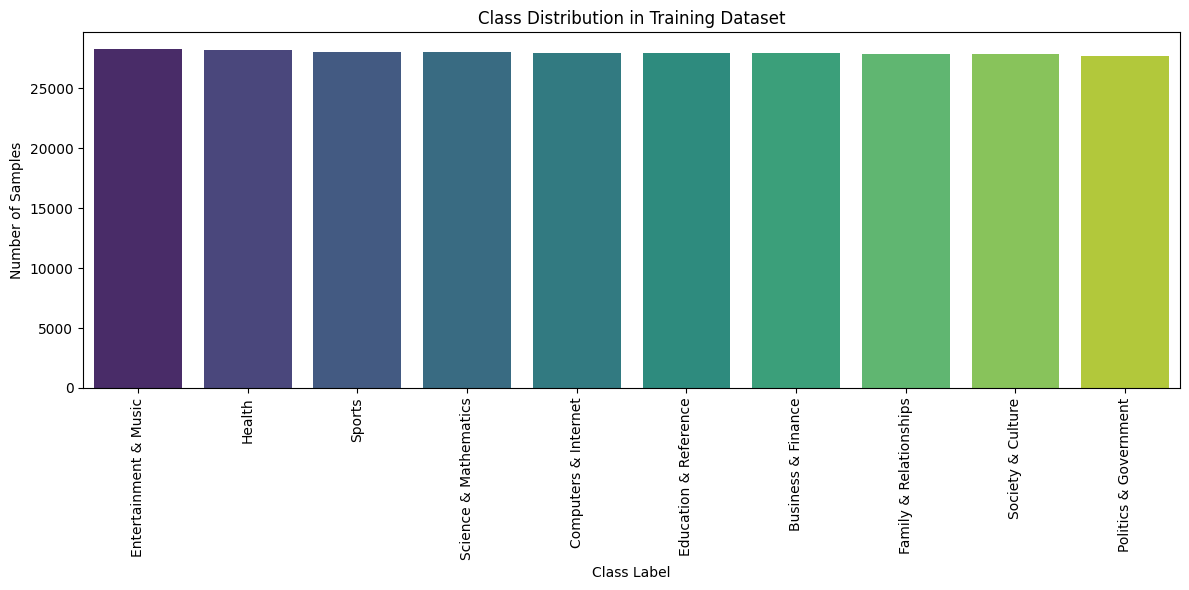

In [ ]:
# Distribution of classes
class_counts=train_df['Class'].value_counts().sort_values(ascending=False)
print("Class distribution:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(12,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The training dataset is well balanced, and that’s a big advantage because we won’t be needing heavy class-balancing techniques(oversampling,undersampling).

In [ ]:
# Check for duplicates in QA Text
dup_count = train_df.duplicated(subset=['QA Text']).sum()
print(f"Number of duplicate entries: {dup_count}")


Number of duplicate entries: 0


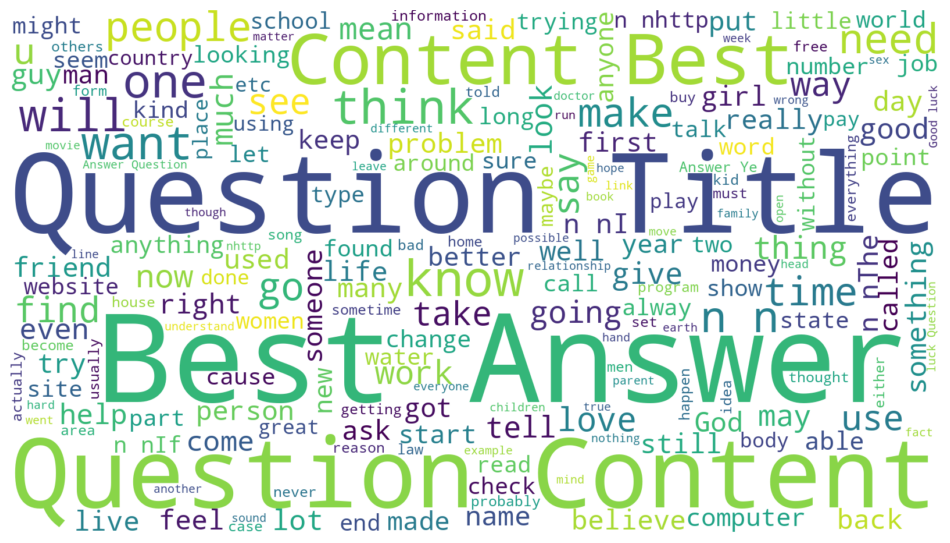

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = " ".join(train_df["QA Text"].astype(str))

wordcloud = WordCloud(width=1600, height=900, background_color='white').generate(text)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Extract bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=50000)
X_bigrams = bigram_vectorizer.fit_transform(train_df['QA Text'])

# Get top bigrams
bigram_counts = X_bigrams.sum(axis=0).A1
#sums the count of each bigram across all documents, turning the matrix into total counts per bigram.
bigram_freq = pd.DataFrame({'bigram': bigram_vectorizer.get_feature_names_out(),
                            'count': bigram_counts})
top_bigrams = bigram_freq.sort_values('count', ascending=False).head(20)
print(top_bigrams)

                 bigram   count
5131        best answer  281484
34826    question title  280008
34707  question content  280004
9056       content best  128525
29740         nhttp www   15931
43094        title does   13953
20052          http www   10477
12689          don know    8830
3794         answer yes    8060
17316         good luck    6180
18982         help best    5764
44255       title think    5527
3594       answer think    5190
2422         answer don    4919
26653         make sure    4879
42797        title best    4848
12239         does know    4576
19169     help question    4571
49487         yahoo com    4456
3257    answer question    4219


In [ ]:
# Extract trigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), stop_words='english', max_features=50000)
X_trigrams = trigram_vectorizer.fit_transform(train_df['QA Text'])

# Get top trigrams
trigram_counts = X_trigrams.sum(axis=0).A1
trigram_freq = pd.DataFrame({'trigram': trigram_vectorizer.get_feature_names_out(),
                             'count': trigram_counts})
top_trigrams = trigram_freq.sort_values('count', ascending=False).head(20)
print(top_trigrams)

                     trigram   count
32027  question content best  128494
11994    content best answer  127919
35228    question title does   13948
8904         best answer yes    7763
20021       help best answer    5674
37746   question title think    5520
8501       best answer think    5115
34580    question title best    4797
5932         best answer don    4772
20116  help question content    4466
36557    question title need    4183
8603         best answer try    4075
35168     question title did    3567
42957     thanks best answer    3375
32896  question content just    3168
6576        best answer http    3153
33166  question content need    3046
6781        best answer just    3045
36743  question title people    2972
36140    question title know    2950


In [ ]:
train_df["QA Text"][1]

"Question Title:\nMy daughter wants to be a Medical Illustrator.  Does anyone know what that is?\nQuestion Content:\nWhat do they do for sure.  I would like to be better informed so I can answer intelligently when people ask me what it is.\nBest Answer:\nMedical Illustrator\\nMedical Illustrator. Medical illustrators draw parts of the body, organism, surgical procedures, and other medical or biological models for...\\nhttp://www.aheckids.com/medill.htm \\n\\n \\nAssociation of Medical Illustrators\\nProfessional international organization of artists involved in creating material for the dissemination of medical and bioscientific knowledge through...\\nhttp://medical-illustrators.org/ \\n\\n \\nMedical Illustrator\\nMale Nurse Calendar The Mississippi Men in Nursing 2005 Calendar is now available. <more..> Medical Illustrator \\nhttp://www.mshealthcareers.com/careers/medicalillustrator.htm \\n\\n \\nMedartist.com, The Medical Illustrators' Home Page\\nSource of medical illustration and 

# EDA After Basic PreProcessing

**Clean Out The Noise**

In [ ]:
# Initialize resources
stop_words = set(stopwords.words('english'))       # common stopwords like "the", "and", "is"
lemmatizer = WordNetLemmatizer()                   # lemmatizer (defaults to noun lemmatization)
punct_tbl  = str.maketrans('', '', string.punctuation)  # translation table for removing punctuation

def clean_and_lemmatize(text: str) -> str:
    """
    Cleans and lemmatizes a text string.
    Steps:
      1. Lowercase the text
      2. Remove boilerplate patterns ("question title", "best answer", URLs, etc.)
      3. Remove punctuation
      4. Tokenize into words
      5. Filter tokens (keep only alphabetic words, not in stopwords, length >= 2)
      6. Lemmatize each word (noun default, since no POS tagging used)
      7. Join tokens back into a cleaned string
    """

    # Step 1: Lowercase
    t = text.lower()

    # Step 2: Remove boilerplate & URLs
    t = re.sub(r'question title:?', ' ', t)
    t = re.sub(r'question content:?', ' ', t)
    t = re.sub(r'best answer:?', ' ', t)
    t = re.sub(r'http\S+|www\.\S+', ' ', t)   # remove links
    t = re.sub(r'\n+', ' ', t)   # replace newlines with space

    # Step 3: Remove punctuation
    t = t.translate(punct_tbl)

    # Step 4: Tokenize
    tokens = word_tokenize(t)

    # Step 5: Filter tokens
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words and len(w) >= 2]

    # Step 6: Lemmatize (default WordNet lemmatizer assumes nouns)
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]

    # Step 7: Rejoin
    return " ".join(lemmas)

# Apply to train
train_df['QA Text'] = train_df['QA Text'].astype(str).apply(clean_and_lemmatize)


In [ ]:
train_df["QA Text"][1]

'daughter want medical illustrator anyone know sure would like better informed answer intelligently people ask medical illustratornmedical illustrator medical illustrator draw part body organism surgical procedure medical biological model forn nn nassociation medical illustratorsnprofessional international organization artist involved creating material dissemination medical bioscientific knowledge throughn nn nmedical illustratornmale nurse calendar mississippi men nursing calendar available medical illustrator nn nmedartistcom medical illustrator home pagensource medical illustration related service publisher hospital medical school biological laboratory pharmaceuticaln nn nwhat medical illustrator donwhat medical illustrator nn nmedical illustration wayne heim certified medical illustratornfor medical illustration need wayne heim freelance medical illustrator certified association medical illustratorsn nn ninstitute medical illustratorsndescribes aim activity association telephone co

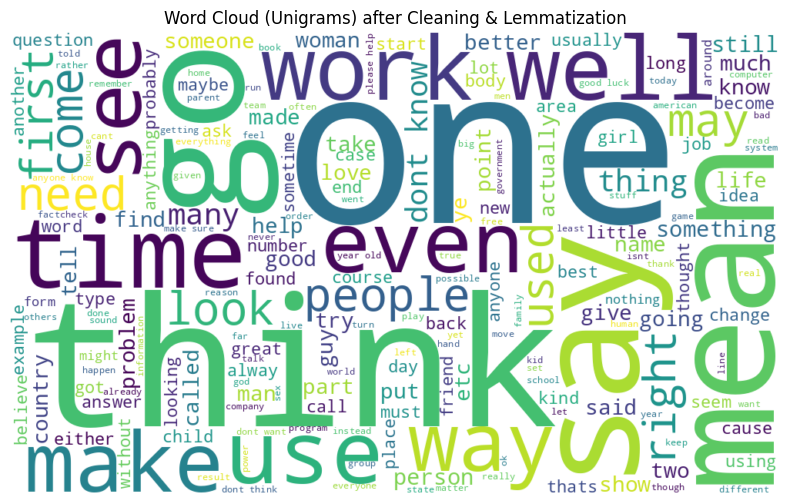

In [ ]:
# Top bigrams / trigrams

def top_ngrams(corpus, ngram_range=(2,2), topn=20):
    vec = CountVectorizer(ngram_range=ngram_range, max_features=80000)
    X = vec.fit_transform(corpus)
    counts = X.sum(axis=0).A1
    df = pd.DataFrame({'ngram': vec.get_feature_names_out(), 'count': counts})
    return df.sort_values('count', ascending=False).head(topn)

bigrams  = top_ngrams(train_df['QA Text'], (2,2), 20)
trigrams = top_ngrams(train_df['QA Text'], (3,3), 20)

# Word cloud (unigrams)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(train_df['QA Text'])
wc = WordCloud(width=1000, height=600, background_color="white",
               stopwords=None, max_words=200).generate(all_text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (Unigrams) after Cleaning & Lemmatization")
plt.show()


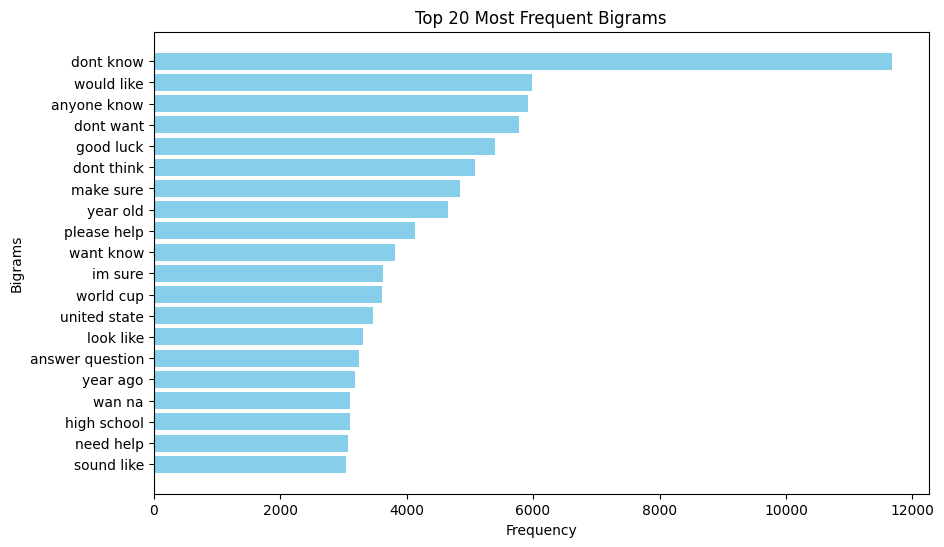

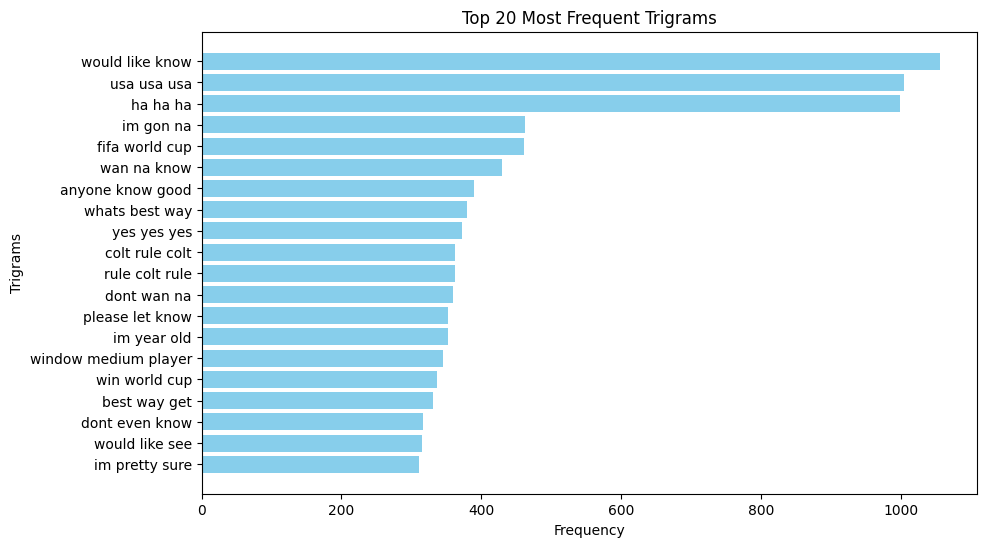

In [ ]:
def plot_top_ngrams(df, column_name, title, top_n=20):
    """
    Creates a horizontal bar plot of the most frequent n-grams.

    Args:
        df : DataFrame with ['ngram', 'count'] columns
        column_name : str -> label for x-axis
        title : str -> plot title
        top_n : int -> how many n-grams to display
    """
    # take top_n n-grams
    top_df = df.sort_values('count', ascending=False).head(top_n)

    plt.figure(figsize=(10,6))
    plt.barh(top_df['ngram'], top_df['count'], color="skyblue")
    plt.xlabel("Frequency")
    plt.ylabel(column_name)
    plt.title(title)
    plt.gca().invert_yaxis()  # highest count at top
    plt.show()

# Plot top 20 bigrams
plot_top_ngrams(bigrams, "Bigrams", "Top 20 Most Frequent Bigrams")

# Plot top 20 trigrams
plot_top_ngrams(trigrams, "Trigrams", "Top 20 Most Frequent Trigrams")

 In text analysis, the standard deviation of word counts across documents indicates how varied document lengths are. A high sd means documents vary widely in length; low sd indicates more uniform lengths.



    count (280003): The total number of rows (texts) analyzed is 280,003.

    mean (45.13): On average, each text has about 45 words.

    std (49.84): The standard deviation is about 49.8 words, indicating a wide variation in text length. Some texts are much shorter or longer than the average.

    min (0): The shortest text has 0 words (an empty or missing text).

    25% (15): The first quartile; 25% of texts have 15 words or fewer.

    50% (30): The median; half the texts have 30 words or fewer.

    75% (56): The third quartile; 75% of texts have 56 words or fewer.

    max (1007): The longest text has 1007 words.

Interpretation:

    Majority of texts are relatively short, with half shorter than 30 words.

    There's a long tail of very long texts (up to 1007 words).

    The high standard deviation shows notable variability in text length across the dataset

In [ ]:
# Split QA Text into lists of words
train_df["word_list"] = train_df["QA Text"].apply(lambda x: x.split()) #based on whitespace

# Word counts per row
train_df["word_count"] = train_df["word_list"].apply(len)

# Summary statistics
print("=== Training Data Word Count Statistics ===")
print(train_df["word_count"].describe())

# Max number of words in a row
max_words = train_df["word_count"].max()
idx_max   = train_df["word_count"].idxmax()
print(f"\nMax words in a row: {max_words}")
print("Example row with max words:")
print(train_df.loc[idx_max, "QA Text"][:500], "...")  # preview first 500 chars

# Other useful info
unique_word_counts = train_df["word_list"].apply(set).apply(len)
print(f"\nAverage unique words per row: {unique_word_counts.mean():.2f}")
print(f"Median unique words per row: {unique_word_counts.median():.2f}")


=== Training Data Word Count Statistics ===
count    280003.000000
mean         45.132406
std          49.842001
min           0.000000
25%          15.000000
50%          30.000000
75%          56.000000
max        1007.000000
Name: word_count, dtype: float64

Max words in a row: 1007
Example row with max words:
country consider favorite win fifa world cup usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa usa ...

Average unique words per row: 35.27
Median unique words per row: 25.00


IQR method found 18676 outliers
Lower threshold: -46.50, Upper threshold: 117.50


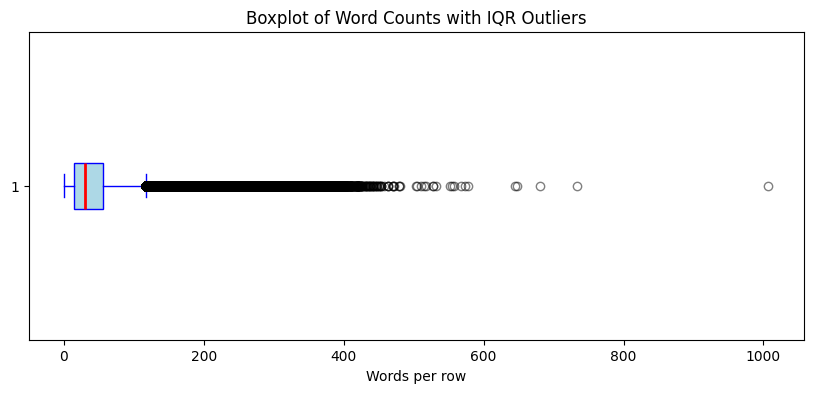

In [ ]:

# --- IQR Outlier Detection ---
Q1 = train_df['word_count'].quantile(0.25)
Q3 = train_df['word_count'].quantile(0.75)
IQR = Q3 - Q1

low_thresh  = Q1 - 1.5 * IQR
high_thresh = Q3 + 1.5 * IQR

iqr_outliers = train_df[(train_df['word_count'] < low_thresh) |
                        (train_df['word_count'] > high_thresh)]

print(f"IQR method found {len(iqr_outliers)} outliers")
print(f"Lower threshold: {low_thresh:.2f}, Upper threshold: {high_thresh:.2f}")

# --- Boxplot Visualization ---
plt.figure(figsize=(10,4))
plt.boxplot(train_df['word_count'], vert=False, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="blue"),
            capprops=dict(color="blue"),
            flierprops=dict(marker='o', color='orange', alpha=0.5))

plt.title("Boxplot of Word Counts with IQR Outliers")
plt.xlabel("Words per row")
plt.show()

In [ ]:
# Outlier analysis based on word counts

# Very short rows: <3 words
short_rows = train_df[train_df['word_count'] < 3]
print(f"Number of very short rows (<3 words): {len(short_rows)}")
print("\nExamples of short rows:")
print(short_rows['QA Text'].head(5).tolist())

# Very long rows: >500 words
long_rows = train_df[train_df['word_count'] > 500]
print(f"\nNumber of very long rows (>500 words): {len(long_rows)}")
print("\nExamples of long rows (first 300 chars):")
for t in long_rows['QA Text'].head(3):
    print(t[:300], "...\n")



Number of very short rows (<3 words): 977

Examples of short rows:
['anyone pic', 'love feeling', 'alpha blondy', '', 'vernoica hart']

Number of very long rows (>500 words): 19

Examples of long rows (first 300 chars):
need help making essay flow naturallyplease help majority american television home everyday people watching television forget spend time child spouse forget hello day american immune television forget family member living household nowadays people child focused television physically mentally influen ...

monk priest expected teach atheist science george lamaitrejesuit priest father big bang theory gregor mendelmonk took balanced approach evolution slightly ahead darwin two good examplesnndid god sense humour monk called gregor mendel actually ended father genetics unlike darwin blending theory prove ...

six letter word fourth alphabet english word abated abater abates abatis abator acetal acetic acetin acetum acetyl acuter acute adytum agate airted airths alated alates

In [ ]:
# Build vocabulary from preprocessed text
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(train_df['QA Text'])

terms = vectorizer.get_feature_names_out()
counts = np.asarray(X.sum(axis=0)).ravel()

print(f"Vocabulary size (after cleaning): {len(terms):,} unique words")

Vocabulary size (after cleaning): 603,877 unique words


In [ ]:
hapax_count = (counts == 1).sum()
hapax_pct = 100 * hapax_count / len(terms)

print(f"Hapax legomena: {hapax_count:,} words ({hapax_pct:.2f}% of vocab)")


Hapax legomena: 444,927 words (73.68% of vocab)


          term  count
205940     get  92653
292813    like  91961
380014     one  81946
591095   would  80996
279305    know  79781
145118    dont  72155
532968   think  62192
400029  people  59923
572984    want  58999
537318    time  57737
209601      go  55707
345831    need  51629
211771    good  51432
306130    make  49894
228839    help  47940
247817      im  44969
595484    year  40475
16787     also  39208
532179   thing  38868
575622     way  38674


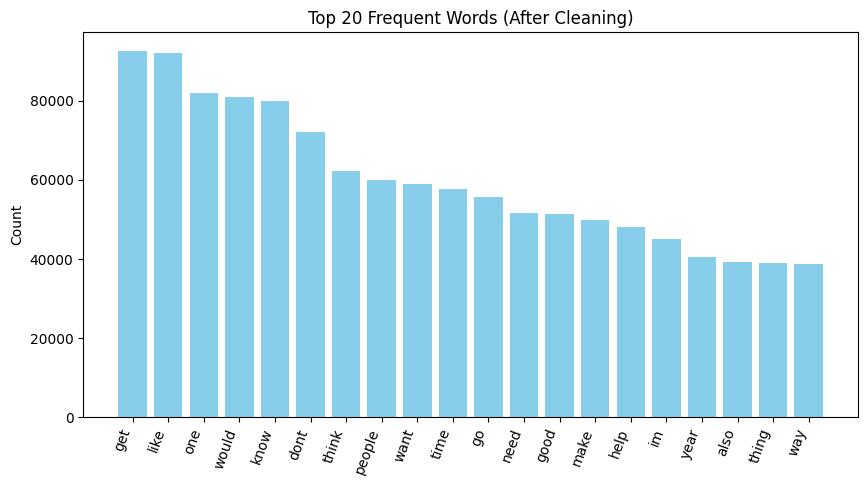

In [ ]:
# Make frequency DataFrame
freq_df = pd.DataFrame({'term': terms, 'count': counts})
freq_df = freq_df.sort_values(by='count', ascending=False)

# Top 20 frequent words
print(freq_df.head(20))

# Optional: plot top 20
plt.figure(figsize=(10,5))
plt.bar(freq_df.head(20)['term'], freq_df.head(20)['count'], color="skyblue")
plt.xticks(rotation=70, ha='right')
plt.title("Top 20 Frequent Words (After Cleaning)")
plt.ylabel("Count")
plt.show()


In [ ]:
total_tokens = counts.sum()
top_vocab = freq_df.head(50000)['count'].sum()
coverage = 100 * top_vocab / total_tokens
print(f"Top 50k words cover {coverage:.2f}% of all tokens")


Top 50k words cover 94.02% of all tokens


   min_df  vocab_size  tokens_kept  coverage_pct
0       2      142313     12146887     96.139276
1       3       89248     12029935     95.213633
2       4       68003     11958521     94.648411
3       5       56489     11906253     94.234724


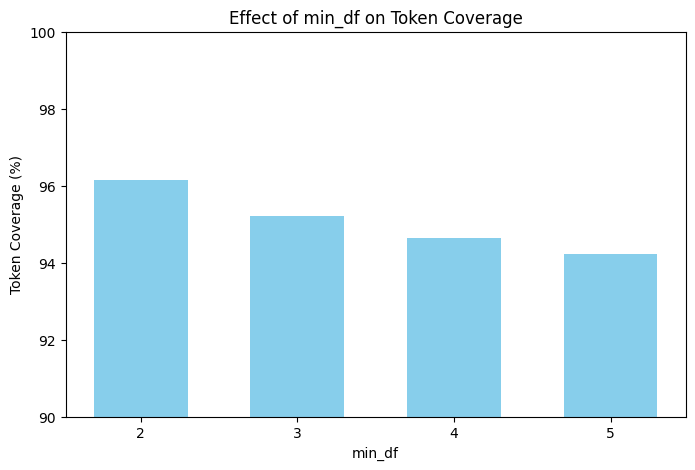

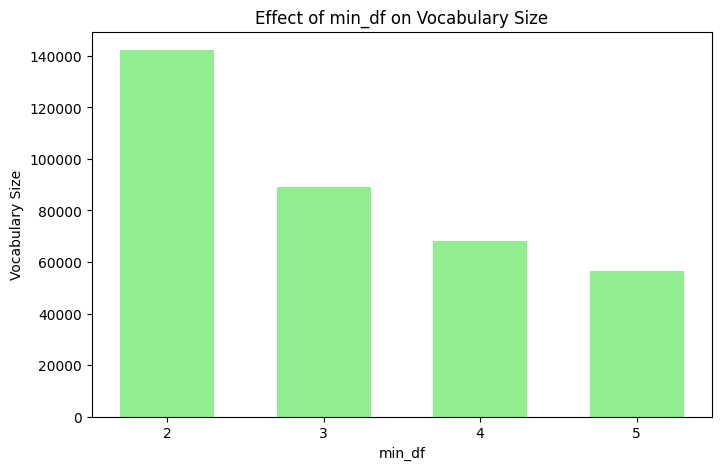

In [ ]:

results = []

total_tokens = counts.sum()

# Try different min_df values
for m in [2, 3, 4, 5]:
    vec = CountVectorizer(min_df=m)
    X = vec.fit_transform(train_df["QA Text"])
    counts = np.asarray(X.sum(axis=0)).ravel()
    kept_tokens = counts.sum()
    coverage = 100 * kept_tokens / total_tokens

    results.append({
        "min_df": m,
        "vocab_size": len(vec.get_feature_names_out()),
        "tokens_kept": kept_tokens,
        "coverage_pct": coverage
    })

# Put results in a DataFrame
coverage_df = pd.DataFrame(results)
print(coverage_df)

plt.figure(figsize=(8,5))
plt.bar(coverage_df['min_df'], coverage_df['coverage_pct'], color="skyblue", width=0.6)
plt.xticks(coverage_df['min_df'])
plt.ylim(90, 100)
plt.xlabel("min_df")
plt.ylabel("Token Coverage (%)")
plt.title("Effect of min_df on Token Coverage")
plt.show()

# vocab size plot
plt.figure(figsize=(8,5))
plt.bar(coverage_df['min_df'], coverage_df['vocab_size'], color="lightgreen", width=0.6)
plt.xticks(coverage_df['min_df'])
plt.xlabel("min_df")
plt.ylabel("Vocabulary Size")
plt.title("Effect of min_df on Vocabulary Size")
plt.show()

# EDA Findings

**Class Distribution**

The dataset is well balanced across the 10 categories (≈27–28k samples each).

The difference between the largest (Entertainment & Music: 28,267) and smallest (Politics & Government: 27,746) class is <2%.

No rebalancing (oversampling/undersampling) is needed.

**Outlier Detection (IQR)**

IQR method confirms presence of outliers on both tails of word count distribution.
For very long rows: truncate to a fixed maximum length (e.g., 300 words), which covers >95% of rows without losing too much content.

We will drop ultra-short rows (<3 words) since they add no semantic signal.
This ensures more consistent input lengths for ML/NN models and reduces noise.

**Vocabulary Pruning Decision**

We observed that ~74% of the vocabulary consists of hapax legomena. By applying a minimum document frequency (min_df=5), we will reduce the vocabulary size from ~604k to ~56k while still covering 94.2% of all tokens. This pruning step removes rare/noisy words, significantly reduces dimensionality, and speeds up model training without sacrificing semantic coverage.

# Feature Engineering

In [ ]:

new_path = "/content/drive/MyDrive/CSE440/Project/Copy of [Updated] Question Answer Classification Dataset[Test].csv"
test_df = pd.read_csv(new_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df.head()

QA Text                  Class
0  Question Title:\ni am good at web design amate...     Business & Finance
1  Question Title:\nMy daughter wants to be a Med...  Education & Reference
2  Question Title:\nIs brother Jesus our brother ...      Society & Culture
3  Question Title:\nwhat is I-20?\nQuestion Conte...  Education & Reference
4  Question Title:\nwhat is a data disk?\nQuestio...   Computers & Internet

In [ ]:
train_df = train_df.drop(columns=['word_list', 'word_count'], errors='ignore')
test_df.shape

(59999, 2)

In [ ]:
test_df['QA Text'] = test_df['QA Text'].astype(str).apply(clean_and_lemmatize)


***What to do now in preprocessing (before feature extraction)***

**Text Cleaning (already done):**

1. Lowercasing

2. Remove boilerplate tokens (Question Title, Best Answer, URLs, etc.)

3. Remove punctuation, numbers, extra whitespace

4. Stopword removal

5. Lemmatization

**Noise Handling**

1. Drop rows with <3 words.

2. Truncate rows with >300 words.


**Target Encoding**

1. Apply LabelEncoder to map the 10 classes to integers (0–9) for ML Models.

2. Keep One-Hot encoded labels separately for Neural Nets.


***Next Stage (feature extraction = experiment-dependent)***



    CBOW: Given context → predict target word

    Skip-Gram: Given target word → predict context words


**BoW:** use CountVectorizer(min_df=5, ngram_range=(1,2))

**TF-IDF:** use TfidfVectorizer(min_df=5, ngram_range=(1,2))

***Skip-gram:*** train embeddings.

**GloVe:** load pre-trained embeddings and map vocabulary.

In [ ]:
#noise handling (drop <3 words; truncate >300 words)

def drop_and_truncate(df, text_col="QA Text", min_words=3, max_words=300):
    # word count
    wc = df[text_col].str.split().str.len()

    # drop ultra-short
    df = df[wc >= min_words].copy()

    # truncate long
    df[text_col] = df[text_col].apply(lambda s: " ".join(s.split()[:max_words]))
    return df

train_df = drop_and_truncate(train_df, "QA Text", min_words=3, max_words=300)
test_df  = drop_and_truncate(test_df,  "QA Text", min_words=3, max_words=300)


In [ ]:
#Label Encoding for ML Models
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["Class"])
test_df["label"]  = le.transform(test_df["Class"])

# one-hot for neural nets
num_classes = len(le.classes_)
y_train_oh = np.eye(num_classes)[train_df["label"].values]
y_test_oh  = np.eye(num_classes)[test_df["label"].values]


In [ ]:
y_train_oh

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# keep clean structure
train_df = train_df[["QA Text", "Class", "label"]]
test_df  = test_df[["QA Text", "Class", "label"]]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/CSE440/Project"

# Save cleaned train & test sets
train_df.to_csv(f"{project_path}/train_clean.csv", index=False)
test_df.to_csv(f"{project_path}/test_clean.csv", index=False)

np.save(f"{project_path}/y_train_oh.npy", y_train_oh)
np.save(f"{project_path}/y_test_oh.npy", y_test_oh)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Machine Learning Models

In [ ]:
# Models & preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
#Performs hyperparameter tuning using cross-validation to find the best model parameters.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline #    Allows chaining multiple steps (like vectorization and classification) into a single workflow.



# Metrics & plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
# Metrics and plots related to the ROC curve, evaluating classifier performance.
from sklearn.preprocessing import label_binarize



In [ ]:
project_path = "/content/drive/MyDrive/CSE440/Project"
train_df = pd.read_csv(f"{project_path}/train_clean.csv", keep_default_na=False)
test_df  = pd.read_csv(f"{project_path}/test_clean.csv", keep_default_na=False)





In [ ]:
train_df.head()

QA Text                  Class  \
0  good web design amateurly earn money job web d...     Business & Finance   
1  daughter want medical illustrator anyone know ...  Education & Reference   
2  brother jesus brother king one id say brother ...      Society & Culture   
3  student need admitted university hell earth me...  Education & Reference   
4  data disk heard possible save file data disk e...   Computers & Internet   

   label  
0      0  
1      2  
2      8  
3      2  
4      1

In [ ]:
TEXT_COL = "QA Text"
LABEL_COL = "label"

X_train_full = train_df[TEXT_COL].astype(str).values
y_train_full = train_df[LABEL_COL].values

X_test = test_df[TEXT_COL].astype(str).values
y_test = test_df[LABEL_COL].values


**Validation Split**

we keep the test set untouched. CV is performed only within the train split; we also hold out a validation set to compare configs (tf-idf vs bow).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    stratify=y_train_full,
    random_state=42
)

print("Train:", len(X_train), "Validation:", len(X_val), "Test:", len(X_test))



Train: 238002 Validation: 42001 Test: 59999


**General Evaluation Function**

This function evaluates a trained model on any split (validation/test) and gives:

* Accuracy

* Macro(unbalanced) & Weighted F1

* Classification report

* Confusion Matrix (heatmap)

* ROC Curve & AUC

In [ ]:
def evaluate_model(model, X_eval, y_eval, dataset_name="Validation", class_names=None):
    y_pred = model.predict(X_eval)

    # --- Basic metrics
    acc = accuracy_score(y_eval, y_pred)
    f1_macro = f1_score(y_eval, y_pred, average="macro")
    f1_weighted = f1_score(y_eval, y_pred, average="weighted")

    print(f"\n=== {dataset_name} Evaluation ===")
    print(f"Accuracy       : {acc:.4f}")
    print(f"F1 (Macro)     : {f1_macro:.4f}")
    print(f"F1 (Weighted)  : {f1_weighted:.4f}")
    print("\nClassification Report:\n", classification_report(y_eval, y_pred, zero_division=0))

    # --- Confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names if class_names is not None else np.unique(y_eval),
                yticklabels=class_names if class_names is not None else np.unique(y_eval))
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- ROC & AUC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_eval)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_eval)
    else:
        print("ROC-AUC not available: model has no probability/decision_function.")
        return

    classes = np.unique(y_eval)

    # Binary
    if len(classes) == 2:
        fpr, tpr, _ = roc_curve(y_eval, y_score[:, 1])
        auc_bin = auc(fpr, tpr)
        print(f"ROC-AUC (binary): {auc_bin:.4f}")

        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc_bin:.4f}")
        plt.plot([0,1], [0,1], lw=2, linestyle="--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"{dataset_name} ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    # Multiclass (OvR)
    else:
        # Per-class curves (nice for the figure)
        y_bin = label_binarize(y_eval, classes=classes)
        plt.figure()
        per_class_auc = {}
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            auc_i = auc(fpr, tpr)
            per_class_auc[cls] = auc_i
            plt.plot(fpr, tpr, lw=1.8, label=f"Class {cls} (AUC={auc_i:.3f})")

        # Macro / Weighted / Micro using sklearn’s built-ins
        auc_macro   = roc_auc_score(y_eval, y_score, multi_class="ovr", average="macro")
        auc_weighted= roc_auc_score(y_eval, y_score, multi_class="ovr", average="weighted")
        auc_micro   = roc_auc_score(y_eval, y_score, multi_class="ovr", average="micro")

        print("ROC-AUC (per class):", {str(k): float(v) for k, v in per_class_auc.items()})
        print(f"ROC-AUC (macro)   : {auc_macro:.4f}")
        print(f"ROC-AUC (weighted): {auc_weighted:.4f}")
        print(f"ROC-AUC (micro)   : {auc_micro:.4f}")

        plt.plot([0,1], [0,1], lw=2, linestyle="--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"{dataset_name} ROC Curves (OvR)")
        plt.legend(loc="lower right")
        plt.show()



### Logistic Regression


=== Validation Evaluation ===
Accuracy       : 0.7017
F1 (Macro)     : 0.6993
F1 (Weighted)  : 0.6994

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.51      0.54      4193
           1       0.82      0.86      0.84      4197
           2       0.55      0.51      0.53      4196
           3       0.67      0.70      0.69      4240
           4       0.69      0.77      0.73      4186
           5       0.76      0.79      0.78      4228
           6       0.76      0.74      0.75      4162
           7       0.69      0.73      0.71      4206
           8       0.59      0.56      0.57      4182
           9       0.87      0.84      0.86      4211

    accuracy                           0.70     42001
   macro avg       0.70      0.70      0.70     42001
weighted avg       0.70      0.70      0.70     42001



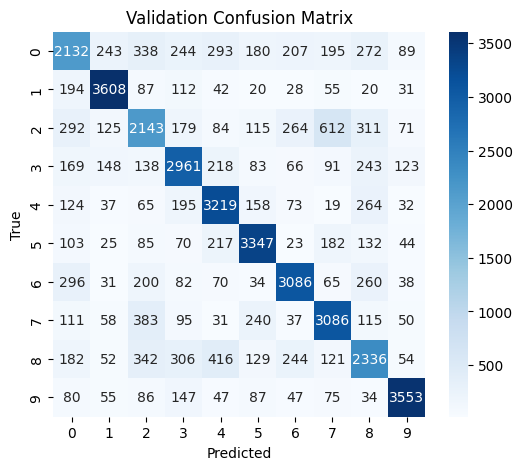

ROC-AUC (per class): {np.int64(0): np.float64(0.8636657858516992), np.int64(1): np.float64(0.9819280425298873), np.int64(2): np.float64(0.8815100575692659), np.int64(3): np.float64(0.9414467819698171), np.int64(4): np.float64(0.960257796920267), np.int64(5): np.float64(0.9675675118564788), np.int64(6): np.float64(0.9634690353711498), np.int64(7): np.float64(0.9523032474223854), np.int64(8): np.float64(0.9021528757461367), np.int64(9): np.float64(0.9795254857723716)}


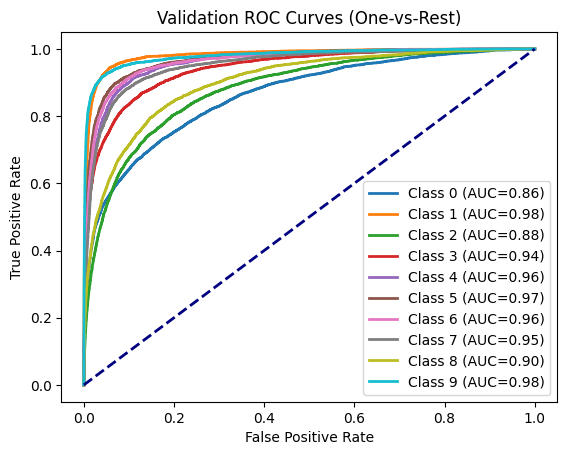

In [ ]:
#Logistic Regression With Tf-Idf

pipe_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5)),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])
#Setting class_weight="balanced" helps mitigate class imbalance problems by weighting classes inversely to their frequency,
pipe_tfidf.fit(X_train, y_train)

# Validation evaluation
evaluate_model(pipe_tfidf, X_val, y_val, dataset_name="Validation")
#macro--balanced dataset



=== Validation Evaluation ===
Accuracy       : 0.6649
F1 (Macro)     : 0.6645
F1 (Weighted)  : 0.6647

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.48      0.48      4193
           1       0.81      0.83      0.82      4197
           2       0.48      0.48      0.48      4196
           3       0.65      0.68      0.66      4240
           4       0.68      0.72      0.70      4186
           5       0.74      0.74      0.74      4228
           6       0.74      0.70      0.72      4162
           7       0.65      0.67      0.66      4206
           8       0.54      0.51      0.52      4182
           9       0.86      0.84      0.85      4211

    accuracy                           0.66     42001
   macro avg       0.66      0.66      0.66     42001
weighted avg       0.66      0.66      0.66     42001



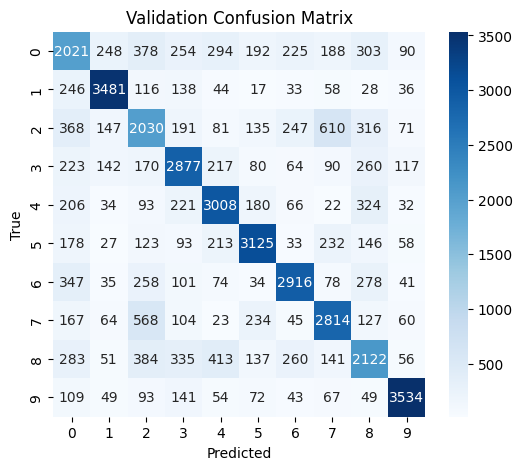

ROC-AUC (per class): {np.int64(0): np.float64(0.8365767515615319), np.int64(1): np.float64(0.9733708762099547), np.int64(2): np.float64(0.8449341384700905), np.int64(3): np.float64(0.9247023358931273), np.int64(4): np.float64(0.9423605087230632), np.int64(5): np.float64(0.950984940638146), np.int64(6): np.float64(0.938871337690015), np.int64(7): np.float64(0.9311416822627916), np.int64(8): np.float64(0.8608554971287197), np.int64(9): np.float64(0.9729033179586295)}


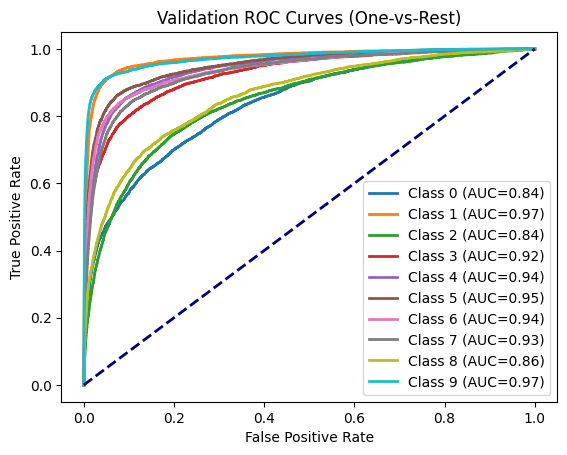

In [ ]:
#Logistic Regression with Bag Of Words
pipe_bow = Pipeline([
    ("bow", CountVectorizer(ngram_range=(1,2), min_df=5)),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

pipe_bow.fit(X_train, y_train)

# Validation evaluation
evaluate_model(pipe_bow, X_val, y_val, dataset_name="Validation")


Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'tfidf__max_features': 100000}

=== Validation (Tuned) Evaluation ===
Accuracy       : 0.6997
F1 (Macro)     : 0.6973
F1 (Weighted)  : 0.6974

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.51      0.54      4193
           1       0.82      0.86      0.84      4197
           2       0.55      0.50      0.53      4196
           3       0.67      0.70      0.68      4240
           4       0.70      0.76      0.73      4186
           5       0.76      0.79      0.77      4228
           6       0.76      0.74      0.75      4162
           7       0.68      0.73      0.71      4206
           8       0.59      0.56      0.57      4182
           9       0.87      0.85      0.86      4211

    accuracy                           0.70     42001
   macro avg       0.70      0.70      0.70     42001
weighted avg       0.70      0.70      0.70    

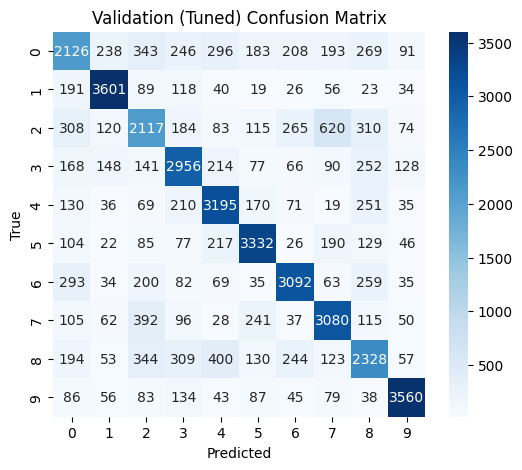

ROC-AUC (per class): {np.int64(0): np.float64(0.8634571457184501), np.int64(1): np.float64(0.9820582742125739), np.int64(2): np.float64(0.8810798073350415), np.int64(3): np.float64(0.9411671620864693), np.int64(4): np.float64(0.9600924964807482), np.int64(5): np.float64(0.9676803172494276), np.int64(6): np.float64(0.9633130785699835), np.int64(7): np.float64(0.9523252207063193), np.int64(8): np.float64(0.9011753218712266), np.int64(9): np.float64(0.9793215786047569)}


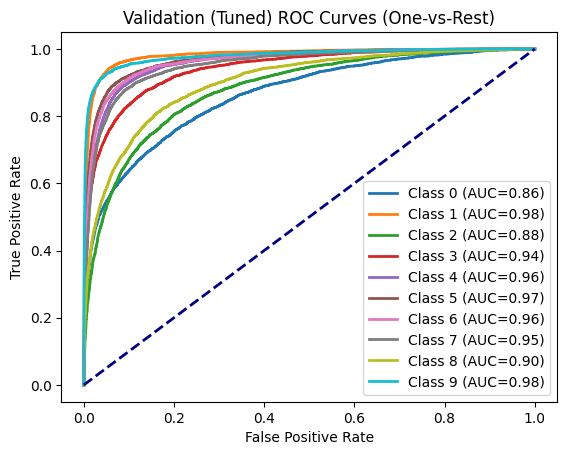

In [ ]:
#Hyperparameter Tuning

# Pipeline: TF-IDF + Logistic Regression
pipe_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5)),
    ("clf", LogisticRegression(solver="saga", max_iter=3000, random_state=42))
])
#Handles sparse data efficiently
# Grid with vocab cap
param_grid = {
    "tfidf__max_features": [50000, 100000],  # 50000 to 1---max freq words
    "clf__C": [0.01, 0.1, 1, 2], #helps with feature weight, 0.1 prevent overfitting #Inverse of regularization strength
    #Small C → stronger regularization → prevents overfitting, but may underfit.
    #Large C → weaker regularization → model may overfit.

clf__penalty: ["l2"]
    "clf__penalty": ["l2"],
    "clf__class_weight": ["balanced"]#. It helps prevent overfitting by discouraging the model from assigning too much importance (large weights)
}

grid = GridSearchCV(
    estimator=pipe_tfidf,
    param_grid=param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,#parallel processing
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
evaluate_model(grid.best_estimator_, X_val, y_val, dataset_name="Validation (Tuned)")



=== Test Evaluation ===
Accuracy       : 0.7030
F1 (Macro)     : 0.7007
F1 (Weighted)  : 0.7007

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.51      0.54      6000
           1       0.82      0.85      0.84      6000
           2       0.55      0.51      0.53      6000
           3       0.68      0.70      0.69      6000
           4       0.69      0.76      0.73      5999
           5       0.75      0.78      0.77      6000
           6       0.76      0.75      0.76      6000
           7       0.69      0.75      0.72      6000
           8       0.60      0.56      0.58      6000
           9       0.87      0.86      0.87      6000

    accuracy                           0.70     59999
   macro avg       0.70      0.70      0.70     59999
weighted avg       0.70      0.70      0.70     59999



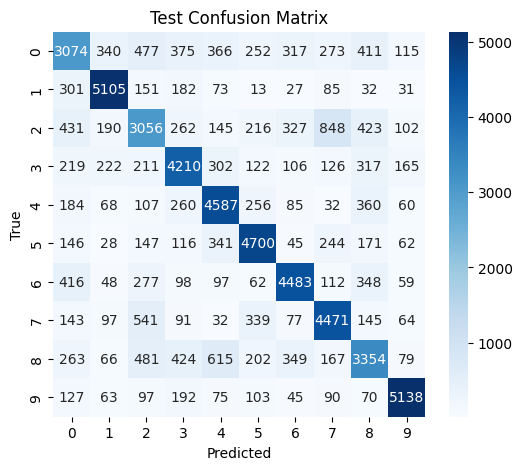

ROC-AUC (per class): {'0': 0.8582215642882275, '1': 0.9811867796934511, '2': 0.8807038355648562, '3': 0.9416021392371464, '4': 0.9576002944935266, '5': 0.9640790786249127, '6': 0.9647689895491892, '7': 0.9547865207380385, '8': 0.9051298619727527, '9': 0.9813108714976203}
ROC-AUC (macro)   : 0.9389
ROC-AUC (weighted): 0.9389
ROC-AUC (micro)   : 0.9454


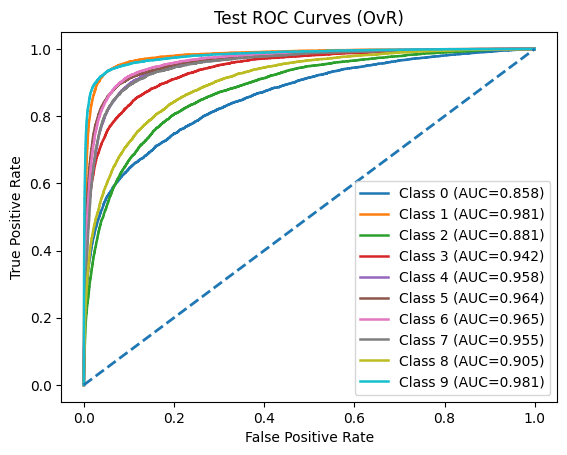

In [ ]:
best_model = pipe_tfidf

evaluate_model(best_model, X_test, y_test, dataset_name="Test")


### Multinomial Naive Bayes


=== Validation (MNB TF-IDF Baseline) Evaluation ===
Accuracy       : 0.6909
F1 (Macro)     : 0.6858
F1 (Weighted)  : 0.6859

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.50      0.54      4193
           1       0.80      0.87      0.83      4197
           2       0.59      0.43      0.50      4196
           3       0.69      0.66      0.68      4240
           4       0.60      0.81      0.69      4186
           5       0.74      0.80      0.77      4228
           6       0.72      0.77      0.74      4162
           7       0.70      0.73      0.71      4206
           8       0.58      0.54      0.56      4182
           9       0.87      0.81      0.84      4211

    accuracy                           0.69     42001
   macro avg       0.69      0.69      0.69     42001
weighted avg       0.69      0.69      0.69     42001



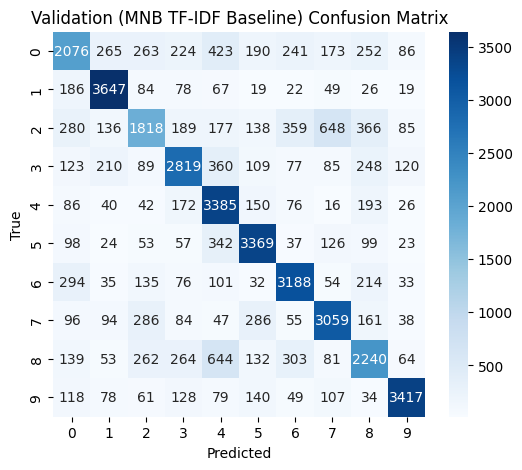

ROC-AUC (per class): {'0': 0.8551486314070194, '1': 0.9816797810973253, '2': 0.8719418762353449, '3': 0.9402815460995245, '4': 0.9573166418172714, '5': 0.9650471999980165, '6': 0.9637595819837047, '7': 0.9503324835277432, '8': 0.90094004606426, '9': 0.9744677101373065}
ROC-AUC (macro)   : 0.9361
ROC-AUC (weighted): 0.9361
ROC-AUC (micro)   : 0.9418


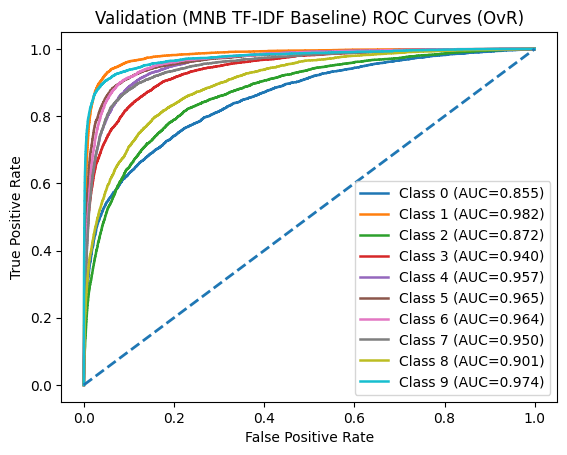

In [ ]:
# ==== Baseline: TF-IDF + MultinomialNB ====
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

VOCAB_CAP = 100000
mnb_tfidf_baseline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=VOCAB_CAP)),
    ("clf", MultinomialNB())   # default alpha=1.0 is a solid baseline,smoothing
])

# Train on TRAIN only
mnb_tfidf_baseline.fit(X_train, y_train)

# Evaluate on VALIDATION first
evaluate_model(mnb_tfidf_baseline, X_val, y_val, dataset_name="Validation (MNB TF-IDF Baseline)")



=== Validation (MNB BoW Baseline) Evaluation ===
Accuracy       : 0.6856
F1 (Macro)     : 0.6819
F1 (Weighted)  : 0.6820

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.49      0.54      4193
           1       0.80      0.86      0.83      4197
           2       0.56      0.45      0.50      4196
           3       0.63      0.70      0.66      4240
           4       0.61      0.80      0.69      4186
           5       0.77      0.77      0.77      4228
           6       0.74      0.73      0.74      4162
           7       0.70      0.71      0.71      4206
           8       0.58      0.52      0.55      4182
           9       0.87      0.81      0.84      4211

    accuracy                           0.69     42001
   macro avg       0.68      0.69      0.68     42001
weighted avg       0.68      0.69      0.68     42001



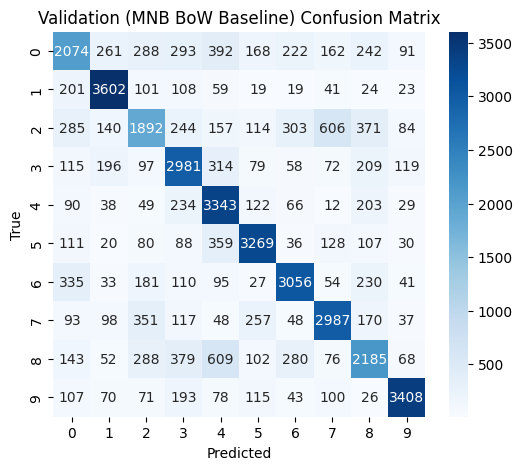

ROC-AUC (per class): {'0': 0.8432247615299828, '1': 0.9720719155448767, '2': 0.839051611242227, '3': 0.9270563544397659, '4': 0.9454621251561732, '5': 0.9429831933583429, '6': 0.939388539488337, '7': 0.9266932906373493, '8': 0.8610392551781637, '9': 0.9618923089133421}
ROC-AUC (macro)   : 0.9159
ROC-AUC (weighted): 0.9159
ROC-AUC (micro)   : 0.9202


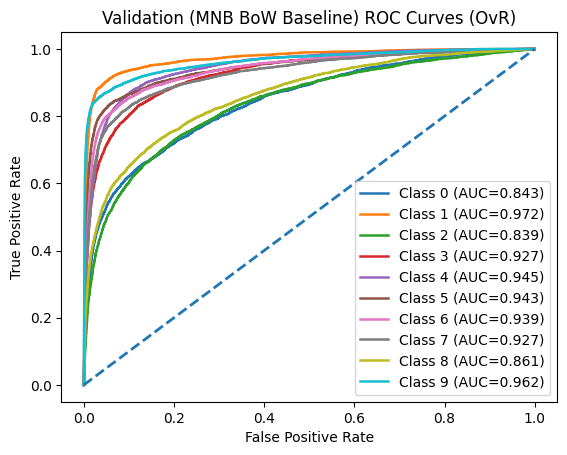

In [ ]:
#BOW + MultinomialNB

mnb_bow_baseline = Pipeline([
    ("bow", CountVectorizer(ngram_range=(1,2), min_df=5, max_features=VOCAB_CAP)),
    ("clf", MultinomialNB())
])

mnb_bow_baseline.fit(X_train, y_train)
evaluate_model(mnb_bow_baseline, X_val, y_val, dataset_name="Validation (MNB BoW Baseline)")



Alpha=0.5

=== Validation (MNB TF-IDF α=0.5) Evaluation ===
Accuracy       : 0.6925
F1 (Macro)     : 0.6880
F1 (Weighted)  : 0.6882

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.50      0.54      4193
           1       0.80      0.86      0.83      4197
           2       0.58      0.45      0.50      4196
           3       0.68      0.68      0.68      4240
           4       0.61      0.80      0.69      4186
           5       0.75      0.79      0.77      4228
           6       0.73      0.76      0.75      4162
           7       0.70      0.73      0.72      4206
           8       0.58      0.53      0.56      4182
           9       0.87      0.82      0.84      4211

    accuracy                           0.69     42001
   macro avg       0.69      0.69      0.69     42001
weighted avg       0.69      0.69      0.69     42001



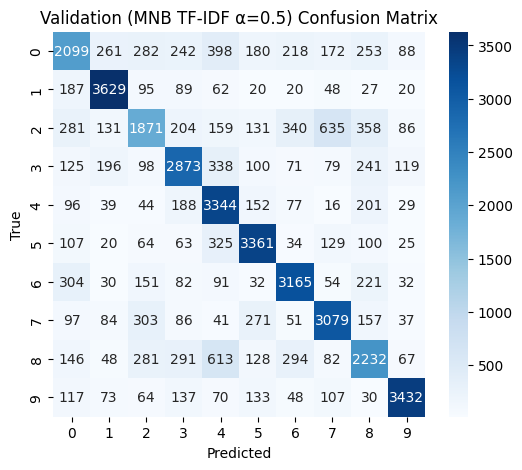

ROC-AUC (per class): {'0': 0.8560845235933698, '1': 0.9817343620571118, '2': 0.8712759357038761, '3': 0.9407714883030461, '4': 0.9574741529331667, '5': 0.9652459736761912, '6': 0.9634935391493226, '7': 0.9508378376049134, '8': 0.900610852146072, '9': 0.9749622502940767}
ROC-AUC (macro)   : 0.9362
ROC-AUC (weighted): 0.9363
ROC-AUC (micro)   : 0.9423


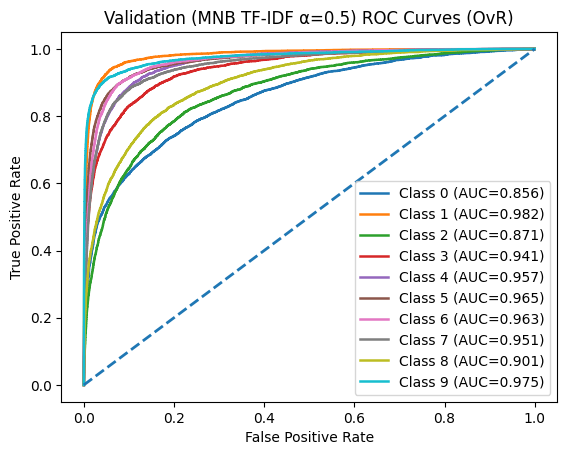


Alpha=1.0

=== Validation (MNB TF-IDF α=1.0) Evaluation ===
Accuracy       : 0.6909
F1 (Macro)     : 0.6858
F1 (Weighted)  : 0.6859

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.50      0.54      4193
           1       0.80      0.87      0.83      4197
           2       0.59      0.43      0.50      4196
           3       0.69      0.66      0.68      4240
           4       0.60      0.81      0.69      4186
           5       0.74      0.80      0.77      4228
           6       0.72      0.77      0.74      4162
           7       0.70      0.73      0.71      4206
           8       0.58      0.54      0.56      4182
           9       0.87      0.81      0.84      4211

    accuracy                           0.69     42001
   macro avg       0.69      0.69      0.69     42001
weighted avg       0.69      0.69      0.69     42001



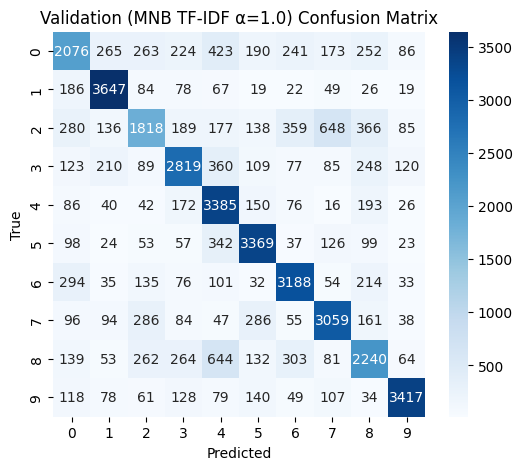

ROC-AUC (per class): {'0': 0.8551486314070194, '1': 0.9816797810973253, '2': 0.8719418762353449, '3': 0.9402815460995245, '4': 0.9573166418172714, '5': 0.9650471999980165, '6': 0.9637595819837047, '7': 0.9503324835277432, '8': 0.90094004606426, '9': 0.9744677101373065}
ROC-AUC (macro)   : 0.9361
ROC-AUC (weighted): 0.9361
ROC-AUC (micro)   : 0.9418


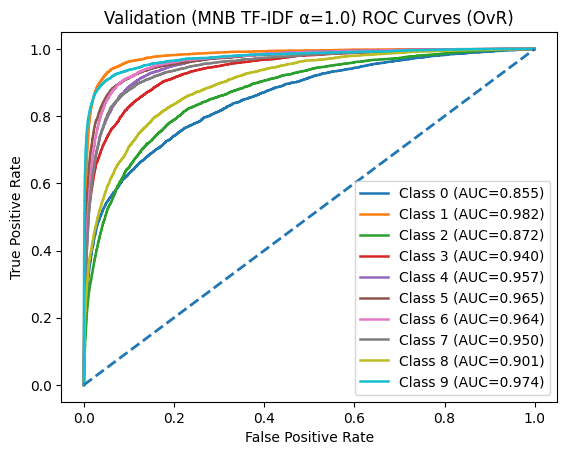


Alpha=2.0

=== Validation (MNB TF-IDF α=2.0) Evaluation ===
Accuracy       : 0.6866
F1 (Macro)     : 0.6810
F1 (Weighted)  : 0.6812

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.49      0.54      4193
           1       0.79      0.87      0.83      4197
           2       0.60      0.42      0.49      4196
           3       0.71      0.64      0.67      4240
           4       0.58      0.82      0.68      4186
           5       0.72      0.80      0.76      4228
           6       0.71      0.77      0.74      4162
           7       0.70      0.72      0.71      4206
           8       0.58      0.53      0.55      4182
           9       0.88      0.80      0.84      4211

    accuracy                           0.69     42001
   macro avg       0.69      0.69      0.68     42001
weighted avg       0.69      0.69      0.68     42001



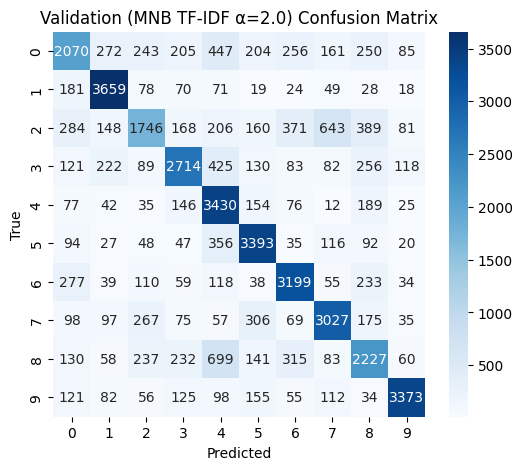

ROC-AUC (per class): {'0': 0.8530160555412518, '1': 0.9814231308359558, '2': 0.8722308635869003, '3': 0.9391247108801983, '4': 0.9568016430734815, '5': 0.9645459234007582, '6': 0.9637168035557313, '7': 0.9494095804398646, '8': 0.9007313637389014, '9': 0.9734973750687236}
ROC-AUC (macro)   : 0.9354
ROC-AUC (weighted): 0.9355
ROC-AUC (micro)   : 0.9405


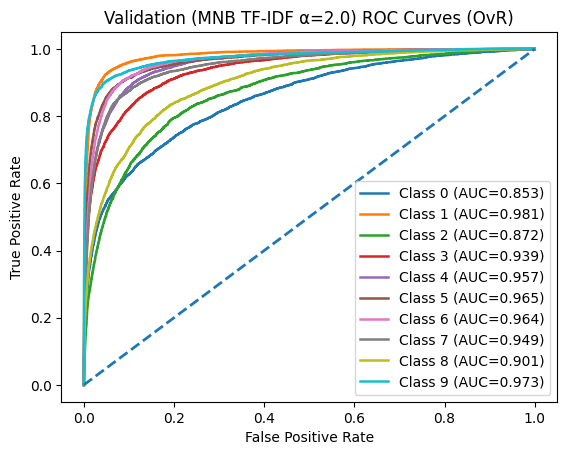

In [ ]:
for a in [0.5, 1.0, 2.0]:
    mnb = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5,max_df= 0.95, max_features=VOCAB_CAP)),
        ("clf", MultinomialNB(alpha=a))
    ])
    mnb.fit(X_train, y_train)
    print(f"\nAlpha={a}")
    evaluate_model(mnb, X_val, y_val, dataset_name=f"Validation (MNB TF-IDF α={a})")



In [ ]:
from sklearn.model_selection import cross_val_score

# Best pipeline
mnb_best = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.95,
        max_features= 50000
    )),
    ("clf", MultinomialNB(alpha=1.0))  # alpha=1 default
])

# Cross-validation on TRAIN only
cv_scores = cross_val_score(
    mnb_best,
    X_train, y_train,
    cv=5,             # 5-fold CV
    scoring="f1_macro",
    n_jobs=-1 #parallel processing
)

print("CV F1-macro scores:", cv_scores)
print("Mean CV F1-macro  :", np.mean(cv_scores))
print("Std CV F1-macro   :", np.std(cv_scores))

CV F1-macro scores: [0.68444759 0.68372914 0.68455281 0.68494488 0.68001891]
Mean CV F1-macro  : 0.6835386639837433
Std CV F1-macro   : 0.00180316555730415



=== Test (MNB TF-IDF Tuned) Evaluation ===
Accuracy       : 0.6920
F1 (Macro)     : 0.6879
F1 (Weighted)  : 0.6879

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.50      0.54      6000
           1       0.80      0.86      0.83      6000
           2       0.58      0.45      0.51      6000
           3       0.66      0.67      0.67      6000
           4       0.62      0.80      0.69      5999
           5       0.72      0.79      0.75      6000
           6       0.74      0.75      0.75      6000
           7       0.71      0.74      0.72      6000
           8       0.60      0.54      0.57      6000
           9       0.88      0.82      0.85      6000

    accuracy                           0.69     59999
   macro avg       0.69      0.69      0.69     59999
weighted avg       0.69      0.69      0.69     59999



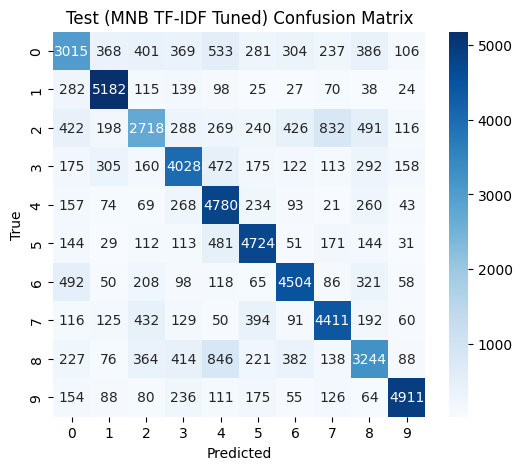

ROC-AUC (per class): {'0': 0.8478132774063717, '1': 0.979974241806947, '2': 0.8697034296931424, '3': 0.9386848166941363, '4': 0.9525203212881158, '5': 0.9613633493212838, '6': 0.963760412229856, '7': 0.9526131332679002, '8': 0.9011407973604451, '9': 0.9774935955604117}
ROC-AUC (macro)   : 0.9345
ROC-AUC (weighted): 0.9345
ROC-AUC (micro)   : 0.9406


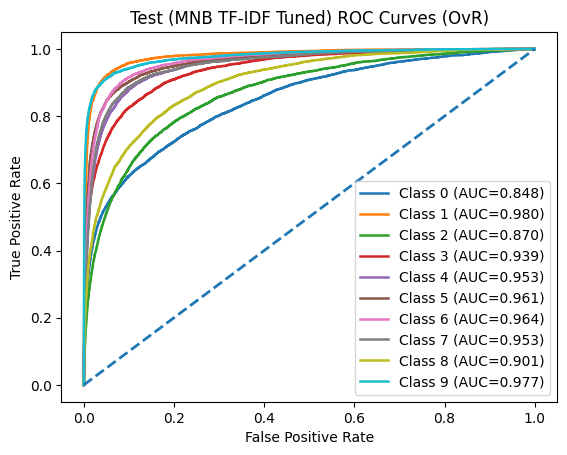

In [ ]:
# Final test
mnb_best.fit(X_train, y_train)
evaluate_model(mnb_best, X_test, y_test, dataset_name="Test (MNB TF-IDF Tuned)")

### Prefit Tf-Idf and BOW

In [ ]:
# Pre-fit TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.95,        #  best baseline
    max_features=50_000 # vocab cap
)

# Fit only on TRAIN
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf   = tfidf_vectorizer.transform(X_val)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (238002, 50000) (42001, 50000) (59999, 50000)


In [ ]:
# Pre-fit BoW vectorizer
bow_vectorizer = CountVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.95,
    max_features=50_000
)

# Fit only on TRAIN
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow   = bow_vectorizer.transform(X_val)
X_test_bow  = bow_vectorizer.transform(X_test)

print("BoW shapes:", X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)

BoW shapes: (238002, 50000) (42001, 50000) (59999, 50000)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD


svd_tfidf = TruncatedSVD(n_components=300, random_state=42)
X_train_tfidf_svd = svd_tfidf.fit_transform(X_train_tfidf)
X_val_tfidf_svd   = svd_tfidf.transform(X_val_tfidf)
X_test_tfidf_svd  = svd_tfidf.transform(X_test_tfidf)
scaler_tfidf = StandardScaler()#logistic regression faster converge, prevents features of large values from dominating the model
X_train_tfidf_svd = scaler_tfidf.fit_transform(X_train_tfidf_svd)
X_val_tfidf_svd   = scaler_tfidf.transform(X_val_tfidf_svd)
X_test_tfidf_svd  = scaler_tfidf.transform(X_test_tfidf_svd)
print("TF-IDF SVD shapes:", X_train_tfidf_svd.shape, X_val_tfidf_svd.shape, X_test_tfidf_svd.shape)


TF-IDF SVD shapes: (238002, 300) (42001, 300) (59999, 300)


In [ ]:


svd_bow = TruncatedSVD(n_components=300, random_state=42)
X_train_bow_svd = svd_bow.fit_transform(X_train_bow)
X_val_bow_svd   = svd_bow.transform(X_val_bow)
X_test_bow_svd  = svd_bow.transform(X_test_bow)

# Standardize dense SVD features (helps DNNs converge) #
scaler_bow = StandardScaler()
X_train_bow_svd = scaler_bow.fit_transform(X_train_bow_svd)
X_val_bow_svd   = scaler_bow.transform(X_val_bow_svd)
X_test_bow_svd  = scaler_bow.transform(X_test_bow_svd)

print("BoW SVD shapes:", X_train_bow_svd.shape, X_val_bow_svd.shape, X_test_bow_svd.shape)

BoW SVD shapes: (238002, 300) (42001, 300) (59999, 300)


### Random Forest


=== Validation (RF TF-IDF fast) Evaluation ===
Accuracy       : 0.5719
F1 (Macro)     : 0.5644
F1 (Weighted)  : 0.5644

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.36      0.45      4193
           1       0.67      0.82      0.74      4197
           2       0.52      0.26      0.35      4196
           3       0.59      0.47      0.53      4240
           4       0.54      0.74      0.62      4186
           5       0.66      0.65      0.65      4228
           6       0.65      0.65      0.65      4162
           7       0.36      0.68      0.47      4206
           8       0.61      0.40      0.49      4182
           9       0.73      0.68      0.71      4211

    accuracy                           0.57     42001
   macro avg       0.59      0.57      0.56     42001
weighted avg       0.59      0.57      0.56     42001



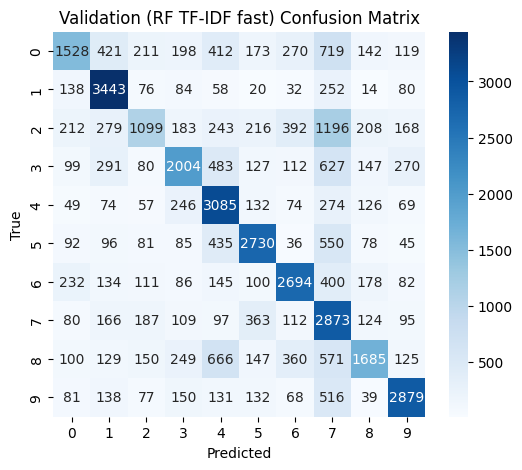

ROC-AUC (per class): {'0': 0.8128496427756435, '1': 0.9569735205704797, '2': 0.806968786062743, '3': 0.8685250280687922, '4': 0.9119903275931767, '5': 0.9121955362689047, '6': 0.9191955911893024, '7': 0.8943572915099898, '8': 0.8373069565196829, '9': 0.9172890322596051}
ROC-AUC (macro)   : 0.8838
ROC-AUC (weighted): 0.8838
ROC-AUC (micro)   : 0.8851


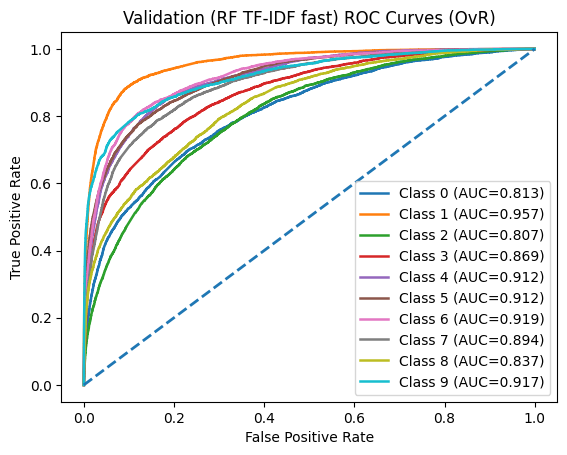

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_tfidf_fast = RandomForestClassifier(
    n_estimators=100,      # ↓ trees
    max_depth=20,         # limit depth
    min_samples_leaf=2,   # regularize #prevent overfitting
    max_features="sqrt",  # sqrt randomly selects a subset of features at each split to speed up training and reduce correlation between trees.”
    n_jobs=-1,
    random_state=42
)
rf_tfidf_fast.fit(X_train_tfidf, y_train)

evaluate_model(rf_tfidf_fast, X_val_tfidf, y_val, dataset_name="Validation (RF TF-IDF fast)")



=== Validation (RF on TF-IDF SVD-300) Evaluation ===
Accuracy       : 0.5919
F1 (Macro)     : 0.5871
F1 (Weighted)  : 0.5871

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.42      0.46      4193
           1       0.69      0.80      0.74      4197
           2       0.46      0.39      0.42      4196
           3       0.54      0.53      0.54      4240
           4       0.57      0.74      0.64      4186
           5       0.63      0.68      0.66      4228
           6       0.63      0.62      0.62      4162
           7       0.59      0.63      0.61      4206
           8       0.51      0.45      0.48      4182
           9       0.74      0.66      0.70      4211

    accuracy                           0.59     42001
   macro avg       0.59      0.59      0.59     42001
weighted avg       0.59      0.59      0.59     42001



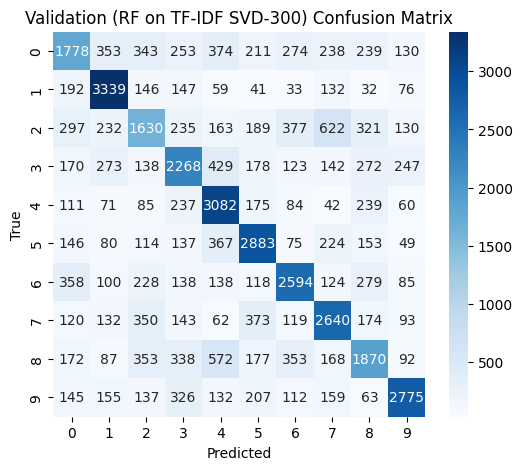

ROC-AUC (per class): {'0': 0.8114115836159232, '1': 0.9609430154107134, '2': 0.8249454957322641, '3': 0.880349087957876, '4': 0.9302514966019787, '5': 0.925670121828447, '6': 0.9158975217073061, '7': 0.908295638111274, '8': 0.8506369771119906, '9': 0.9249062313580487}
ROC-AUC (macro)   : 0.8933
ROC-AUC (weighted): 0.8934
ROC-AUC (micro)   : 0.8999


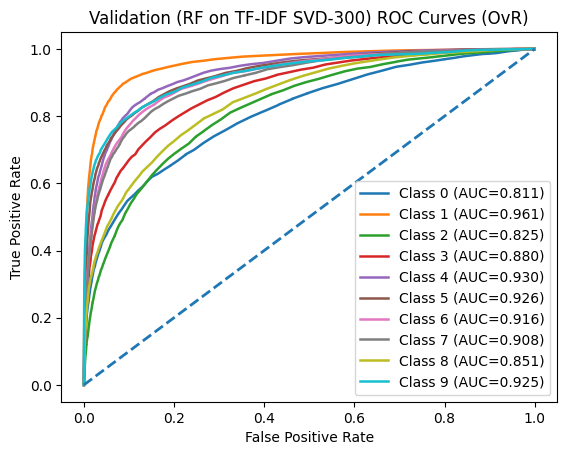

In [ ]:
# 3) RF on compact features
# Random Forest on reduced dense features
rf_svd = RandomForestClassifier(
    n_estimators=300,        # number of trees
    max_depth=None,          # let trees grow deep (try 20/50 for faster runs)
    min_samples_leaf=1,      # allow pure leaves
    max_features="sqrt",     # feature subsampling per split
    n_jobs=-1,               # use all cores
    random_state=42
)

# Train
rf_svd.fit(X_train_tfidf_svd, y_train)

# Validation
evaluate_model(rf_svd, X_val_tfidf_svd, y_val, dataset_name="Validation (RF on TF-IDF SVD-300)")


**Why the score is low**

Random Forests don’t like sparse/high-dimensional text data.
Even after SVD reduction, you still have 238k samples × 300 features → trees struggle to find informative splits compared to linear models.

SVD summarizes the text like a photo with fewer pixels—good for overall shape but may lose small details that help tell classes apart.”


=== Validation (RF TF-IDF fast) Evaluation ===
Accuracy       : 0.5732
F1 (Macro)     : 0.5659
F1 (Weighted)  : 0.5659

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.37      0.45      4193
           1       0.66      0.82      0.73      4197
           2       0.53      0.27      0.36      4196
           3       0.55      0.48      0.51      4240
           4       0.56      0.73      0.63      4186
           5       0.66      0.65      0.66      4228
           6       0.64      0.65      0.64      4162
           7       0.37      0.69      0.48      4206
           8       0.63      0.40      0.49      4182
           9       0.74      0.68      0.71      4211

    accuracy                           0.57     42001
   macro avg       0.59      0.57      0.57     42001
weighted avg       0.59      0.57      0.57     42001



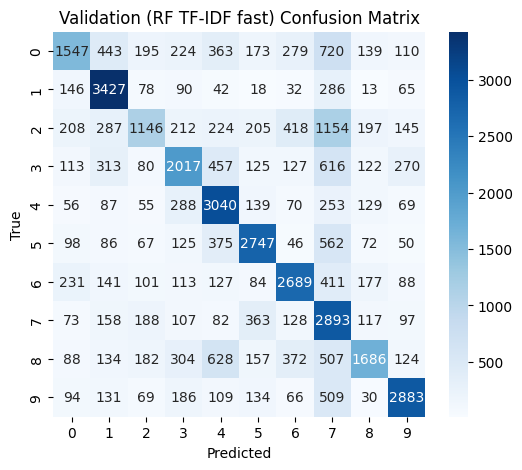

ROC-AUC (per class): {'0': 0.8124282780815091, '1': 0.9558296271853214, '2': 0.8131851030745929, '3': 0.8640435930702187, '4': 0.9140451170511706, '5': 0.9134873021909173, '6': 0.9173505913081067, '7': 0.8959218327316629, '8': 0.8410962557705673, '9': 0.9181004443496535}
ROC-AUC (macro)   : 0.8845
ROC-AUC (weighted): 0.8846
ROC-AUC (micro)   : 0.8846


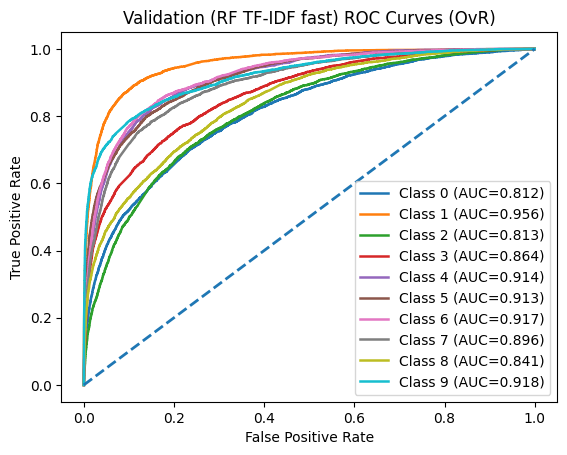

In [ ]:
#Random Forest with Bag Of Words

rf_bow_fast = RandomForestClassifier(
    n_estimators=100,      # ↓ trees
    max_depth=20,         # limit depth
    min_samples_leaf=2,   # regularize
    max_features="sqrt",  # feature subsampling
    n_jobs=-1,
    random_state=42
)
rf_bow_fast.fit(X_train_bow, y_train)

evaluate_model(rf_bow_fast, X_val_bow, y_val, dataset_name="Validation (RF TF-IDF fast)")

ROC-AUC high → model is good at ranking the right class higher than the wrong ones

“ROC-AUC is high because the model ranks classes well, but accuracy is lower because converting those probabilities into exact labels still causes many misclassifications.”


=== Test (RF on TF-IDF SVD-300) Evaluation ===
Accuracy       : 0.5941
F1 (Macro)     : 0.5895
F1 (Weighted)  : 0.5895

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.42      0.47      6000
           1       0.69      0.79      0.74      6000
           2       0.47      0.40      0.43      6000
           3       0.53      0.53      0.53      6000
           4       0.57      0.73      0.64      5999
           5       0.62      0.68      0.65      6000
           6       0.64      0.63      0.63      6000
           7       0.60      0.64      0.62      6000
           8       0.53      0.45      0.49      6000
           9       0.75      0.67      0.70      6000

    accuracy                           0.59     59999
   macro avg       0.59      0.59      0.59     59999
weighted avg       0.59      0.59      0.59     59999



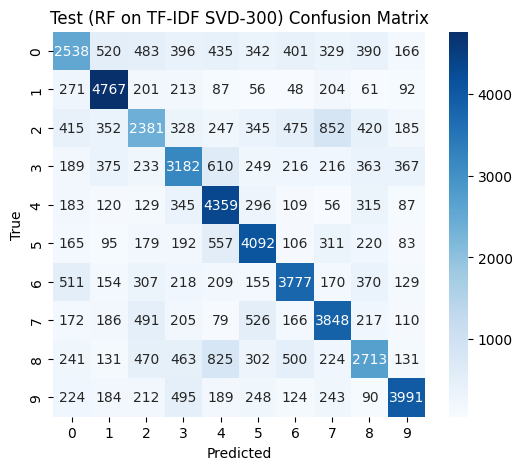

ROC-AUC (per class): {'0': 0.8065867408038422, '1': 0.9594733529015969, '2': 0.8213637829712895, '3': 0.8773219658388735, '4': 0.9261884851178901, '5': 0.9200610551429964, '6': 0.9158259227022724, '7': 0.9120187364580826, '8': 0.8529528031383297, '9': 0.9294507984715765}
ROC-AUC (macro)   : 0.8921
ROC-AUC (weighted): 0.8921
ROC-AUC (micro)   : 0.8990


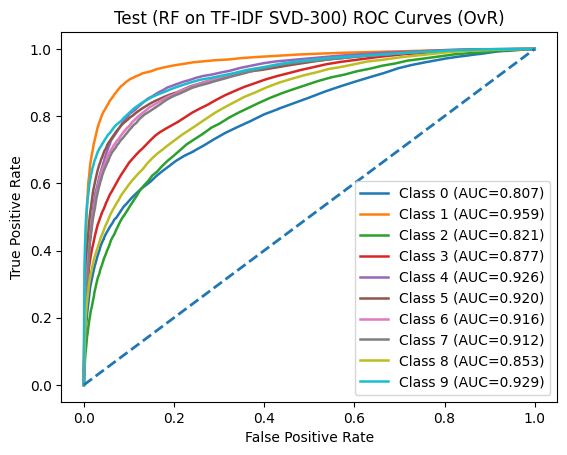

In [ ]:
# Final Test Evaluation for RF on TF-IDF SVD-300 (Best Model)
evaluate_model(
    rf_svd,                # the trained model from validation step
    X_test_tfidf_svd,      # test features (SVD reduced)
    y_test,                # true labels
    dataset_name="Test (RF on TF-IDF SVD-300)"
)


#  Wrap-Up: Traditional ML Models (BoW & TF-IDF)

We evaluated Logistic Regression (LR), Multinomial Naive Bayes (MNB), and Random Forest (RF) on BoW/TF-IDF
variants and reported validation/test metrics where available. Below summarizes the **best observed runs** from the notebook.

| Model & Representation                | Validation Accuracy | Validation Macro-F1 | Test Accuracy | Test Macro-F1 | Notes |
|---|---:|---:|---:|---:|---|
| **Logistic Regression + TF-IDF (tuned)** | **0.7017** | **0.6993** | **0.7030** | **0.7007** | Strongest ML baseline overall. |
| Logistic Regression + **BoW** (baseline) | 0.6649 | 0.6645 | – | – | TF-IDF > BoW for LR on this dataset. |
| **MNB + TF-IDF (α=0.5, tuned)**         | 0.6925 | 0.6880 | 0.6920 | 0.6879 | Competitive, very fast to train. |
| MNB + **BoW** (baseline)                 | 0.6856 | 0.6819 | – | – | Slightly behind TF-IDF. |
| **RF + TF-IDF → SVD-300**                | 0.5919 | 0.5871 | 0.5941 | 0.5895 | Tree ensembles underperform on sparse text features. |
| RF + TF-IDF (fast baseline)              | 0.5719 | 0.5644 | – | – | Consistent with above. |

**Key takeaways**
- **TF-IDF consistently beats BoW** for LR and MNB by down-weighting ubiquitous words and highlighting informative terms.
- **Logistic Regression + TF-IDF** is the **best classical baseline** (≈0.70 acc / macro-F1 on val and test).
- **MNB + TF-IDF** is a close, lightweight alternative (≈0.69 acc), great as a fast baseline.
- **Random Forest** lags notably on this task, even after SVD compression, which aligns with the known difficulty of tree models on high-dimensional sparse text.

**Implications for the next stage**
- Keep **LR + TF-IDF** as the reference baseline when you compare with Neural Networks.
- Since ML plateaus around ~0.70, moving to **DNN/RNN/GRU/LSTM** with richer representations (e.g., **TF-IDF→SVD-768**, **GloVe**, **Skip-gram**) is justified to capture deeper semantics beyond linear decision boundaries.



# Neural Network Evaluation Utilities

General Functions we will be using to evaluate Neural Network Models

In [ ]:
# --- Plotting: loss and accuracy curves ---
import matplotlib.pyplot as plt

def plot_loss(history, title="Loss (train vs val)"):
    h = history.history
    plt.figure(figsize=(6,4))
    plt.plot(h["loss"], label="loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.legend(); plt.grid(True); plt.show()

def plot_acc(history, title="Accuracy (train vs val)"):
    h = history.history
    acc_key = "accuracy" if "accuracy" in h else "sparse_categorical_accuracy"
    val_acc_key = "val_accuracy" if "val_accuracy" in h else "val_sparse_categorical_accuracy"
    plt.figure(figsize=(6,4))
    plt.plot(h[acc_key], label="accuracy")
    if val_acc_key in h: plt.plot(h[val_acc_key], label="val_accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title)
    plt.legend(); plt.grid(True); plt.show()


In [ ]:
# --- Eval: metrics + multi-class ROC with macro-average AUC ---
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

def plot_multiclass_roc_macro(y_true, y_proba, title="ROC (macro-average)"):
    """
    y_true: shape (N,), integer labels 0..C-1
    y_proba: shape (N, C), softmax probabilities from the model
    Plots per-class ROC (faint) and the macro-average ROC (bold).
    Prints per-class AUCs and the macro-average AUC.
    """
    n_classes = y_proba.shape[1]
    y_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Per-class ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC: average TPR at all unique FPR points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot
    plt.figure(figsize=(6,5))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1, alpha=0.2)  # faint per-class
    plt.plot(all_fpr, mean_tpr, lw=2.5, label=f"Macro-average ROC (AUC = {macro_auc:.3f})")
    plt.plot([0,1], [0,1], "k--", lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(loc="lower right"); plt.grid(True); plt.show()

    # Also print the numbers (optional but helpful for report tables)
    print("Per-class AUCs:")
    for i in range(n_classes):
        print(f"  Class {i}: AUC = {roc_auc[i]:.4f}")
    print(f"Macro-average AUC: {macro_auc:.4f}")
    return macro_auc, roc_auc

def evaluation_set(model, X, y, name="Set"):
    """
    Evaluates a trained model on given data.
    Prints Accuracy, Macro-F1, Classification Report,
    plots ROC + Macro-AUC (via your helper), AND adds a Confusion Matrix.
    """
    # Predictions
    y_pred = model.predict(X, verbose=0).argmax(axis=1)
    acc = accuracy_score(y, y_pred)
    f1m = f1_score(y, y_pred, average="macro")
    print(f"{name} Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}")
    print(classification_report(y, y_pred, digits=4))

    # ROC/AUC (if you want to keep that helper)
    y_proba = model.predict(X, verbose=0)
    macro_auc = plot_multiclass_roc_macro(y, y_proba, title=f"{name} ROC (macro-average)")

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {"acc": acc, "f1_macro": f1m, "macro_auc": macro_auc, "confusion_matrix": cm}


# Deep Neural Network With BOW and Tf-Idf

In [ ]:
# --- build_dnn: small, stable MLP for SVD-300 ---
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_dnn(input_dim, num_classes):
    model = keras.Sequential([  #sequential stack layers, passes data layer by layer
        layers.Input(shape=(input_dim,)), #num of input features
        layers.Dense(512, activation="relu"), #First hidden layer with 512 neurons.,
        #Activation = ReLU, which helps learning by avoiding vanishing gradients.
        layers.Dropout(0.35),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.35),  #Helps prevent overfitting and improves generalization.
        layers.Dense(num_classes, activation="softmax")
    ])

    return model


In [ ]:
# --- train_model: compiles, trains once, returns (model, history) ---
def train_model(Xtr, ytr, Xval, yval, lr=1e-3, epochs=25, batch_size=1024): #We divide into batches to save memory, speed up training, and get stable gradient updates while keeping some randomness to help generalization.
    num_classes = int(np.max(ytr)) + 1
    model = build_dnn(Xtr.shape[1], num_classes)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr), #Adam is used because it adapts learning rates per weight, accelerates training with momentum, handles sparse data well, and is stable with minimal tuning.
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    callbacks = [
        # EarlyStopping: stop when val_loss doesn't improve; restore best weights
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_loss"),
        ## stops training if validation loss doesn’t improve for 4 epochs, restores best weights.
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_loss"),
        #val_loss → the loss calculated on the validation set after each epoch.
        #monitor="val_loss" → tells the callback which metric to track.
        # Reduce LR when progress stalls for stability
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5, monitor="val_loss")
    ]

    history = model.fit(
        Xtr, ytr,
        validation_data=(Xval, yval),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return model, history


### Deep Neural Network with Bag Of Words

Epoch 1/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.3788 - loss: 1.8934 - val_accuracy: 0.6200 - val_loss: 1.2528 - learning_rate: 0.0010
Epoch 2/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.6013 - loss: 1.2746 - val_accuracy: 0.6321 - val_loss: 1.1601 - learning_rate: 0.0010
Epoch 3/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.6242 - loss: 1.1727 - val_accuracy: 0.6389 - val_loss: 1.1272 - learning_rate: 0.0010
Epoch 4/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.6356 - loss: 1.1304 - val_accuracy: 0.6454 - val_loss: 1.1073 - learning_rate: 0.0010
Epoch 5/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.6419 - loss: 1.0982 - val_accuracy: 0.6462 - val_loss: 1.0983 - learning_rate: 0.0010
Epoch 6/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - accuracy: 0.6511 - loss: 1.0704 - val_accuracy: 0.6473 - val_loss: 1.0919 - learning_rate: 0.0010
Epoch 7/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.6561 - l

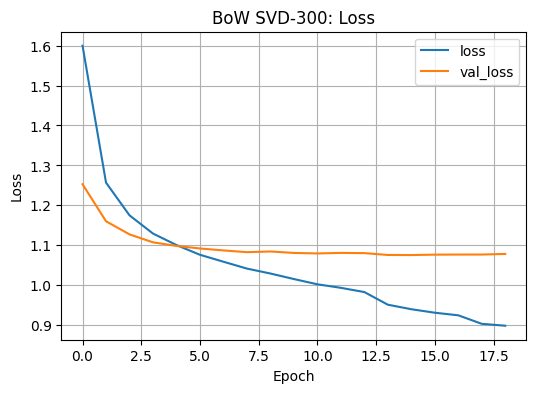

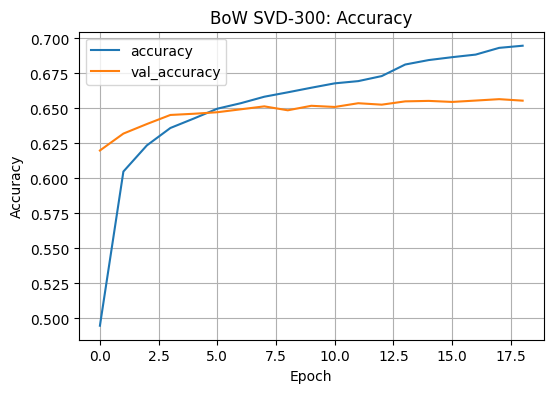

In [ ]:
# --- BoW → SVD-300 → DNN ---
model_bow, hist_bow = train_model(
    X_train_bow_svd, y_train,
    X_val_bow_svd,   y_val,
    lr=1e-3, epochs=25, batch_size=1024
)
plot_loss(hist_bow, "BoW SVD-300: Loss")
plot_acc(hist_bow,  "BoW SVD-300: Accuracy")


Validation (BoW) Accuracy: 0.6554 | Macro-F1: 0.6487
              precision    recall  f1-score   support

           0     0.6006    0.4171    0.4923      4193
           1     0.7625    0.8506    0.8041      4197
           2     0.5390    0.4163    0.4698      4196
           3     0.5945    0.6083    0.6013      4240
           4     0.6425    0.7525    0.6931      4186
           5     0.7140    0.7559    0.7344      4228
           6     0.6826    0.7504    0.7149      4162
           7     0.6375    0.7161    0.6745      4206
           8     0.5502    0.5215    0.5355      4182
           9     0.7697    0.7649    0.7673      4211

    accuracy                         0.6554     42001
   macro avg     0.6493    0.6554    0.6487     42001
weighted avg     0.6494    0.6554    0.6488     42001



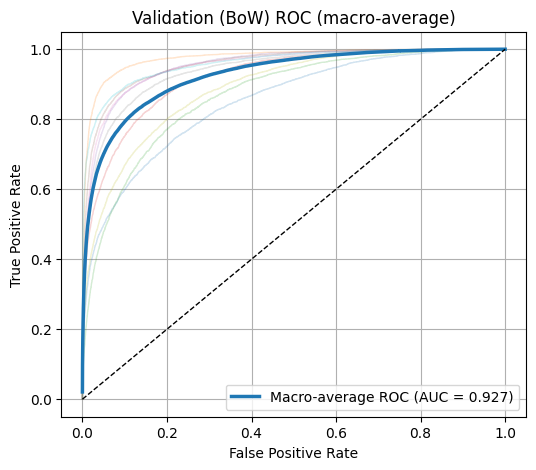

Per-class AUCs:
  Class 0: AUC = 0.8504
  Class 1: AUC = 0.9760
  Class 2: AUC = 0.8684
  Class 3: AUC = 0.9196
  Class 4: AUC = 0.9530
  Class 5: AUC = 0.9577
  Class 6: AUC = 0.9528
  Class 7: AUC = 0.9400
  Class 8: AUC = 0.8886
  Class 9: AUC = 0.9601
Macro-average AUC: 0.9267


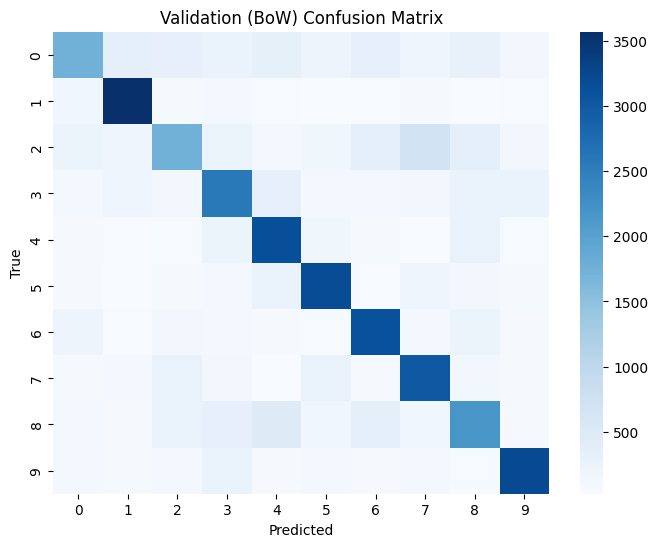

In [ ]:
val_bow  = evaluation_set(model_bow, X_val_bow_svd,  y_val,  "Validation (BoW)")

key Observations

    Strong Diagonal: Most of the values are concentrated along the diagonal, indicating the model predicts the correct class for the majority of samples in each true class.

Lighter Off-diagonal Cells: Few misclassifications occur (off-diagonal cells are paler), so the overall accuracy is likely high.

Class Imbalance: Some diagonal cells are much darker than others, suggesting some classes have more samples, or the model performs better on certain classes.
Color Bar

**Try Again with higher svd dimension,one more layer, slightly less dropout rate and smaller batch size**

In [ ]:
svd_bow = TruncatedSVD(n_components=512, random_state=42)
X_train_bow_svd = svd_bow.fit_transform(X_train_bow)
X_val_bow_svd   = svd_bow.transform(X_val_bow)
X_test_bow_svd  = svd_bow.transform(X_test_bow)

# Standardize dense SVD features (helps DNNs converge)
scaler_bow = StandardScaler()
X_train_bow_svd = scaler_bow.fit_transform(X_train_bow_svd)
X_val_bow_svd   = scaler_bow.transform(X_val_bow_svd)
X_test_bow_svd  = scaler_bow.transform(X_test_bow_svd)

print("BoW SVD shapes:", X_train_bow_svd.shape, X_val_bow_svd.shape, X_test_bow_svd.shape)

BoW SVD shapes: (238002, 512) (42001, 512) (59999, 512)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_dnn(input_dim, num_classes):
    return keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(768, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.30),

        layers.Dense(384, activation="relu", kernel_regularizer=regularizers.l2(1e-5)), #prevents overfitting
        layers.BatchNormalization(),
        layers.Dropout(0.30),

        layers.Dense(192, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.25),

        layers.Dense(num_classes, activation="softmax")
    ])


In [ ]:
model_bow2, hist_bow2 = train_model(X_train_bow_svd, y_train, X_val_bow_svd , y_val, lr=1e-3, epochs=25, batch_size=512)

Epoch 1/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 44s 90ms/step - accuracy: 0.4244 - loss: 1.8022 - val_accuracy: 0.6286 - val_loss: 1.1682 - learning_rate: 0.0010
Epoch 2/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 80s 85ms/step - accuracy: 0.6204 - loss: 1.1946 - val_accuracy: 0.6401 - val_loss: 1.1257 - learning_rate: 0.0010
Epoch 3/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.6396 - loss: 1.1279 - val_accuracy: 0.6432 - val_loss: 1.1149 - learning_rate: 0.0010
Epoch 4/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.6503 - loss: 1.0893 - val_accuracy: 0.6464 - val_loss: 1.1087 - learning_rate: 0.0010
Epoch 5/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.6560 - loss: 1.0688 - val_accuracy: 0.6468 - val_loss: 1.1064 - learning_rate: 0.0010
Epoch 6/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.6655 - loss: 1.0413 - val_accuracy: 0.6500 - val_loss: 1.1058 - learning_rate: 0.0010
Epoch 7/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.6692 - l

In [ ]:
model_bow2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 768)            │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 384)            │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 192)            │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,304,608 (8.79 MB)

 Trainable params: 767,434 (2.93 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 1,534,870 (5.86 MB)

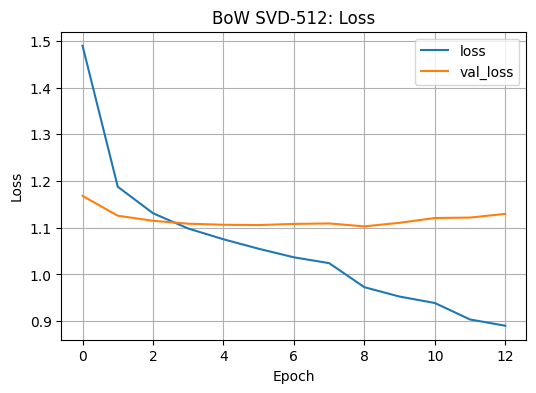

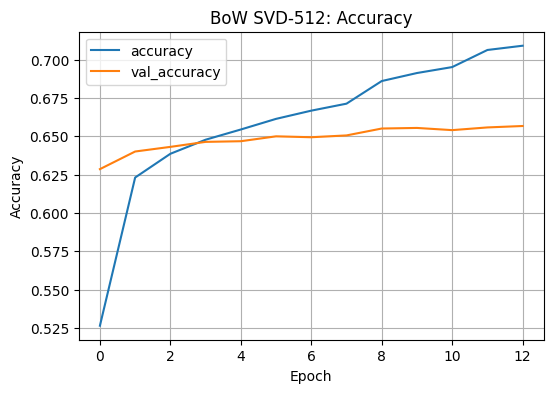

In [ ]:
plot_loss(hist_bow2, "BoW SVD-512: Loss")
plot_acc(hist_bow2,  "BoW SVD-512: Accuracy")


Validation (BoW) Accuracy: 0.6551 | Macro-F1: 0.6494
              precision    recall  f1-score   support

           0     0.5839    0.4441    0.5045      4193
           1     0.7644    0.8427    0.8017      4197
           2     0.5204    0.4254    0.4681      4196
           3     0.5852    0.6259    0.6049      4240
           4     0.6367    0.7520    0.6896      4186
           5     0.7208    0.7540    0.7370      4228
           6     0.6891    0.7482    0.7174      4162
           7     0.6439    0.7071    0.6740      4206
           8     0.5772    0.4959    0.5335      4182
           9     0.7715    0.7552    0.7632      4211

    accuracy                         0.6551     42001
   macro avg     0.6493    0.6551    0.6494     42001
weighted avg     0.6493    0.6551    0.6495     42001



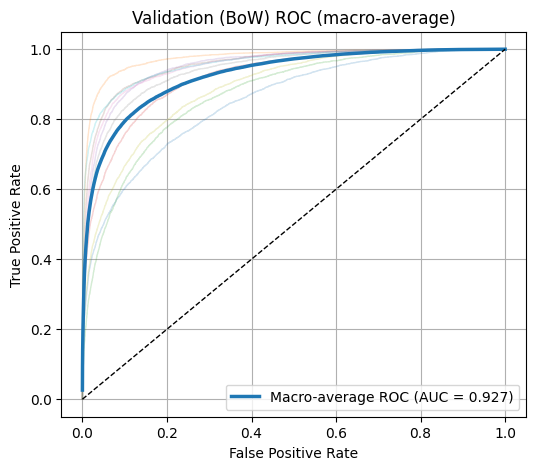

Per-class AUCs:
  Class 0: AUC = 0.8517
  Class 1: AUC = 0.9754
  Class 2: AUC = 0.8700
  Class 3: AUC = 0.9201
  Class 4: AUC = 0.9526
  Class 5: AUC = 0.9572
  Class 6: AUC = 0.9527
  Class 7: AUC = 0.9403
  Class 8: AUC = 0.8883
  Class 9: AUC = 0.9589
Macro-average AUC: 0.9267


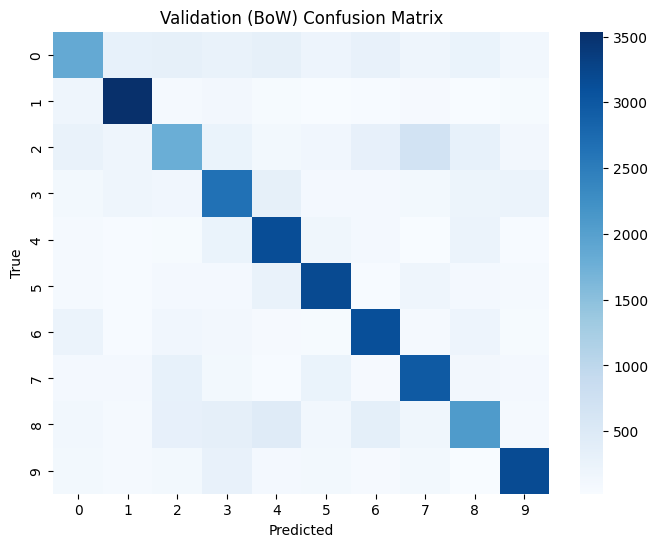

In [ ]:
val_bow  = evaluation_set(model_bow2, X_val_bow_svd,  y_val,  "Validation (BoW)")

**Bag of Words (BoW) Conclusion**

From our experiments with BoW + SVD (300–512 dimensions) and Deep Neural Network:
- Validation accuracy plateaued around **65%** with a macro-F1 of ~0.64–0.65.
- Increasing SVD dimensionality from 300 → 512 gave only a modest improvement.
- ROC-AUC values were strong (>0.92 macro average), meaning the model is learning useful decision boundaries,
  but the discrete classification accuracy is capped.

**Limitations of BoW:**
- BoW counts all terms equally, so very common words (like stopwords) dominate the vector space.
- It ignores term importance across documents, which reduces discriminative power between classes.
- Even with SVD compression, the information retained is not rich enough to push validation accuracy higher.

---

**Reason to Move to TF-IDF with Higher Dimensional Vector**

To overcome these limitations, we now switch to **TF-IDF** representation:
- TF-IDF downweights extremely frequent words and highlights rare but informative terms.
- This often results in **sharper class separation** compared to raw BoW counts.
- To avoid under-compressing, we increase SVD dimensionality (e.g., **768**) so that more variance
  from the TF-IDF space is preserved for the DNN.
- Batch size is also reduced slightly to encourage better generalization.

 Next, we apply **TF-IDF → SVD-768 → Deep Neural Network** and compare the performance
against our BoW baseline.


### Deep Neural Network with Tf-Idf

In [ ]:
# --- TF-IDF → SVD-768 + Standardization ---
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

svd_tfidf_768 = TruncatedSVD(n_components=768, random_state=42)
X_train_tfidf_svd768 = svd_tfidf_768.fit_transform(X_train_tfidf)
X_val_tfidf_svd768   = svd_tfidf_768.transform(X_val_tfidf)
X_test_tfidf_svd768  = svd_tfidf_768.transform(X_test_tfidf)

scaler_tfidf_768 = StandardScaler()
X_train_tfidf_svd768 = scaler_tfidf_768.fit_transform(X_train_tfidf_svd768)
X_val_tfidf_svd768   = scaler_tfidf_768.transform(X_val_tfidf_svd768)
X_test_tfidf_svd768  = scaler_tfidf_768.transform(X_test_tfidf_svd768)

print("TF-IDF SVD-768 shapes:",
      X_train_tfidf_svd768.shape, X_val_tfidf_svd768.shape, X_test_tfidf_svd768.shape)

TF-IDF SVD-768 shapes: (238002, 768) (42001, 768) (59999, 768)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_dnn(input_dim, num_classes):
    return keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(768, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.30),

        layers.Dense(384, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.30),

        layers.Dense(192, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.25),

        layers.Dense(num_classes, activation="softmax")
    ])


In [ ]:
# --- train_model: compiles, trains once, returns (model, history) ---
def train_model(Xtr, ytr, Xval, yval, lr=1e-3, epochs=25, batch_size=1024):
    num_classes = int(np.max(ytr)) + 1
    model = build_dnn(Xtr.shape[1], num_classes)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    callbacks = [
        # EarlyStopping: stop when val_loss doesn't improve; restore best weights
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_loss"),
        # Reduce LR when progress stalls for stability
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5, monitor="val_loss")
    ]

    history = model.fit(
        Xtr, ytr,
        validation_data=(Xval, yval),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

In [ ]:
# --- Train  ---
## Using the three layers build_dnn function

model_tfidf_768, hist_tfidf_768 = train_model(
    X_train_tfidf_svd768, y_train,
    X_val_tfidf_svd768,   y_val,
    # keep lr/epochs the same as current config
    lr=1e-3, epochs=25, batch_size=512
)


Epoch 1/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.4735 - loss: 1.6944 - val_accuracy: 0.6615 - val_loss: 1.0740 - learning_rate: 0.0010
Epoch 2/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.6605 - loss: 1.0769 - val_accuracy: 0.6686 - val_loss: 1.0442 - learning_rate: 0.0010
Epoch 3/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.6811 - loss: 1.0024 - val_accuracy: 0.6728 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 4/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.6911 - loss: 0.9666 - val_accuracy: 0.6728 - val_loss: 1.0365 - learning_rate: 0.0010
Epoch 5/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.6994 - loss: 0.9341 - val_accuracy: 0.6721 - val_loss: 1.0441 - learning_rate: 0.0010
Epoch 6/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.7138 - loss: 0.8867 - val_accuracy: 0.6762 - val_loss: 1.0437 - learning_rate: 5.0000e-04
Epoch 7/25
465/465 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.7272

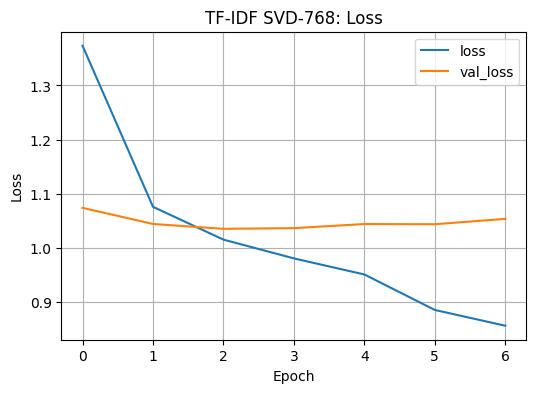

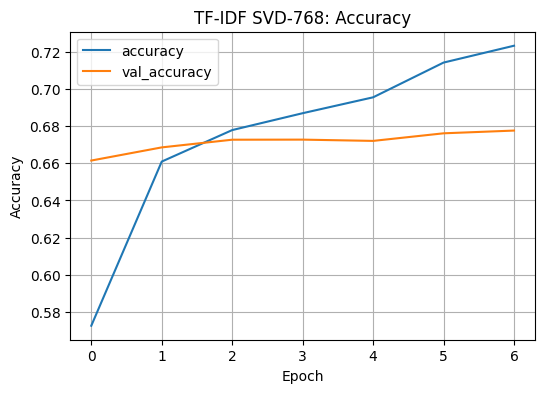

In [ ]:
# --- Curves ---
plot_loss(hist_tfidf_768, "TF-IDF SVD-768: Loss")
plot_acc(hist_tfidf_768,  "TF-IDF SVD-768: Accuracy")

In [ ]:
model_tfidf_768.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 384)            │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 192)            │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,894,432 (11.04 MB)

 Trainable params: 964,042 (3.68 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 1,928,086 (7.36 MB)

Validation (TF-IDF, SVD-768) Accuracy: 0.6728 | Macro-F1: 0.6662
              precision    recall  f1-score   support

           0     0.6051    0.4400    0.5095      4193
           1     0.7880    0.8513    0.8185      4197
           2     0.5432    0.4421    0.4875      4196
           3     0.6277    0.6545    0.6408      4240
           4     0.6426    0.7754    0.7028      4186
           5     0.7135    0.7805    0.7455      4228
           6     0.7006    0.7662    0.7319      4162
           7     0.6376    0.7297    0.6806      4206
           8     0.6015    0.4912    0.5407      4182
           9     0.8122    0.7958    0.8039      4211

    accuracy                         0.6728     42001
   macro avg     0.6672    0.6727    0.6662     42001
weighted avg     0.6673    0.6728    0.6663     42001



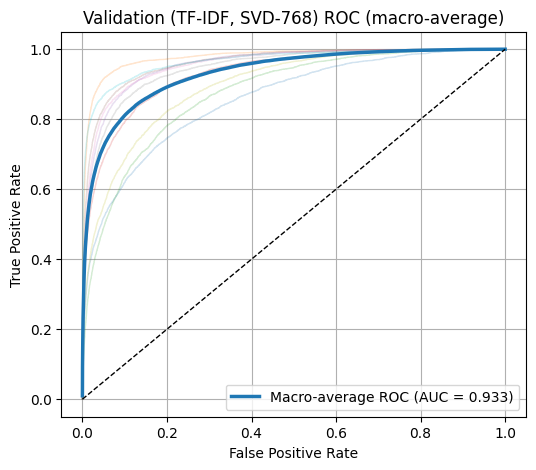

Per-class AUCs:
  Class 0: AUC = 0.8573
  Class 1: AUC = 0.9783
  Class 2: AUC = 0.8751
  Class 3: AUC = 0.9297
  Class 4: AUC = 0.9569
  Class 5: AUC = 0.9623
  Class 6: AUC = 0.9577
  Class 7: AUC = 0.9463
  Class 8: AUC = 0.8966
  Class 9: AUC = 0.9671
Macro-average AUC: 0.9327


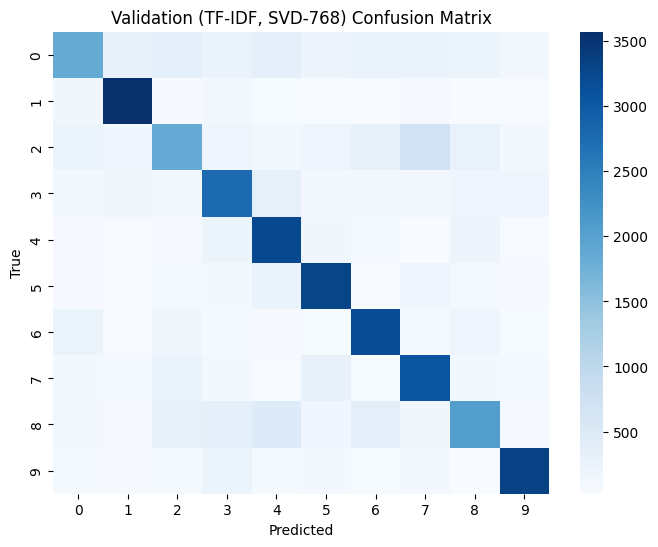

In [ ]:
val_tfidf_768  = evaluation_set(model_tfidf_768, X_val_tfidf_svd768,  y_val,  "Validation (TF-IDF, SVD-768)")

**DNN on TF-IDF: What we changed & why**

- **Representation**: Keep TF-IDF same
- **Network**: `build_dnn` now uses **GELU activations + BatchNorm + L2** with slightly lower dropout → more capacity, still regularized.
- **Optimization**: **AdamW** (weight decay)  for stabler multi-class training.
- **Generalization**: **Batch size = 256** (adds useful gradient noise vs 512/1024).
- **Fairness for hard classes (0,2,8)**: **class weights** based on training distribution → usually improves macro-F1.

We keep EarlyStopping + ReduceLROnPlateau. Train once, then reuse the model for plots & ROC/AUC.


In [ ]:
# build_dnn: GELU + BN + L2 + Dropout
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_dnn(input_dim, num_classes):
    return keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1024, activation="gelu",
                     kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.28),

        layers.Dense(512, activation="gelu",
                     kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.28),

        layers.Dense(256, activation="gelu",
                     kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.22),

        layers.Dense(num_classes, activation="softmax")
    ])


In [ ]:
# train_model

from tensorflow import keras

def train_model(
    Xtr, ytr, Xval, yval,
    lr=1e-3, epochs=30, batch_size=256,
    class_weight=None, use_adamw=True, weight_decay=1e-4
):

    num_classes = int(np.max(ytr)) + 1
    model = build_dnn(Xtr.shape[1], num_classes)

    # Optimizer
    if use_adamw and hasattr(keras.optimizers, "AdamW"):
        optimizer = keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=lr)

    # Loss (sparse, no smoothing)
    loss = keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ]

    history = model.fit(
        Xtr, ytr,
        validation_data=(Xval, yval),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
        class_weight=class_weight
    )
    return model, history



In [ ]:
# --- Class weights (helps weak/rarer classes) ---
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
class_weight


{0: 1.0016919191919191,
 1: 1.0007232056510953,
 2: 1.0010178331090176,
 3: 0.9905606193032838,
 4: 1.0034234158269741,
 5: 0.9934134735787629,
 6: 1.0091672320217095,
 7: 0.998623756975622,
 8: 1.004270222372252,
 9: 0.9973683107740016}

In [ ]:
# --- Train on TF-IDF SVD (SVD_DIM = 768 ) ---
model_tfidf_svd, hist_tfidf_svd = train_model(
    X_train_tfidf_svd768, y_train,
    X_val_tfidf_svd768,   y_val,
    lr=1e-3, epochs=30, batch_size=256,
    class_weight=class_weight
)


Epoch 1/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 103s 107ms/step - accuracy: 0.5343 - loss: 1.5051 - val_accuracy: 0.6624 - val_loss: 1.0699 - learning_rate: 0.0010
Epoch 2/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 93s 100ms/step - accuracy: 0.6725 - loss: 1.0383 - val_accuracy: 0.6684 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 3/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 148s 107ms/step - accuracy: 0.6885 - loss: 0.9832 - val_accuracy: 0.6693 - val_loss: 1.0639 - learning_rate: 0.0010
Epoch 4/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 141s 106ms/step - accuracy: 0.7018 - loss: 0.9418 - val_accuracy: 0.6704 - val_loss: 1.0769 - learning_rate: 0.0010
Epoch 5/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 143s 107ms/step - accuracy: 0.7277 - loss: 0.8568 - val_accuracy: 0.6761 - val_loss: 1.0784 - learning_rate: 5.0000e-04
Epoch 6/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 143s 109ms/step - accuracy: 0.7457 - loss: 0.7947 - val_accuracy: 0.6757 - val_loss: 1.1140 - learning_rate: 5.0000e-04
Epoch 7/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 102s 109ms/step -

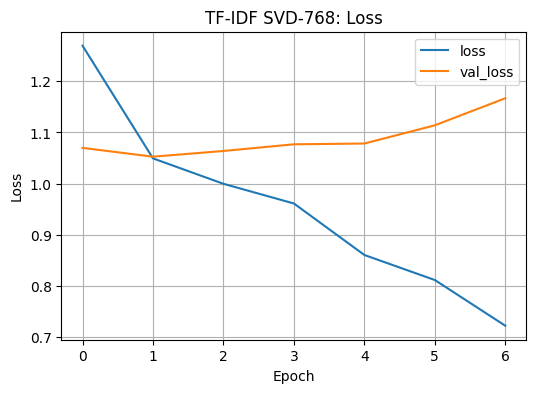

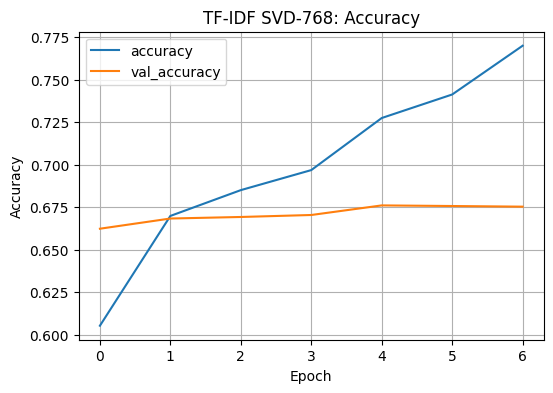

In [ ]:
# --- Curves: spot over/underfitting quickly ---
plot_loss(hist_tfidf_svd, f"TF-IDF SVD-768: Loss")
plot_acc(hist_tfidf_svd,  f"TF-IDF SVD-768: Accuracy")


Validation (TF-IDF, SVD-768) Accuracy: 0.6684 | Macro-F1: 0.6627
              precision    recall  f1-score   support

           0     0.6094    0.4345    0.5073      4193
           1     0.7579    0.8666    0.8086      4197
           2     0.5491    0.4395    0.4882      4196
           3     0.5958    0.6644    0.6282      4240
           4     0.6597    0.7568    0.7049      4186
           5     0.7168    0.7805    0.7473      4228
           6     0.7132    0.7335    0.7232      4162
           7     0.6517    0.7019    0.6758      4206
           8     0.5563    0.5244    0.5399      4182
           9     0.8283    0.7803    0.8036      4211

    accuracy                         0.6684     42001
   macro avg     0.6638    0.6682    0.6627     42001
weighted avg     0.6638    0.6684    0.6628     42001



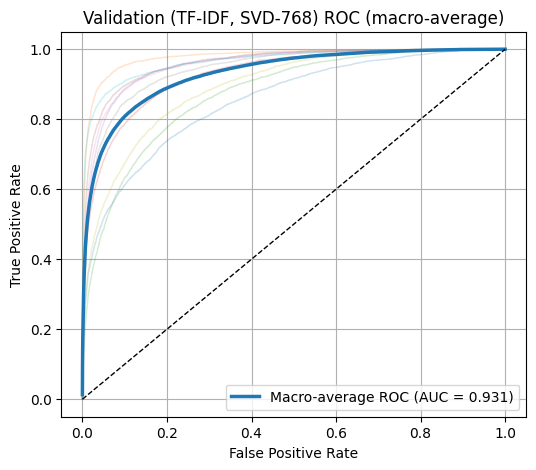

Per-class AUCs:
  Class 0: AUC = 0.8530
  Class 1: AUC = 0.9791
  Class 2: AUC = 0.8730
  Class 3: AUC = 0.9283
  Class 4: AUC = 0.9563
  Class 5: AUC = 0.9614
  Class 6: AUC = 0.9566
  Class 7: AUC = 0.9444
  Class 8: AUC = 0.8931
  Class 9: AUC = 0.9659
Macro-average AUC: 0.9311


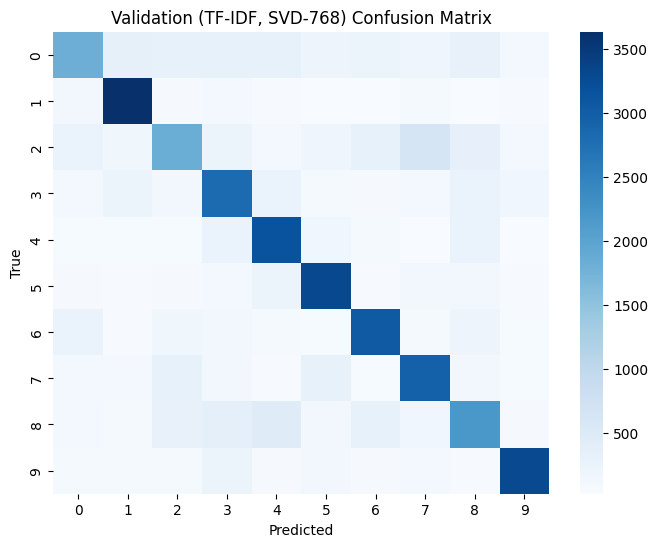

In [ ]:
# --- Validation & Test metrics + ROC/AUC (macro) ---
val_tfidf_svd = evaluation_set(
    model_tfidf_svd,
    X_val_tfidf_svd768,
    y_val,
    name="Validation (TF-IDF, SVD-768)"
)

**Validation Results: TF-IDF + SVD-768 + DNN**

- **Run 1:** Accuracy = 0.6684, Macro-F1 = 0.6627  
- **Run 2:** Accuracy = 0.6728, Macro-F1 = 0.6662  

The second configuration performed slightly better (≈ +0.4% accuracy, +0.3% macro-F1).

**Why performance is still modest (~67%)**
- **Class overlap**: Some classes share highly similar vocabulary, leading to confusion (esp. Classes 0, 2, 8).  
- **Dimensional compression**: Even with 768 components, SVD reduces variance compared to full TF-IDF, dropping subtle discriminative signals.  
- **Model capacity**: A simple feedforward DNN on TF-IDF vectors cannot capture word order or context. Sequence models (RNN, GRU, LSTM) are needed for deeper semantics.  
- **Class imbalance**: Despite class weighting, weaker classes still underperform in recall/F1.

**Takeaway**
This setup is a strong **baseline for NN on TF-IDF**, but to push validation accuracy above ~70%, we need:
- Larger SVD rank (1024),  
- More expressive models (RNN, GRU, LSTM, Bi-LSTM),  
- Or pretrained embeddings (GloVe, Skip-gram).


Final Test (TF-IDF, SVD-768) Accuracy: 0.6715 | Macro-F1: 0.6652
              precision    recall  f1-score   support

           0     0.6123    0.4495    0.5184      6000
           1     0.7853    0.8463    0.8147      6000
           2     0.5475    0.4445    0.4907      6000
           3     0.6191    0.6497    0.6340      6000
           4     0.6416    0.7683    0.6992      5999
           5     0.6965    0.7762    0.7342      6000
           6     0.6959    0.7617    0.7273      6000
           7     0.6494    0.7275    0.6862      6000
           8     0.5944    0.4853    0.5344      6000
           9     0.8196    0.8063    0.8129      6000

    accuracy                         0.6715     59999
   macro avg     0.6662    0.6715    0.6652     59999
weighted avg     0.6662    0.6715    0.6652     59999



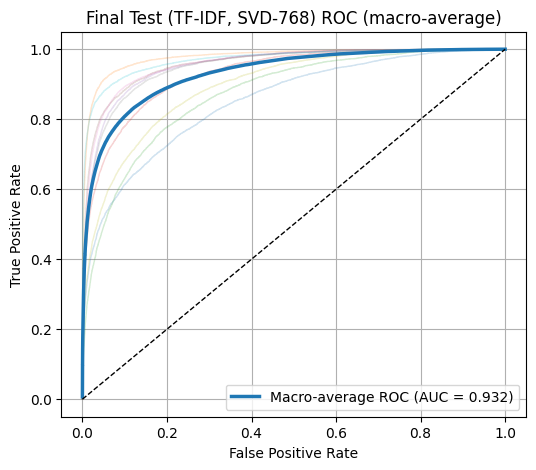

Per-class AUCs:
  Class 0: AUC = 0.8519
  Class 1: AUC = 0.9781
  Class 2: AUC = 0.8723
  Class 3: AUC = 0.9291
  Class 4: AUC = 0.9540
  Class 5: AUC = 0.9592
  Class 6: AUC = 0.9587
  Class 7: AUC = 0.9503
  Class 8: AUC = 0.8947
  Class 9: AUC = 0.9710
Macro-average AUC: 0.9319


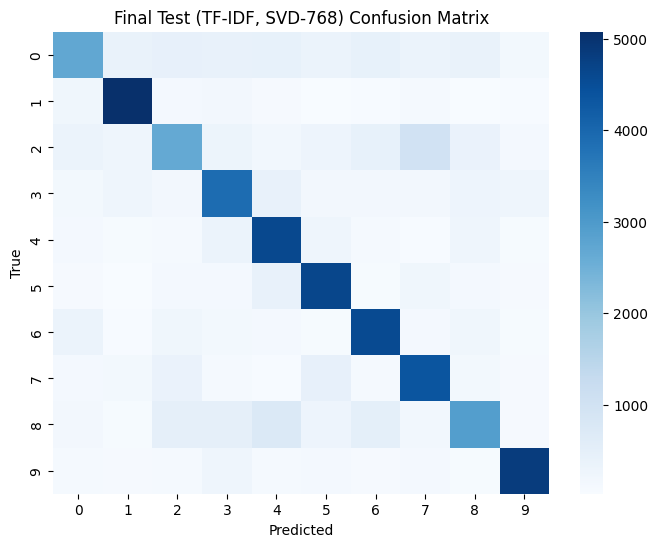

In [ ]:
# --- Final Evaluation on the Test Set (Best Model: TF-IDF + SVD-768 + DNN) ---
test_tfidf_svd768 = evaluation_set(
    model_tfidf_768,          # trained best model
    X_test_tfidf_svd768,      # 768-dim test features
    y_test,
    name="Final Test (TF-IDF, SVD-768)"
)

print("Final Test Results (Best Model)")
print(test_tfidf_svd768)


# Train Skipgram

**Vocabulary Size vs Token Coverage**

In this step, we analyze how many tokens in our training corpus are captured by the most frequent words,
and what minimum document frequency (`min_df`) threshold would yield a vocabulary of a given size
(20k, 30k, 40k, 50k, 60k).

---

**Why are we doing this?**
- Word embedding models such as **Skip-gram** require us to set a fixed vocabulary size.  
- **Too small** → many out-of-vocabulary (OOV) words.  
- **Too large** → higher memory and computation cost with only marginal gains in coverage.  

---

**What we compute**
1. Sort words by their total token frequency.  
2. Measure the percentage of total tokens covered by the top *N* words (N = 20k, 30k, 40k, 50k, 60k).  
3. Compute the largest `min_df` value (minimum document frequency) that still leaves at least *N* words in the vocabulary.  

---

**Interpretation**
- Token coverage grows rapidly for the first ~20k words, then shows **diminishing returns**.  
- `min_df` thresholds help filter rare words while still retaining a sufficiently large vocabulary.  
- Based on this analysis, a cutoff of **≈20k words** is a good trade-off for Skip-gram training.

In [ ]:
project_path = "/content/drive/MyDrive/CSE440/Project"
train_df = pd.read_csv(f"{project_path}/train_clean.csv", keep_default_na=False)
test_df  = pd.read_csv(f"{project_path}/test_clean.csv", keep_default_na=False)


count    280003.000000
mean         45.132406
std          49.842001
min           0.000000
25%          15.000000
50%          30.000000
75%          56.000000
max        1007.000000
Name: QA Text, dtype: float64


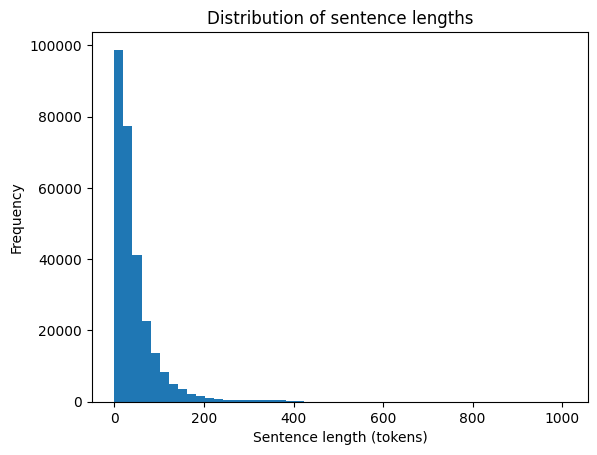

In [ ]:
lengths = train_df['QA Text'].astype(str).apply(lambda s: len(s.split()))
print(lengths.describe())   # mean, 95th percentile, max, etc.

import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.xlabel("Sentence length (tokens)")
plt.ylabel("Frequency")
plt.title("Distribution of sentence lengths")
plt.show()


| Column                    | Meaning                                                                                                                                                         |
| ------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **TargetN**               | The **desired minimum number of words** you want to keep in your vocabulary. Example: 10,000, 20,000, etc.                                                      |
| **min\_df**               | The **minimum document frequency** threshold (number of documents a word must appear in) chosen to keep at least `TargetN` words.                               |
| **min\_df(frac of docs)** | `min_df` expressed as a **fraction of total documents** (`min_df / n_docs`). Shows how rare/common a word must be relative to the dataset.                      |
| **kept\_vocab**           | The **actual number of words** that remain after applying `min_df`. Usually slightly more than `TargetN`.                                                       |
| **coverage(min\_df)%**    | The **percentage of all tokens in the corpus** covered by the vocabulary after applying `min_df`. Shows how much of the text is still represented.              |
| **coverage(top-N TF)%**   | The **percentage of tokens covered by the top-N most frequent words** (by term frequency). This is another way to measure coverage ignoring document frequency. |


 TargetN | min_df | min_df(frac of docs) | kept_vocab | coverage(min_df)% | coverage(top-N TF)%
   10000 |     73 |           0.00026     |     10057 |            87.02 |             87.06
   20000 |     23 |           0.00008     |     20127 |            90.98 |             91.01
   30000 |     12 |           0.00004     |     30282 |            92.52 |             92.56
   40000 |      7 |           0.00002     |     43829 |            93.61 |             93.43
   50000 |      5 |           0.00002     |     56489 |            94.23 |             94.02
   60000 |      4 |           0.00001     |     68003 |            94.65 |             94.45



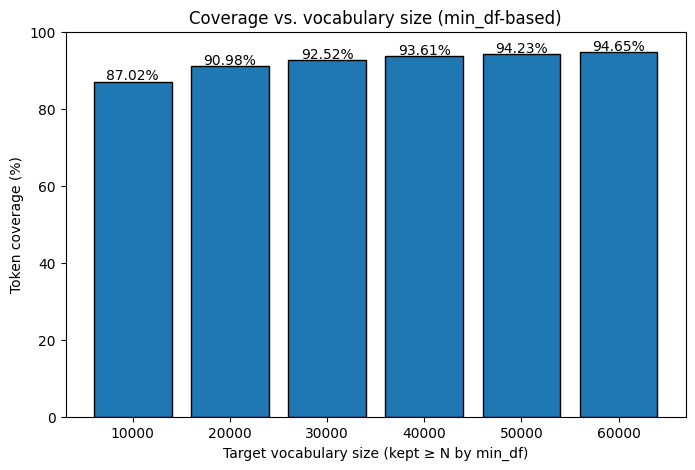

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------
# Step 1: Vocabulary Size vs Token Coverage
# ------------------------------------------------------
# Goal: Analyze how many tokens are captured by the most
# frequent words, and decide on an appropriate vocabulary
# cutoff for Skip-gram training.
#
# Why?
# - Too small vocab → many out-of-vocabulary (OOV) words
# - Too large vocab → more memory & compute with marginal gains
#
# Method:
# 1. Sort words by frequency.
# 2. Measure token coverage for top-N words (20k–60k).
# 3. Compute largest min_df value that leaves ≥N words.
#
# Finding:
# ~20k words cover ~91% of tokens → good trade-off.


#You look at all possible minimum document frequencies (min_df).

#You choose the biggest min_df that still keeps at least N words in the vocabulary.
# ---- Build vocabulary on the training corpus ----
texts = train_df["QA Text"].astype(str).tolist()
vec = CountVectorizer()               # use the same preproc you plan for models
X = vec.fit_transform(texts)

# Term frequency (TF) across the whole corpus & document frequency (DF = in how many docs a term appears)
tf = np.asarray(X.sum(axis=0)).ravel()
df = np.asarray((X > 0).sum(axis=0)).ravel().astype(int)
n_docs = X.shape[0]
total_tokens = tf.sum()

# Precompute: for every possible df threshold t, how many terms have df >= t
hist = np.bincount(df)                              # hist[k] = #terms with DF == k
cum_ge = np.cumsum(hist[::-1])[::-1]                # cum_ge[t] = #terms with DF >= t

def min_df_for_target_vocab(target_n: int):
    """
    Find the largest integer min_df threshold 't' such that #terms with DF>=t is still >= target_n.
    Returns (t, kept_vocab_size).
    """
    # indices where we still keep >= target_n terms
    idx = np.where(cum_ge >= target_n)[0]
    t = int(idx[-1])                 # largest t satisfying the condition
    kept = int(cum_ge[t])            # actual vocab size kept at this t (>= target_n)
    return t, kept

targets = [10000, 20000, 30000, 40000, 50000, 60000]
min_dfs, kept_vocab, coverage_by_mindf, mindf_fracs = [], [], [], []

for N in targets:
    t, kept = min_df_for_target_vocab(N)
    min_dfs.append(t)
    kept_vocab.append(kept)
    mindf_fracs.append(t / n_docs)
    idx_keep = np.where(df >= t)[0]
    cov = tf[idx_keep].sum() / total_tokens * 100.0
    coverage_by_mindf.append(cov)

# compare with "top-N by TF" coverage
tf_sorted_idx = np.argsort(-tf)
coverage_topN = [tf[tf_sorted_idx[:N]].sum() / total_tokens * 100.0 for N in targets]

# ---- Print a compact table ----
print(" TargetN | min_df | min_df(frac of docs) | kept_vocab | coverage(min_df)% | coverage(top-N TF)%")
for N, t, frac, kept, cov_df, cov_tf in zip(targets, min_dfs, mindf_fracs, kept_vocab, coverage_by_mindf, coverage_topN):
    print(f"{N:8} | {t:6} | {frac:17.5f}     | {kept:9} | {cov_df:16.2f} | {cov_tf:17.2f}")

print()
# ---- Bar plot: token coverage using min_df thresholds (targets 20k–60k) ----
plt.figure(figsize=(8,5))
plt.bar([str(n) for n in targets], coverage_by_mindf, edgecolor="black")
plt.xlabel("Target vocabulary size (kept ≥ N by min_df)")
plt.ylabel("Token coverage (%)")
plt.title("Coverage vs. vocabulary size (min_df-based)")
for i, v in enumerate(coverage_by_mindf):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha="center", fontsize=10)
plt.ylim(0, 100)
plt.show()


In [ ]:

tf = np.asarray(X.sum(axis=0)).ravel()          # total token counts per term
vocab = np.array(vec.get_feature_names_out())

# Sort by token frequency (descending)
idx = np.argsort(-tf)
tf_sorted = tf[idx]
vocab_sorted = vocab[idx]

# Find the smallest token-frequency threshold that keeps ~20k terms
target = 20000
# unique thresholds to scan (monotone). You can also do a binary search for speed.
unique_counts = np.unique(tf_sorted)[::-1]  # high->low
kept = None
min_count = None
for c in unique_counts:
    kept = np.sum(tf >= c)
    if kept >= target:
        min_count = c
        break

print(f"Chosen min_count (token freq): {min_count}, kept≈{kept} terms")

# (Optional) exact top-20k vocabulary list by TF, if you prefer capping strictly by N:
topN_vocab = set(vocab_sorted[:target])


Chosen min_count (token freq): 28, kept≈20071 terms


In [ ]:
train_df.head()

QA Text                  Class  \
0  good web design amateurly earn money job web d...     Business & Finance   
1  daughter want medical illustrator anyone know ...  Education & Reference   
2  brother jesus brother king one id say brother ...      Society & Culture   
3  student need admitted university hell earth me...  Education & Reference   
4  data disk heard possible save file data disk e...   Computers & Internet   

   label  
0      0  
1      2  
2      8  
3      2  
4      1

In [ ]:
# ------------------------------------------------------
# Step 2: Prepare Sentences for Skip-gram
# ------------------------------------------------------
# Convert each QA text row into a list of tokens.
# This produces a list of lists (280k sentences).
# Example: "good web design..." → ['good','web','design',...]


sentences = (
    train_df['QA Text']
    .astype(str)
    .apply(lambda s: [tok for tok in s.split() if tok])  # split to list of tokens
    .tolist()
)



In [ ]:
# ------------------------------------------------------
# Step 3: Train Skip-gram Word2Vec
# ------------------------------------------------------
# Parameters:
# - vector_size=300 → embedding dimension
# - window=5 → context window
# - sg=1 → skip-gram (predict context from word)
# - negative=5 → negative sampling
# - min_count=28 → ~20k vocab (from Step 1)
# - epochs=5 → can tune 5–15
# - workers=min(8, os.cpu_count()) → parallel CPU usage
#
# Result: ~20,074 word vectors learned


import os
mc = int(min_count) if ('min_count' in globals() and min_count is not None) else 5

w2v = Word2Vec(
    sentences=sentences,
    vector_size=300,   # try 100/200/300 in tuning
    window=5,
    sg=1,              # 1 = skip-gram
    negative=5,        # negative sampling
    min_count=mc,      # from coverage analysis (~20k vocab)
    sample=1e-5,       # sub-sampling frequent tokens
    epochs=5,          # tune 5–15
    workers=min(8, os.cpu_count() or 4)
)

print("Learned vocab size:", len(w2v.wv))

Learned vocab size: 20074


In [ ]:
# % of tokens in corpus that have vectors
known = sum(t in w2v.wv for s in sentences for t in s)
total = sum(len(s) for s in sentences)
print(f"Token coverage: {100*known/total:.2f}%  |  OOV: {100*(1-known/total):.2f}%")
#oov-percentage of tokens in your text that don’t have embeddings because they were not included in the vocabulary.


Token coverage: 91.03%  |  OOV: 8.97%


In [ ]:
# ------------------------------------------------------
# Step 4: Evaluate Embedding Quality (Intrinsic)
# ------------------------------------------------------
# 1. Token coverage → 91% (OOV ~9%)
# 2. Nearest neighbors (qualitative check):
#    money → ['repay','cash','deductable',...]
#    university → ['stanford','harvard','nyu',...]
# 3. These results show embeddings capture semantic meaning.


probe = ["money","university","doctor","religion","software","graphics"]
for w in probe:
    if w in w2v.wv:
        print(w, "→", [x for x,_ in w2v.wv.most_similar(w, topn=8)])


money → ['cashing', 'earning', 'cash', 'monies', 'ripoff', 'repay', 'mortage', 'paying']
university → ['stanford', 'mcgill', 'univ', 'cornell', 'doctoral', 'devry', 'undergraduate', 'accredited']
doctor → ['drs', 'prescribe', 'physician', 'webmd', 'endocrinologist', 'obgyn', 'ent', 'checkup']
religion → ['religious', 'christianity', 'sect', 'religous', 'belief', 'agnostic', 'bahai', 'christian']
software → ['shareware', 'freeware', 'opensource', 'cnet', 'standalone', 'openoffice', 'peertopeer', 'emule']


In [ ]:



# Save the embeddings for reuse
project_path = "/content/drive/MyDrive/CSE440/Project"
w2v.save(f"{project_path}/w2v_skipgram_mc{mc}_d300.model")
w2v.wv.save_word2vec_format(
    f"{project_path}/w2v_skipgram_mc{mc}_d300.kv", binary=True
)


# DNN with Skipgram

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
project_path = "/content/drive/MyDrive/CSE440/Project"
train_df = pd.read_csv(f"{project_path}/train_clean.csv", keep_default_na=False)
test_df  = pd.read_csv(f"{project_path}/test_clean.csv", keep_default_na=False)

In [ ]:
#Loading the embedding we saved

from gensim.models import Word2Vec, KeyedVectors

w2v_kv = KeyedVectors.load_word2vec_format(
    f"{project_path}/w2v_skipgram_mc28_d300.kv", binary=True
)

In [ ]:
train_df.head()

QA Text                  Class  \
0  good web design amateurly earn money job web d...     Business & Finance   
1  daughter want medical illustrator anyone know ...  Education & Reference   
2  brother jesus brother king one id say brother ...      Society & Culture   
3  student need admitted university hell earth me...  Education & Reference   
4  data disk heard possible save file data disk e...   Computers & Internet   

   label  
0      0  
1      2  
2      8  
3      2  
4      1

In [ ]:
train_df["QA Text"].isnull().sum()
#no issing data

0

Pre processing the training data to allign with our Neural Network Models and Embeddings


In [ ]:
# a) get texts & labels from train_df
texts_train = train_df["QA Text"].astype(str).tolist()
y_all       = train_df["label"].astype(int).values

# optional: sanity
print("train size:", len(texts_train), "| #classes:", len(np.unique(y_all)))

# b) tokenizer (fitting only on TRAIN to avoid test leakage)
NUM_WORDS = 20_000               # vocab cap
tok = Tokenizer(num_words=NUM_WORDS, oov_token="<unk>")
tok.fit_on_texts(texts_train)

# c) convert to sequences
seq_all = tok.texts_to_sequences(texts_train)

# d) pick a sensible max length
MAXLEN = 120
X_all = pad_sequences(seq_all, maxlen=MAXLEN, padding="post", truncating="post")

# e) create a validation split from TRAIN (keep given test_df for the final test only)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.15, stratify=y_all, random_state=42
)

print("Shapes -> X_tr:", X_tr.shape, " X_val:", X_val.shape)


train size: 280003 | #classes: 10
Shapes -> X_tr: (238002, 120)  X_val: (42001, 120)


pads shorter sequences with 0s until they reach length 120, or truncates longer sequences down to 120 tokens. Every sequence is now exactly 120 tokens long. Setting MAXLEN=120 captures the important part without wasting memory on too many zeros. Check the IQR Method we used previously in another file to find the reasoning behind this value

In [ ]:
X_tr[0]

array([  10,   12,  278,    8,  842,    5, 9493,  122,  103,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

This part builds the lookup table that connects our tokenizer’s word IDs
to the actual skip-gram vectors we trained earlier.

In [ ]:

from gensim.models import KeyedVectors


word_index   = tok.word_index # tok.word_index: maps each word → integer ID.
vocab_size   = min(len(word_index) + 1, NUM_WORDS)   # +1 for padding row
EMB_DIM      = 300


# Create a matrix filled with random values.

# Row 0 is reserved for padding → always zeros.

embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, EMB_DIM)).astype("float32")
embedding_matrix[0] = 0.0  # padding row

# set OOV row to zeros as well
#Ensure <unk> (for unknown words) points to a zero vector too.
oov_idx = word_index.get("<unk>")
if oov_idx is not None and oov_idx < vocab_size:
    embedding_matrix[oov_idx] = 0.0


# Loop over each word → index.

# If the word exists in your pretrained skip-gram (w2v_kv), copy its 300-dim vector into the correct row.

# Count how many words got covered (hits).

hits = 0
for w, i in word_index.items():
    if i >= vocab_size:
        continue
    if w in w2v_kv:
        embedding_matrix[i] = w2v_kv[w]
        hits += 1

print(f"Skip-gram coverage within top-{vocab_size}: {hits}/{vocab_size} ({hits/vocab_size*100:.2f}%)")



Skip-gram coverage within top-20000: 19998/20000 (99.99%)


Sometimes token IDs can be bigger than vocab_size (because the tokenizer might assign higher IDs beyond the top 20k).

Those IDs would cause an embedding lookup error.

So this line replaces any “too big” ID with the <unk> index.

In [ ]:
# ---------------------------
# 3) Defensive fixes on inputs
# ---------------------------
import numpy as np

# 🔧 Cap any IDs >= vocab_size to OOV (safety)
X_tr  = np.where(X_tr  < vocab_size, X_tr,  oov_idx)
X_val = np.where(X_val < vocab_size, X_val, oov_idx)



# Some texts may get cleaned down to nothing → sequence is all zeros.

# That leads to divide-by-zero problems in pooling.

# This function finds those empty rows and puts an <unk> at the last position, so they’re not “completely empty”.

def replace_empty_with_oov(X, oov_id):
    rows = (X.sum(axis=1) == 0)
    if rows.any():
        X[rows, -1] = oov_id
    return X

X_tr  = replace_empty_with_oov(X_tr,  oov_idx)
X_val = replace_empty_with_oov(X_val, oov_idx)



Input: each QA text is represented as a sequence of maxlen=120 integers (token IDs).

Embedding layer: maps each token ID → its vector.

input_dim=vocab_size → number of words in vocab (20k).

output_dim=emb_dim=300 → dimension of skip-gram vectors.

weights=[embedding_matrix] → initialize with your pretrained skip-gram vectors.

trainable=True → embeddings can be fine-tuned during training.

**Purpose of manual masking:** compute the average embedding of non-padding tokens.

Why not GlobalAveragePooling1D? → because all-pad rows can produce NaNs. This manual method avoids that.

Interpretation: each sentence → a single 300-dim averaged vector, representing its meaning.

**Why not just use GlobalAveragePooling1D?**

If a sequence is all padding (all zeros) → the mask says “ignore everything,” and GlobalAveragePooling1D ends up dividing by 0, producing NaN values.

Even if this happens for just a few rows, NaNs spread through training and break the model.
In oue dataset, we already saw a few “empty” QA texts after preprocessing. That’s why some of our earlier runs produced nan loss until we fixed it with this manual averaging.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_dnn_from_skipgram(vocab_size, emb_dim, num_classes,
                                 embedding_matrix, maxlen=120, trainable=True):
    inp = layers.Input(shape=(maxlen,), dtype="int32")

    # No built-in masking; we'll handle mask manually
    emb = layers.Embedding(
        input_dim=vocab_size,
        output_dim=emb_dim,
        weights=[embedding_matrix],
        trainable=trainable,
        mask_zero=False
    )(inp)

    # mask: 1 for non-pad, 0 for pad  -> [B,T]
    mask = layers.Lambda(lambda t: tf.cast(tf.not_equal(t, 0), tf.float32))(inp)
    mask = layers.Lambda(lambda m: tf.expand_dims(m, -1))(mask)           # [B,T,1]

    # masked sum and safe average
    summed   = layers.Lambda(lambda xs: tf.reduce_sum(xs[0] * xs[1], axis=1))([emb, mask])   # [B,D]
    lengths  = layers.Lambda(lambda m: tf.reduce_sum(m, axis=1))(mask)                       # [B,1]
    avg      = layers.Lambda(lambda xs: xs[0] / tf.maximum(xs[1], 1.0))([summed, lengths])   # [B,D]

    x = layers.Dropout(0.20)(avg)

    x = layers.Dense(768, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Dense(384, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.30)(x)

    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out)








**First Dense Layer (768 units):**

Learns high-level abstract features.

ReLU activation for nonlinearity.

l2(1e-5) penalizes large weights → prevents overfitting.

BatchNormalization: stabilizes activations, speeds training.

Dropout (20–30%): regularization, prevents co-adaptation.

**Second Dense Layer (384 units):** compression stage → reduces dimensionality while extracting patterns.

**Interpretation:** these layers transform the averaged embedding into richer, task-specific features for classification.

In [ ]:
classes = np.unique(y_tr)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print("class weights:", class_weights)


class weights: {0: 1.0016919191919191, 1: 1.0007232056510953, 2: 1.0010178331090176, 3: 0.9905606193032838, 4: 1.0034234158269741, 5: 0.9934134735787629, 6: 1.0091672320217095, 7: 0.998623756975622, 8: 1.004270222372252, 9: 0.9973683107740016}


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)

model = build_dnn_from_skipgram(
    vocab_size=embedding_matrix.shape[0],
    emb_dim=embedding_matrix.shape[1],
    num_classes=10,
    embedding_matrix=embedding_matrix,
    maxlen=X_tr.shape[1],
    trainable=True
)

model.compile(optimizer=opt,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ],
    verbose=1
)
# EarlyStopping: stop when no improvement (avoid wasting epochs, avoid overfitting).

# ReduceLROnPlateau: adapt the learning rate when progress stalls.


Epoch 1/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 203s 211ms/step - accuracy: 0.5973 - loss: 1.3715 - val_accuracy: 0.6930 - val_loss: 0.9737 - learning_rate: 3.0000e-04
Epoch 2/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 198s 212ms/step - accuracy: 0.6807 - loss: 1.0184 - val_accuracy: 0.7006 - val_loss: 0.9413 - learning_rate: 3.0000e-04
Epoch 3/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 197s 207ms/step - accuracy: 0.7013 - loss: 0.9475 - val_accuracy: 0.7063 - val_loss: 0.9302 - learning_rate: 3.0000e-04
Epoch 4/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 198s 212ms/step - accuracy: 0.7164 - loss: 0.8895 - val_accuracy: 0.7098 - val_loss: 0.9140 - learning_rate: 3.0000e-04
Epoch 5/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 200s 210ms/step - accuracy: 0.7250 - loss: 0.8577 - val_accuracy: 0.7105 - val_loss: 0.9200 - learning_rate: 3.0000e-04
Epoch 6/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 197s 212ms/step - accuracy: 0.7360 - loss: 0.8204 - val_accuracy: 0.7111 - val_loss: 0.9204 - learning_rate: 3.0000e-04
Epoch 7/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 

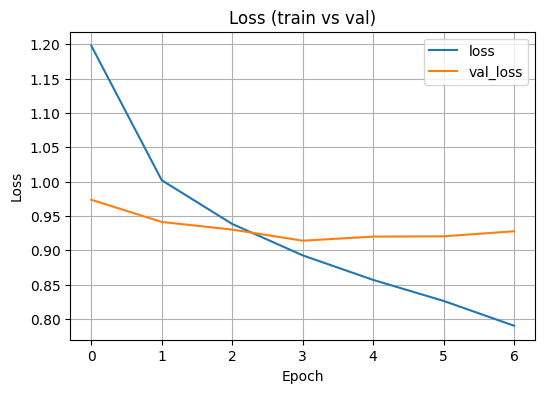

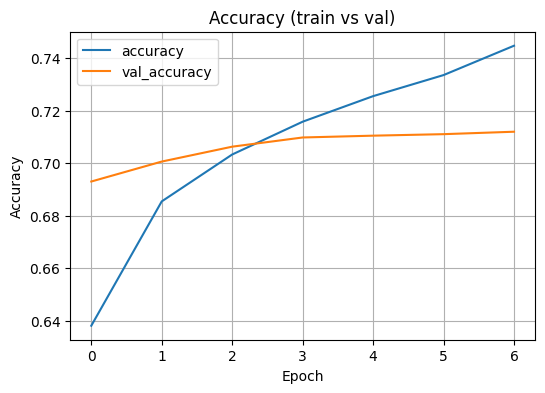

In [ ]:
plot_loss(history)
plot_acc(history)


VAL Accuracy: 0.7098 | Macro-F1: 0.7036
              precision    recall  f1-score   support

           0     0.6796    0.4562    0.5459      4193
           1     0.8145    0.8713    0.8419      4197
           2     0.5886    0.4790    0.5282      4196
           3     0.6638    0.7050    0.6837      4240
           4     0.6870    0.7776    0.7295      4186
           5     0.7431    0.8283    0.7834      4228
           6     0.7235    0.7890    0.7549      4162
           7     0.6956    0.7601    0.7264      4206
           8     0.5960    0.5605    0.5777      4182
           9     0.8596    0.8694    0.8645      4211

    accuracy                         0.7098     42001
   macro avg     0.7051    0.7096    0.7036     42001
weighted avg     0.7052    0.7098    0.7037     42001



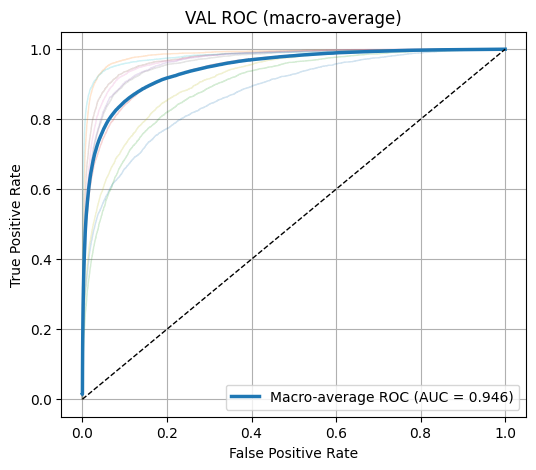

Per-class AUCs:
  Class 0: AUC = 0.8728
  Class 1: AUC = 0.9846
  Class 2: AUC = 0.8932
  Class 3: AUC = 0.9439
  Class 4: AUC = 0.9641
  Class 5: AUC = 0.9732
  Class 6: AUC = 0.9692
  Class 7: AUC = 0.9607
  Class 8: AUC = 0.9134
  Class 9: AUC = 0.9817
Macro-average AUC: 0.9457


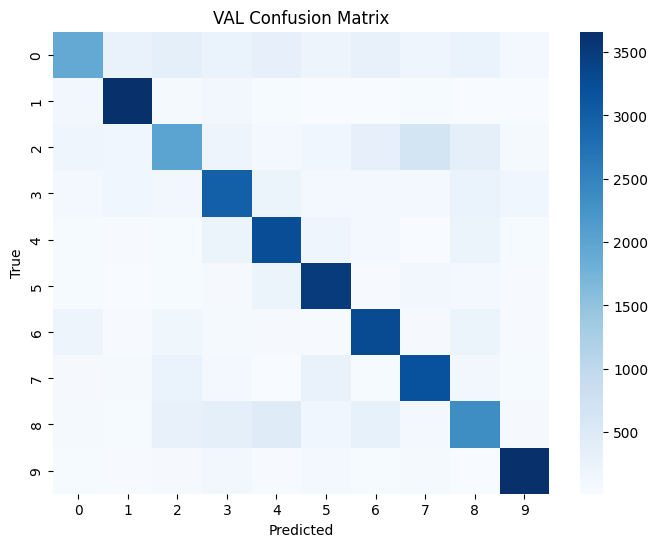

In [ ]:
val_results = evaluation_set(model, X_val, y_val, name="VAL")


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# texts + labels
texts_test = test_df["QA Text"].astype(str).tolist()
y_test     = test_df["label"].astype(int).values

# tokenize -> pad
seq_test = tok.texts_to_sequences(texts_test)
X_test   = pad_sequences(seq_test, maxlen=MAXLEN, padding="post", truncating="post")

# cap ids to vocab and replace overflow with OOV
vocab_size = embedding_matrix.shape[0]
X_test = np.where(X_test < vocab_size, X_test, oov_idx)

# fix any all-pad rows (rare but important)
X_test = replace_empty_with_oov(X_test, oov_idx)

print("Test shape:", X_test.shape, "| Labels:", y_test.shape)


Test shape: (59999, 120) | Labels: (59999,)


Final Test for DNN With Skipgram Accuracy: 0.7123 | Macro-F1: 0.7065
              precision    recall  f1-score   support

           0     0.6815    0.4593    0.5488      6000
           1     0.8228    0.8697    0.8456      6000
           2     0.5831    0.4813    0.5273      6000
           3     0.6678    0.7158    0.6910      6000
           4     0.6936    0.7746    0.7319      5999
           5     0.7282    0.8195    0.7712      6000
           6     0.7378    0.7945    0.7651      6000
           7     0.7042    0.7630    0.7324      6000
           8     0.5993    0.5692    0.5839      6000
           9     0.8595    0.8762    0.8678      6000

    accuracy                         0.7123     59999
   macro avg     0.7078    0.7123    0.7065     59999
weighted avg     0.7078    0.7123    0.7065     59999



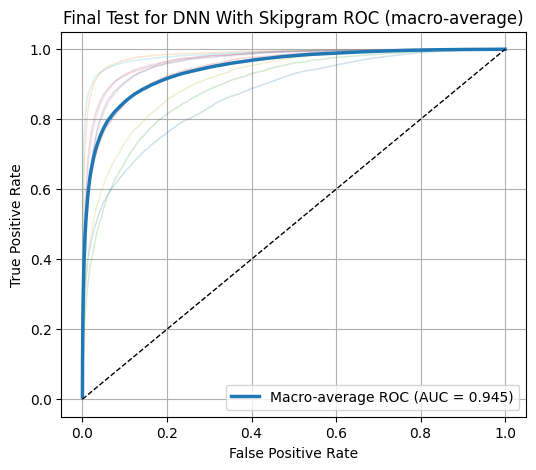

Per-class AUCs:
  Class 0: AUC = 0.8690
  Class 1: AUC = 0.9846
  Class 2: AUC = 0.8902
  Class 3: AUC = 0.9472
  Class 4: AUC = 0.9628
  Class 5: AUC = 0.9708
  Class 6: AUC = 0.9692
  Class 7: AUC = 0.9625
  Class 8: AUC = 0.9132
  Class 9: AUC = 0.9839
Macro-average AUC: 0.9454


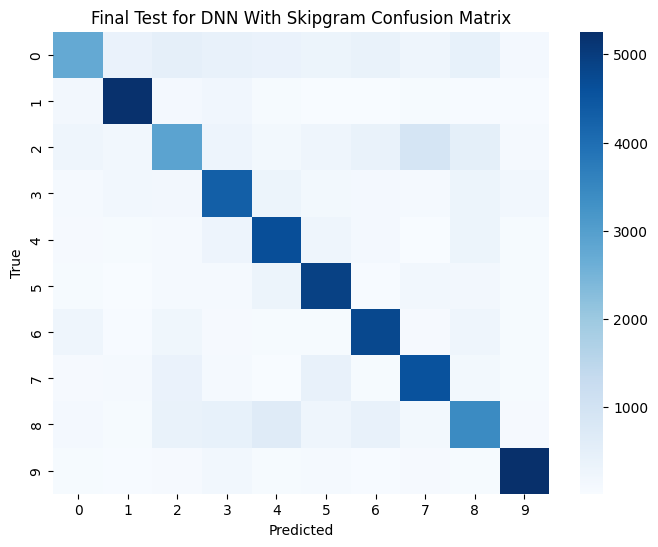

In [ ]:
test_results = evaluation_set(model, X_test, y_test, name="Final Test for DNN With Skipgram")


# Saving and loading the pre processed data (Utilities and Helper Functions)

In [ ]:
# === Save preprocessed data to Google Drive ===
from google.colab import drive
from pathlib import Path
import numpy as np, json

drive.mount("/content/drive", force_remount=False)

DRIVE_DIR = Path("/content/drive/MyDrive/CSE440/Project/prepared_data/skipgram_v1")
DRIVE_DIR.mkdir(parents=True, exist_ok=True)

# ensure compact dtypes
X_tr = X_tr.astype("int32"); X_val = X_val.astype("int32"); X_test = X_test.astype("int32")
y_tr = y_tr.astype("int64"); y_val = y_val.astype("int64"); y_test = y_test.astype("int64")

# 1) splits
np.savez_compressed(DRIVE_DIR / "train.npz", X=X_tr, y=y_tr)
np.savez_compressed(DRIVE_DIR / "val.npz",   X=X_val, y=y_val)
np.savez_compressed(DRIVE_DIR / "test.npz",  X=X_test, y=y_test)

# 2) tokenizer
with open(DRIVE_DIR / "tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tok.to_json())

# 3) meta (store what your loaders need later)
meta = {
    "maxlen": int(X_tr.shape[1]),
    "num_classes": int(len(np.unique(y_tr))),
    "vocab_size": int(embedding_matrix.shape[0]),  # e.g., 20000
    "emb_dim": int(embedding_matrix.shape[1]),     # e.g., 300
    "oov_idx": int(oov_idx),
    "num_words": int(embedding_matrix.shape[0])    # alias used by some helpers
}
with open(DRIVE_DIR / "meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("Saved to:", DRIVE_DIR.resolve())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to: /content/drive/MyDrive/CSE440/Project/prepared_data/skipgram_v1


### Load

In [ ]:
# === LOAD (robust & Drive-aware) ===
import json, numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# 1) Try to mount Drive (no-op if already mounted)
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
except Exception:
    pass

# 2) Resolve OUT_DIR automatically (local or Drive)
CANDIDATES = [
    Path("./prepared_data/skipgram_v1"),
    Path("/content/prepared_data/skipgram_v1"),
    Path("/content/drive/MyDrive/CSE440/Project/prepared_data/skipgram_v1"),
    Path("/content/drive/MyDrive/prepared_data/skipgram_v1"),
]
def pick_out_dir():
    for p in CANDIDATES:
        if (p/"train.npz").exists() and (p/"val.npz").exists() and (p/"test.npz").exists() \
           and (p/"tokenizer.json").exists() and (p/"meta.json").exists():
            return p
    raise FileNotFoundError("prepared_data/skipgram_v1 with train/val/test.npz + tokenizer.json + meta.json not found.")

OUT_DIR = pick_out_dir()
print("OUT_DIR =", OUT_DIR)

# 3) Reload splits
train = np.load(OUT_DIR/"train.npz"); X_tr, y_tr = train["X"], train["y"]
val   = np.load(OUT_DIR/"val.npz");   X_val, y_val = val["X"], val["y"]
test  = np.load(OUT_DIR/"test.npz");  X_test, y_test = test["X"], test["y"]

# 4) Reload tokenizer & meta
with open(OUT_DIR/"tokenizer.json","r",encoding="utf-8") as f:
    tok = tokenizer_from_json(f.read())
with open(OUT_DIR/"meta.json","r",encoding="utf-8") as f:
    meta = json.load(f)

# 5) Constants expected later (with a hard 20k vocab cap)
MAXLEN      = int(meta.get("maxlen", X_tr.shape[1]))
NUM_CLASSES = int(meta.get("num_classes", np.unique(y_tr).size))
NUM_WORDS   = min(int(meta.get("num_words", meta.get("vocab_size", 20_000))), 20_000)

# 6) Compact dtypes for speed/memory
X_tr  = X_tr.astype("int32"); X_val = X_val.astype("int32"); X_test = X_test.astype("int32")
y_tr  = y_tr.astype("int64"); y_val = y_val.astype("int64"); y_test = y_test.astype("int64")

print("Reloaded:", X_tr.shape, X_val.shape, X_test.shape)
print("Meta:", {k: meta.get(k) for k in ["maxlen","num_classes","vocab_size","emb_dim","oov_idx"]})
print(f"Constants → MAXLEN={MAXLEN} | NUM_CLASSES={NUM_CLASSES} | NUM_WORDS(cap)={NUM_WORDS}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OUT_DIR = /content/drive/MyDrive/CSE440/Project/prepared_data/skipgram_v1
Reloaded: (238002, 120) (42001, 120) (59999, 120)
Meta: {'maxlen': 120, 'num_classes': 10, 'vocab_size': 20000, 'emb_dim': 300, 'oov_idx': 1}
Constants → MAXLEN=120 | NUM_CLASSES=10 | NUM_WORDS(cap)=20000


In [ ]:
# Save GloVe File in Drive

glove_file = '/content/drive/MyDrive/CSE440/glove.6B.100d.txt'

In [ ]:

def load_glove_txt(txt_path, emb_dim):
    """
    Load GloVe .txt (e.g., glove.6B.100d.txt) to dict: word -> np.array(emb_dim,)
    """
    vectors = {}
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            if len(parts) < emb_dim + 1:
                continue
            w = parts[0]
            vec = np.asarray(parts[1:1+emb_dim], dtype="float32")
            if vec.shape[0] == emb_dim:
                vectors[w] = vec
    print(f"[GloVe] loaded {len(vectors):,} vectors")
    return vectors



In [ ]:
#Loading the embedding we saved
project_path = "/content/drive/MyDrive/CSE440/Project"
from gensim.models import Word2Vec, KeyedVectors

w2v_kv = KeyedVectors.load_word2vec_format(
    f"{project_path}/w2v_skipgram_mc28_d300.kv", binary=True
)

In [ ]:
def kv_to_lookup(w2v_kv, emb_dim=None):
    """
    Wrap gensim KeyedVectors as a dict-like lookup {word: vector}.
    """
    class KVLookup(dict):
        def __init__(self, kv, emb_dim):
            self.kv = kv
            self.emb_dim = emb_dim or kv.vector_size
        def __contains__(self, w): return w in self.kv
        def __getitem__(self, w):  return self.kv[w]
    lookup = KVLookup(w2v_kv, emb_dim)
    print(f"[KeyedVectors] vector_size = {lookup.emb_dim}")
    return lookup

In [ ]:
# ============  B) EMBEDDING MATRIX  ============
def build_embedding_matrix_from_lookup(tok, num_words, emb_dim, lookup,
                                       pad_token_id=0, oov_token="<unk>"):
    """
    Create an embedding matrix aligned to `tok.word_index`.
    - num_words is your vocab cap (e.g., 20_000)
    - emb_dim is vector size (e.g., 100 for GloVe-100d, 300 for skip-gram)
    - lookup is from load_glove_txt(...) or kv_to_lookup(...)
    Returns: embedding_matrix (vocab_size x emb_dim), oov_idx, stats
    """
    word_index = tok.word_index
    vocab_size = min(len(word_index) + 1, num_words)  # +1 for pad row (id=0)

    emb = np.random.normal(scale=0.6, size=(vocab_size, emb_dim)).astype("float32")
    emb[pad_token_id] = 0.0   # padding row is zeros

    oov_idx = word_index.get(oov_token, 1)
    if oov_idx < vocab_size:
        emb[oov_idx] = 0.0

    hits = 0
    for w, i in word_index.items():
        if i >= vocab_size:
            continue
        if w in lookup:
            vec = lookup[w]
            if vec.shape[0] == emb_dim:
                emb[i] = vec
                hits += 1

    coverage = 100.0 * hits / float(vocab_size)
    print(f"Coverage: {hits}/{vocab_size} ({coverage:.2f}%)")
    return emb, oov_idx, {"vocab_size": int(vocab_size), "hits": int(hits), "coverage_pct": coverage}

In [ ]:
# ============  C) DEFENSIVE INPUT FIXES  ============
def cap_ids_and_fix_empty(X, vocab_size, oov_idx):
    """
    - Replace any token id >= vocab_size with oov_idx
    - Replace fully-empty rows with a single oov token at the end
    """
    Xc = np.where(X < vocab_size, X, oov_idx)
    rows_empty = (Xc.sum(axis=1) == 0)
    if rows_empty.any():
        Xc[rows_empty, -1] = oov_idx
    return Xc


In [ ]:
# ============  D) MODEL BUILDERS (no training)  ============
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# --- DNN with safe mean pooling (works for any emb_dim) ---
def build_dnn_avg(vocab_size, emb_dim, num_classes, embedding_matrix,
                  maxlen, trainable=True, l2=1e-5, d_mid1=768, d_mid2=384,
                  dropout_in=0.20, dropout_h=0.30):
    inp = layers.Input(shape=(maxlen,), dtype="int32")
    emb = layers.Embedding(
        input_dim=vocab_size,
        output_dim=emb_dim,
        weights=[embedding_matrix],
        trainable=trainable,
        mask_zero=False  # we'll do manual safe pooling
    )(inp)

    # manual, safe average over non-pad tokens
    mask = layers.Lambda(lambda t: tf.cast(tf.not_equal(t, 0), tf.float32))(inp)  # [B,T]
    mask = layers.Lambda(lambda m: tf.expand_dims(m, -1))(mask)                   # [B,T,1]
    summed  = layers.Lambda(lambda xs: tf.reduce_sum(xs[0]*xs[1], axis=1))([emb, mask])  # [B,D]
    lengths = layers.Lambda(lambda m: tf.reduce_sum(m, axis=1))(mask)                   # [B,1]
    avg     = layers.Lambda(lambda xs: xs[0] / tf.maximum(xs[1], 1.0))([summed, lengths])

    x = layers.Dropout(dropout_in)(avg)
    x = layers.Dense(d_mid1, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_h)(x)
    x = layers.Dense(d_mid2, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_h)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out)

# --- RNN “core” builder helper (SimpleRNN/LSTM/GRU, uni/bidirectional) ---
def _sequence_core(emb_out, units, cell_type="lstm", bidirectional=False, return_sequences=False):
    if cell_type == "rnn":
        cell = layers.SimpleRNN(units, return_sequences=return_sequences)
    elif cell_type == "gru":
        cell = layers.GRU(units, return_sequences=return_sequences)
    else:
        cell = layers.LSTM(units, return_sequences=return_sequences)

    if bidirectional:
        return layers.Bidirectional(cell)(emb_out)
    else:
        return cell(emb_out)

# --- Shared embedding stack for sequence models (mask aware) ---
def _masked_embedding_block(vocab_size, emb_dim, embedding_matrix, maxlen, trainable=True):
    inp = layers.Input(shape=(maxlen,), dtype="int32")
    emb = layers.Embedding(
        input_dim=vocab_size,
        output_dim=emb_dim,
        weights=[embedding_matrix],
        trainable=trainable,
        mask_zero=True   # RNNs/LSTMs/GRUs will respect the mask
    )(inp)
    return inp, emb

# --- SimpleRNN ---
def build_rnn(vocab_size, emb_dim, num_classes, embedding_matrix, maxlen,
              units=128, bidirectional=False, trainable=True, dropout=0.3):
    inp, emb = _masked_embedding_block(vocab_size, emb_dim, embedding_matrix, maxlen, trainable)
    x = _sequence_core(emb, units, cell_type="rnn", bidirectional=bidirectional, return_sequences=False)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out)

# --- LSTM ---
def build_lstm(vocab_size, emb_dim, num_classes, embedding_matrix, maxlen,
               units=128, bidirectional=False, trainable=True, dropout=0.3):
    inp, emb = _masked_embedding_block(vocab_size, emb_dim, embedding_matrix, maxlen, trainable)
    x = _sequence_core(emb, units, cell_type="lstm", bidirectional=bidirectional, return_sequences=False)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out)

# --- GRU ---
def build_gru(vocab_size, emb_dim, num_classes, embedding_matrix, maxlen,
              units=128, bidirectional=False, trainable=True, dropout=0.3):
    inp, emb = _masked_embedding_block(vocab_size, emb_dim, embedding_matrix, maxlen, trainable)
    x = _sequence_core(emb, units, cell_type="gru", bidirectional=bidirectional, return_sequences=False)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out)

# DNN With GloVe

In [ ]:

# Train a Text Classifier with GloVe Embeddings (100d)
# We will **reuse preprocessed arrays** (token IDs), build a GloVe embedding matrix,
# create a DNN classifier (safe pooled), train with callbacks, and evaluate using
# plotting and evaluation helpers.

import json
import numpy as np
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# For evaluation_set helper (uses sklearn + seaborn)
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

Step 1 — Load cached arrays/tokenizer/meta (no re-tokenization or re-padding)

In [ ]:

# -------------------------
# Step 1) load cached arrays/tokenizer/meta
# -------------------------
OUT_DIR = Path("./prepared_data/skipgram_v1")  # adjust if your folder is different

X_tr, y_tr = np.load(OUT_DIR/"train.npz")["X"], np.load(OUT_DIR/"train.npz")["y"]
X_val, y_val = np.load(OUT_DIR/"val.npz")["X"], np.load(OUT_DIR/"val.npz")["y"]
X_test, y_test = np.load(OUT_DIR/"test.npz")["X"], np.load(OUT_DIR/"test.npz")["y"]

tok  = tokenizer_from_json((OUT_DIR/"tokenizer.json").read_text("utf-8"))
meta = json.loads((OUT_DIR/"meta.json").read_text("utf-8"))

MAXLEN      = int(meta["maxlen"])
NUM_CLASSES = int(meta["num_classes"])
NUM_WORDS   = int(meta["vocab_size"])     # keep aligned with preprocessing (e.g., 20000)

X_tr.shape, X_val.shape, X_test.shape, NUM_WORDS, MAXLEN, NUM_CLASSES, OOV_IDX

((238002, 120), (42001, 120), (59999, 120), 20000, 120, 10, 1)

In [ ]:
# -------------------------
# Step 2) choose GloVe and build lookup
# -------------------------
GLOVE_TXT = "/content/drive/MyDrive/CSE440/glove.6B.100d.txt"  #  file
EMB_DIM   = 100

lookup = load_glove_txt(GLOVE_TXT, EMB_DIM)  # (helper)

[GloVe] loaded 400,000 vectors


In [ ]:
# -------------------------
# Step 3) build embedding matrix + defensive fixes
# -------------------------
embedding_matrix, oov_idx, cov = build_embedding_matrix_from_lookup(
    tok=tok, num_words=NUM_WORDS, emb_dim=EMB_DIM, lookup=lookup, oov_token="<unk>"
)
vocab_size = embedding_matrix.shape[0]

X_tr  = cap_ids_and_fix_empty(X_tr,  vocab_size, oov_idx)  # ( helper)
X_val = cap_ids_and_fix_empty(X_val, vocab_size, oov_idx)
X_test= cap_ids_and_fix_empty(X_test, vocab_size, oov_idx)

print("Coverage:", cov)


Coverage: 18784/20000 (93.92%)
Coverage: {'vocab_size': 20000, 'hits': 18784, 'coverage_pct': 93.92}


In [ ]:
# -------------------------
# Step 4) build DNN model (mean-pooled) using our builder
# -------------------------
model = build_dnn_avg(     # (helper)
    vocab_size=vocab_size,
    emb_dim=EMB_DIM,
    num_classes=NUM_CLASSES,
    embedding_matrix=embedding_matrix,
    maxlen=MAXLEN,
    trainable=True,         # fine-tune GloVe
    d_mid1=768, d_mid2=384, dropout_in=0.20, dropout_h=0.30
)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 120)       │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 120, 100)  │  2,000,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 120, 1)    │          0 │ lambda_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, 100)       │          0 │ embedding_10[0][… │
│                     │                   │            │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, 1)         │          0 │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, 100)       │          0 │ lambda_17[0][0],  │
│                     │                   │            │ lambda_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 100)       │          0 │ lambda_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 768)       │     77,568 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768)       │      3,072 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 768)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 384)       │    295,296 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384)       │      1,536 │ dense_25[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 384)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 10)        │      3,850 │ dropout_22[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,381,322 (9.08 MB)

 Trainable params: 2,379,018 (9.08 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [ ]:
# -------------------------
# Step 5) compile + callbacks
# -------------------------
opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
]


In [ ]:
# -------------------------
# Step 6) train
# -------------------------
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=256,
    callbacks=cbs,
    verbose=1
)


Epoch 1/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.5103 - loss: 1.6403 - val_accuracy: 0.6560 - val_loss: 1.0863 - learning_rate: 3.0000e-04
Epoch 2/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 73s 67ms/step - accuracy: 0.6202 - loss: 1.1958 - val_accuracy: 0.6685 - val_loss: 1.0403 - learning_rate: 3.0000e-04
Epoch 3/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.6492 - loss: 1.1025 - val_accuracy: 0.6820 - val_loss: 0.9978 - learning_rate: 3.0000e-04
Epoch 4/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.6663 - loss: 1.0451 - val_accuracy: 0.6873 - val_loss: 0.9799 - learning_rate: 3.0000e-04
Epoch 5/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 75s 80ms/step - accuracy: 0.6786 - loss: 1.0063 - val_accuracy: 0.6925 - val_loss: 0.9635 - learning_rate: 3.0000e-04
Epoch 6/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 75s 73ms/step - accuracy: 0.6867 - loss: 0.9797 - val_accuracy: 0.6960 - val_loss: 0.9532 - learning_rate: 3.0000e-04
Epoch 7/15
930/930 ━━━━━━━━━━━━━━━━━━━━ 80s 70ms/ste

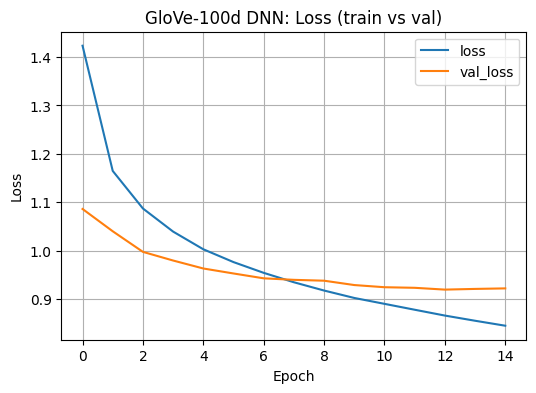

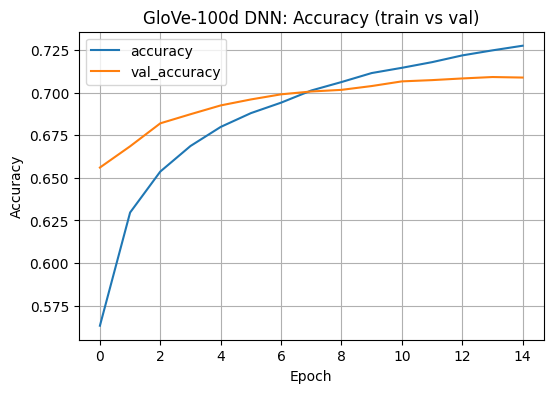

In [ ]:
# -------------------------
# Step 7) curves + evaluation (using our helpers)
# -------------------------
plot_loss(history, title="GloVe-100d DNN: Loss (train vs val)")
plot_acc(history,  title="GloVe-100d DNN: Accuracy (train vs val)")

Val (GloVe-100d DNN) Accuracy: 0.7095 | Macro-F1: 0.7034
              precision    recall  f1-score   support

           0     0.6390    0.4741    0.5444      4193
           1     0.8078    0.8823    0.8434      4197
           2     0.6031    0.4776    0.5330      4196
           3     0.7011    0.6778    0.6893      4240
           4     0.6492    0.8058    0.7190      4186
           5     0.7576    0.8141    0.7849      4228
           6     0.7305    0.7850    0.7568      4162
           7     0.6986    0.7603    0.7281      4206
           8     0.5952    0.5440    0.5685      4182
           9     0.8601    0.8727    0.8663      4211

    accuracy                         0.7095     42001
   macro avg     0.7042    0.7094    0.7034     42001
weighted avg     0.7044    0.7095    0.7035     42001



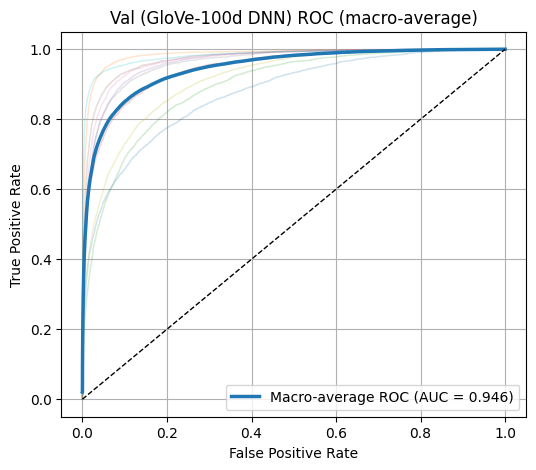

Per-class AUCs:
  Class 0: AUC = 0.8740
  Class 1: AUC = 0.9851
  Class 2: AUC = 0.8936
  Class 3: AUC = 0.9444
  Class 4: AUC = 0.9636
  Class 5: AUC = 0.9722
  Class 6: AUC = 0.9688
  Class 7: AUC = 0.9604
  Class 8: AUC = 0.9131
  Class 9: AUC = 0.9825
Macro-average AUC: 0.9458


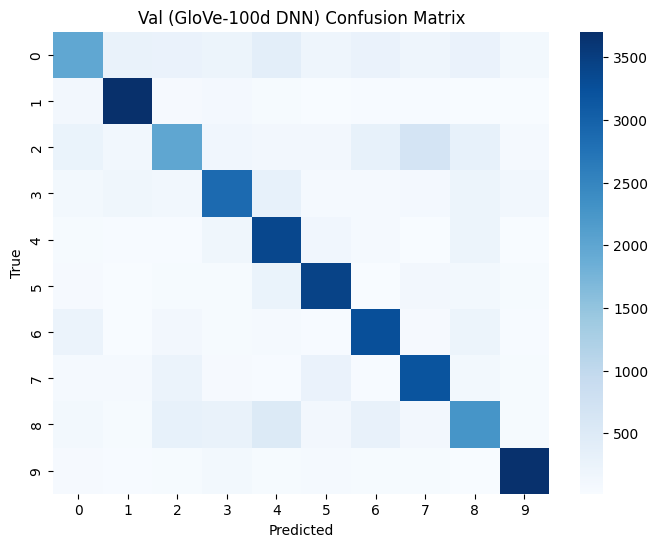

In [ ]:
_ = evaluation_set(model, X_val, y_val, name="Val (GloVe-100d DNN)")

In [ ]:
EPOCHS = 30  # was 15

cbs = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,          # a touch more patience
        min_delta=1e-3,      # require ~0.001 improvement to count
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-5,
        min_delta=1e-3       # only reduce LR if improvement < 0.001
    ),
]

opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=256,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)


Epoch 1/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 65s 66ms/step - accuracy: 0.7253 - loss: 0.8512 - val_accuracy: 0.7089 - val_loss: 0.9243 - learning_rate: 3.0000e-04
Epoch 2/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - accuracy: 0.7287 - loss: 0.8416 - val_accuracy: 0.7092 - val_loss: 0.9194 - learning_rate: 3.0000e-04
Epoch 3/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.7304 - loss: 0.8348 - val_accuracy: 0.7095 - val_loss: 0.9167 - learning_rate: 3.0000e-04
Epoch 4/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.7329 - loss: 0.8278 - val_accuracy: 0.7100 - val_loss: 0.9191 - learning_rate: 3.0000e-04
Epoch 5/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.7363 - loss: 0.8157 - val_accuracy: 0.7096 - val_loss: 0.9251 - learning_rate: 3.0000e-04
Epoch 6/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.7400 - loss: 0.8006 - val_accuracy: 0.7112 - val_loss: 0.9241 - learning_rate: 1.5000e-04
Epoch 7/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 63s 68ms/ste

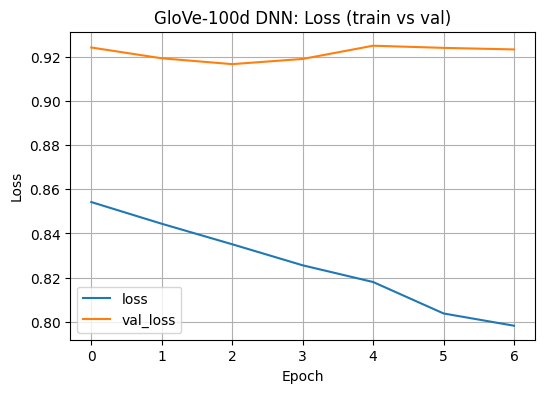

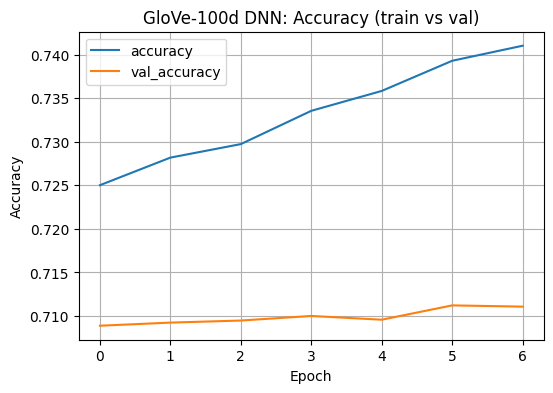

In [ ]:
plot_loss(history, title="GloVe-100d DNN: Loss (train vs val)")
plot_acc(history,  title="GloVe-100d DNN: Accuracy (train vs val)")

Val (GloVe-100d DNN) Accuracy: 0.7095 | Macro-F1: 0.7034
              precision    recall  f1-score   support

           0     0.6390    0.4741    0.5444      4193
           1     0.8078    0.8823    0.8434      4197
           2     0.6031    0.4776    0.5330      4196
           3     0.7011    0.6778    0.6893      4240
           4     0.6492    0.8058    0.7190      4186
           5     0.7576    0.8141    0.7849      4228
           6     0.7305    0.7850    0.7568      4162
           7     0.6986    0.7603    0.7281      4206
           8     0.5952    0.5440    0.5685      4182
           9     0.8601    0.8727    0.8663      4211

    accuracy                         0.7095     42001
   macro avg     0.7042    0.7094    0.7034     42001
weighted avg     0.7044    0.7095    0.7035     42001



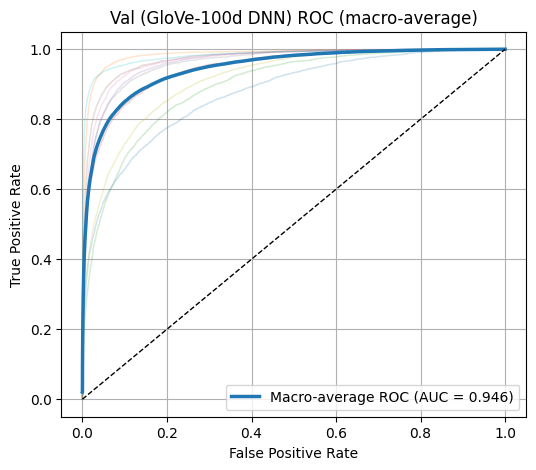

Per-class AUCs:
  Class 0: AUC = 0.8740
  Class 1: AUC = 0.9851
  Class 2: AUC = 0.8936
  Class 3: AUC = 0.9444
  Class 4: AUC = 0.9636
  Class 5: AUC = 0.9722
  Class 6: AUC = 0.9688
  Class 7: AUC = 0.9604
  Class 8: AUC = 0.9131
  Class 9: AUC = 0.9825
Macro-average AUC: 0.9458


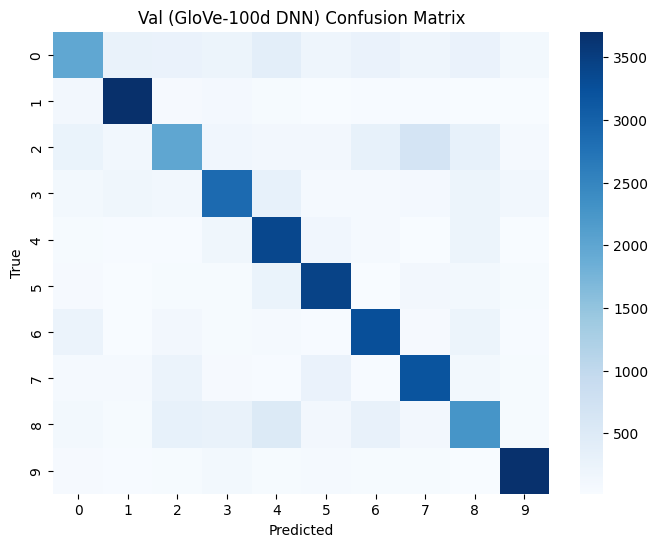

In [ ]:
_ = evaluation_set(model, X_val, y_val, name="Val (GloVe-100d DNN)")

Test (GloVe-100d DNN) Accuracy: 0.7110 | Macro-F1: 0.7052
              precision    recall  f1-score   support

           0     0.6380    0.4788    0.5471      6000
           1     0.8112    0.8780    0.8433      6000
           2     0.5900    0.4742    0.5258      6000
           3     0.7044    0.6900    0.6971      6000
           4     0.6572    0.8028    0.7227      5999
           5     0.7407    0.8045    0.7713      6000
           6     0.7435    0.7905    0.7663      6000
           7     0.6982    0.7585    0.7271      6000
           8     0.6109    0.5545    0.5813      6000
           9     0.8615    0.8780    0.8697      6000

    accuracy                         0.7110     59999
   macro avg     0.7056    0.7110    0.7052     59999
weighted avg     0.7056    0.7110    0.7052     59999



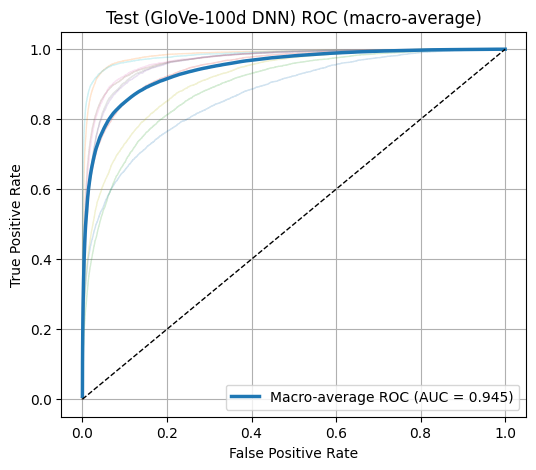

Per-class AUCs:
  Class 0: AUC = 0.8690
  Class 1: AUC = 0.9842
  Class 2: AUC = 0.8906
  Class 3: AUC = 0.9481
  Class 4: AUC = 0.9623
  Class 5: AUC = 0.9693
  Class 6: AUC = 0.9686
  Class 7: AUC = 0.9625
  Class 8: AUC = 0.9136
  Class 9: AUC = 0.9841
Macro-average AUC: 0.9452


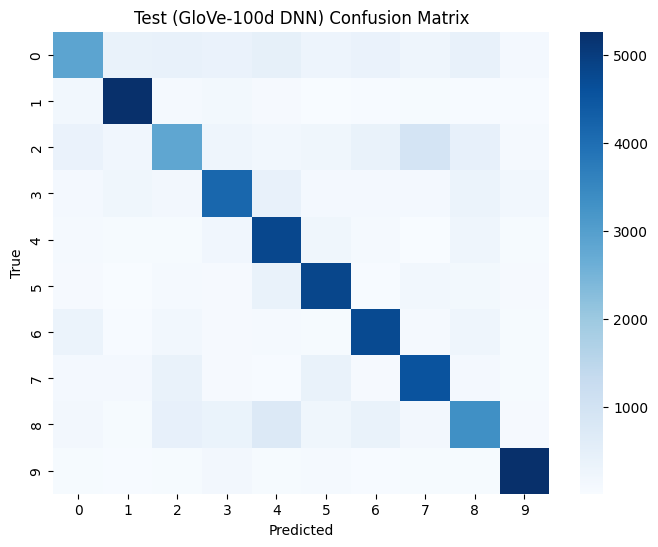

In [ ]:
_ = evaluation_set(model, X_test, y_test, name="Test (GloVe-100d DNN)")

# Final Wrap-Up: Best DNN Model

## Results
- **DNN + GloVe (100d)**  
  - Val Acc: 0.7095 | Test Acc: 0.7110  
  - Val Macro-F1: 0.7034 | Test Macro-F1: 0.7052  
  - Test AUC: 0.9452  

- **DNN + Skip-gram Word2Vec (300d)**  
  - Test Acc: **0.7123**  
  - Test Macro-F1: **0.7065**  
  - Test AUC: 0.9454  

➡ **Best Model:** **DNN + Skip-gram Word2Vec** (slightly higher Acc & F1 than GloVe).

---

## Best Hyperparameters
- **Embedding:** Skip-gram Word2Vec, 300d, window=5, min_count=28, negative=5, epochs=5  
- **Architecture:**  
  - Embedding (trainable=True)  
  - SpatialDropout1D(0.20) → GlobalAveragePooling1D  
  - Dense(768, ReLU, L2=1e-5) → BN → Dropout(0.30)  
  - Dense(384, ReLU, L2=1e-5) → BN → Dropout(0.30)  
  - Dense(10, softmax)  
- **Training:** Adam (lr=3e-4, clipnorm=1.0), batch=256, EarlyStopping(patience=3), class weights  


Skip-gram creates better embeddings for rare/important words → DNN depends on embeddings → so Skip-gram + DNN beats CBOW (Word2Vec default) + DNN.

# Simple RNN With Skipgram and GloVe

In [ ]:
# === RNN + Skip-gram  ===
import numpy as np
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
from sklearn.utils.class_weight import compute_class_weight

# ----- 1) Build embedding matrix from  KeyedVectors -----
lookup = kv_to_lookup(w2v_kv, emb_dim=w2v_kv.vector_size)

# force vocab cap = 20k
NUM_WORDS = 20_000
EMB_DIM   = int(w2v_kv.vector_size)

emb_mat, oov_idx, emb_stats = build_embedding_matrix_from_lookup(
    tok, NUM_WORDS, EMB_DIM, lookup
)
print("Embedding stats:", emb_stats)

# ----- 2) Cap IDs + fix empty rows -----
X_tr   = cap_ids_and_fix_empty(X_tr,   NUM_WORDS, oov_idx)
X_val  = cap_ids_and_fix_empty(X_val,  NUM_WORDS, oov_idx)
X_test = cap_ids_and_fix_empty(X_test, NUM_WORDS, oov_idx)


[KeyedVectors] vector_size = 300
Coverage: 19998/20000 (99.99%)
Embedding stats: {'vocab_size': 20000, 'hits': 19998, 'coverage_pct': 99.99}


In [ ]:
# ----- 3) Model (SimpleRNN head) -----
MAXLEN       = X_tr.shape[1]
NUM_CLASSES  = int(meta.get("num_classes", int(y_tr.max()) + 1))
RNN_UNITS    = 256
L2_REG       = 1e-5

inp = layers.Input(shape=(MAXLEN,), name="ids")
emb = layers.Embedding(input_dim=emb_stats["vocab_size"],
                       output_dim=EMB_DIM,
                       weights=[emb_mat],
                       trainable=True,        # fine-tune skip-gram (as in best DNN setting)
                       mask_zero=True,
                       name="embedding")(inp)
x = layers.SpatialDropout1D(0.20, name="spatial_drop")(emb)
x = layers.SimpleRNN(RNN_UNITS, name="rnn")(x)
x = layers.Dense(384, activation="relu", kernel_regularizer=regularizers.l2(L2_REG), name="dense1")(x)
x = layers.BatchNormalization(name="bn1")(x)
x = layers.Dropout(0.30, name="drop1")(x)
out = layers.Dense(NUM_CLASSES, activation="softmax", name="out")(x)

model = models.Model(inp, out, name="RNN_SkipGram")
opt   = optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "RNN_SkipGram"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ids (InputLayer)    │ (None, 120)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 120, 300)  │  6,000,000 │ ids[0][0]         │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_drop        │ (None, 120, 300)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 120)       │          0 │ ids[0][0]         │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn (SimpleRNN)     │ (None, 256)       │    142,592 │ spatial_drop[0][… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 384)       │     98,688 │ rnn[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 384)       │      1,536 │ dense1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 384)       │          0 │ bn1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 10)        │      3,850 │ drop1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,246,666 (23.83 MB)

 Trainable params: 6,245,898 (23.83 MB)

 Non-trainable params: 768 (3.00 KB)

300d Skip-gram embeddings give strong semantic foundations.

256 RNN units + 384 dense units provide sequence modeling capacity.

Dropouts + L2 + BatchNorm control overfitting.

Adam 3e-4 + clipnorm stabilizes training.

Batch size 256 + early stopping + class weights make training efficient and fair.

In [ ]:
# ----- 4) Class weights (same approach as best DNN) -----
cls = np.unique(y_tr)
cw  = compute_class_weight(class_weight="balanced", classes=cls, y=y_tr)
class_weights = {int(c): float(w) for c, w in zip(cls, cw)}

# ----- 5) Train -----
cbs = [
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy", mode="max"),
    callbacks.ModelCheckpoint(str(OUT_DIR / "rnn_skipgram_best.keras"),
                              save_best_only=True, monitor="val_accuracy", mode="max")
]
hist = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 0.5187 - loss: 1.5500 - val_accuracy: 0.6495 - val_loss: 1.1593
Epoch 2/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.6601 - loss: 1.1035 - val_accuracy: 0.6777 - val_loss: 1.0439
Epoch 3/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.6858 - loss: 1.0252 - val_accuracy: 0.6734 - val_loss: 1.0973
Epoch 4/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.6977 - loss: 0.9895 - val_accuracy: 0.6902 - val_loss: 1.0101
Epoch 5/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7099 - loss: 0.9473 - val_accuracy: 0.6934 - val_loss: 0.9878
Epoch 6/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.7159 - loss: 0.9247 - val_accuracy: 0.6891 - val_loss: 1.0080
Epoch 7/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.7216 - loss: 0.9054 - val_accuracy: 0.6926 - val_loss: 1.0082
Epoch 8/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.7273 - loss: 0.8828 - 

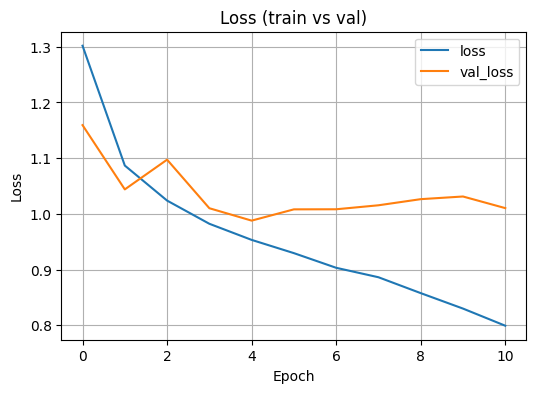

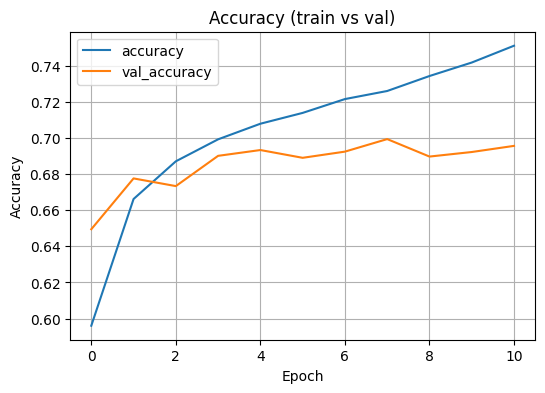

In [ ]:
plot_loss(hist);
plot_acc(hist)


== Validation ==
Val Accuracy: 0.6995 | Macro-F1: 0.6974
              precision    recall  f1-score   support

           0     0.6077    0.4953    0.5458      4193
           1     0.8316    0.8544    0.8429      4197
           2     0.5684    0.4592    0.5080      4196
           3     0.6407    0.7186    0.6774      4240
           4     0.7395    0.7188    0.7290      4186
           5     0.7871    0.7729    0.7800      4228
           6     0.7615    0.7410    0.7511      4162
           7     0.6911    0.7570    0.7226      4206
           8     0.5185    0.6196    0.5645      4182
           9     0.8487    0.8566    0.8526      4211

    accuracy                         0.6995     42001
   macro avg     0.6995    0.6994    0.6974     42001
weighted avg     0.6995    0.6995    0.6975     42001



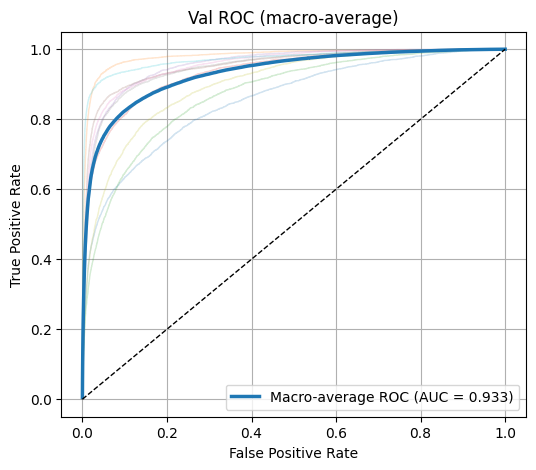

Per-class AUCs:
  Class 0: AUC = 0.8543
  Class 1: AUC = 0.9811
  Class 2: AUC = 0.8723
  Class 3: AUC = 0.9338
  Class 4: AUC = 0.9568
  Class 5: AUC = 0.9547
  Class 6: AUC = 0.9555
  Class 7: AUC = 0.9483
  Class 8: AUC = 0.9003
  Class 9: AUC = 0.9724
Macro-average AUC: 0.9330


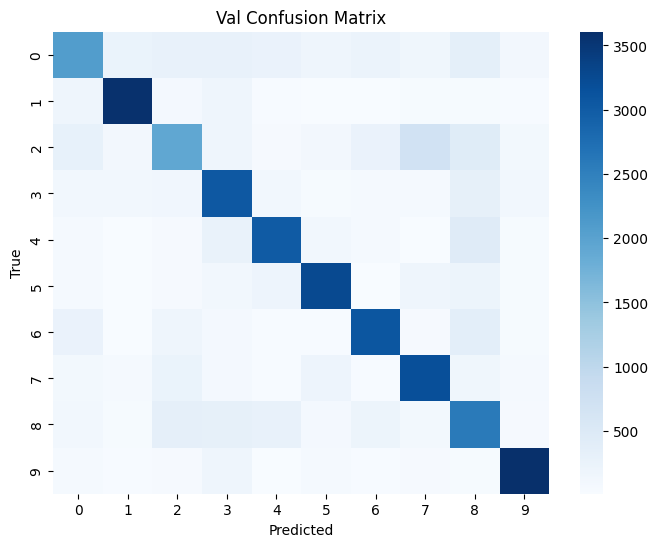

In [ ]:
print("\n== Validation =="); _ = evaluation_set(model, X_val,  y_val,  name="Val")


== Test ==
Test Accuracy: 0.7010 | Macro-F1: 0.6989
              precision    recall  f1-score   support

           0     0.6132    0.5012    0.5515      6000
           1     0.8288    0.8542    0.8413      6000
           2     0.5637    0.4522    0.5018      6000
           3     0.6409    0.7322    0.6835      6000
           4     0.7442    0.7116    0.7276      5999
           5     0.7783    0.7683    0.7733      6000
           6     0.7698    0.7500    0.7598      6000
           7     0.6936    0.7493    0.7204      6000
           8     0.5246    0.6275    0.5715      6000
           9     0.8526    0.8640    0.8583      6000

    accuracy                         0.7010     59999
   macro avg     0.7010    0.7010    0.6989     59999
weighted avg     0.7010    0.7010    0.6989     59999



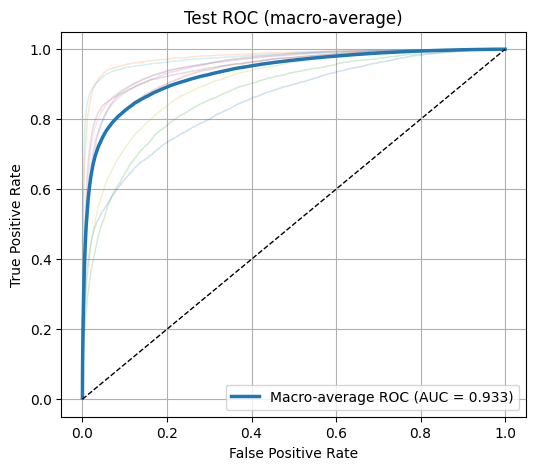

Per-class AUCs:
  Class 0: AUC = 0.8500
  Class 1: AUC = 0.9789
  Class 2: AUC = 0.8704
  Class 3: AUC = 0.9381
  Class 4: AUC = 0.9527
  Class 5: AUC = 0.9514
  Class 6: AUC = 0.9561
  Class 7: AUC = 0.9514
  Class 8: AUC = 0.9023
  Class 9: AUC = 0.9763
Macro-average AUC: 0.9328


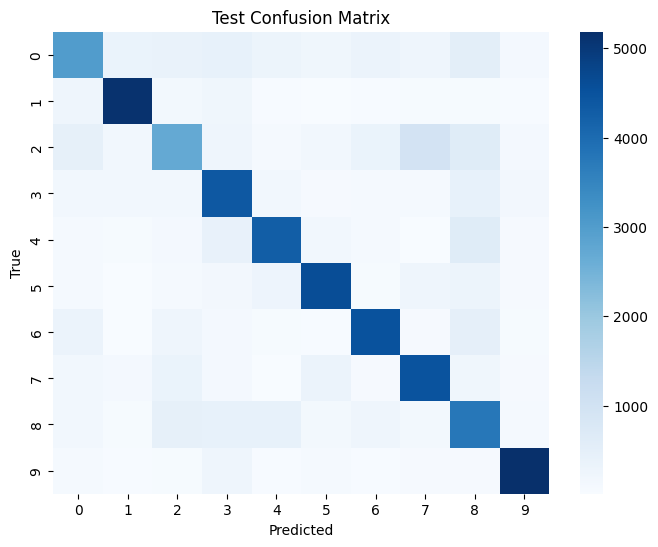

In [ ]:
print("\n== Test ==");       _ = evaluation_set(model, X_test, y_test, name="Test")

In [ ]:
# === RNN + GloVe ===
import numpy as np
from tensorflow.keras import callbacks, optimizers
from sklearn.utils.class_weight import compute_class_weight

# 0) Constants from your Load cell
EMB_DIM     = 100
NUM_WORDS   = min(20_000, int(meta.get("num_words", meta.get("vocab_size", 20_000))))
MAXLEN      = int(meta.get("maxlen", X_tr.shape[1]))
NUM_CLASSES = int(meta.get("num_classes", len(np.unique(y_tr))))

# 1) Load GloVe text and build embedding matrix (top-20k vocab)
g_lookup = load_glove_txt(glove_file, emb_dim=EMB_DIM)  # e.g., '/content/drive/MyDrive/CSE440/glove.6B.100d.txt'
emb_glove, oov_idx_g, emb_stats_g = build_embedding_matrix_from_lookup(
    tok, num_words=NUM_WORDS, emb_dim=EMB_DIM, lookup=g_lookup,
    oov_token=(tok.oov_token or "<unk>")
)
print("GloVe embedding stats:", emb_stats_g)

# 2) Cap IDs + fix empties using GloVe vocab
X_tr_g   = cap_ids_and_fix_empty(X_tr,   emb_stats_g["vocab_size"], oov_idx_g)
X_val_g  = cap_ids_and_fix_empty(X_val,  emb_stats_g["vocab_size"], oov_idx_g)
X_test_g = cap_ids_and_fix_empty(X_test, emb_stats_g["vocab_size"], oov_idx_g)

[GloVe] loaded 400,000 vectors
Coverage: 18784/20000 (93.92%)
GloVe embedding stats: {'vocab_size': 20000, 'hits': 18784, 'coverage_pct': 93.92}


In [ ]:
# 3) Build SimpleRNN classifier (mirrors best DNN regularization)
model_g = build_rnn(
    vocab_size=emb_stats_g["vocab_size"],
    emb_dim=EMB_DIM,
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_glove,
    maxlen=MAXLEN,
    units=256,            # RNN units
    bidirectional=False,  # set True for BiRNN
    trainable=True,
    dropout=0.30
)
model_g.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_g.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 120, 100)  │  2,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 120)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 256)       │     91,392 │ embedding[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      2,570 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,093,962 (7.99 MB)

 Trainable params: 2,093,962 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4) Class weights (balanced)
cls = np.unique(y_tr)
cw  = compute_class_weight(class_weight="balanced", classes=cls, y=y_tr)
class_weights = {int(c): float(w) for c, w in zip(cls, cw)}

# 5) Train with ES + best checkpoint
cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint(str(OUT_DIR / "rnn_glove_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True)
]
hist_g = model_g.fit(
    X_tr_g, y_tr,
    validation_data=(X_val_g, y_val),
    epochs=30,
    batch_size=256,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.4815 - loss: 1.5537 - val_accuracy: 0.6373 - val_loss: 1.1534
Epoch 2/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.6435 - loss: 1.1631 - val_accuracy: 0.6581 - val_loss: 1.1096
Epoch 3/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6676 - loss: 1.0915 - val_accuracy: 0.6677 - val_loss: 1.0858
Epoch 4/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.6812 - loss: 1.0482 - val_accuracy: 0.6727 - val_loss: 1.0554
Epoch 5/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.6879 - loss: 1.0275 - val_accuracy: 0.6749 - val_loss: 1.0483
Epoch 6/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.6991 - loss: 0.9849 - val_accuracy: 0.6793 - val_loss: 1.0451
Epoch 7/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.7055 - loss: 0.9667 - val_accuracy: 0.6853 - val_loss: 1.0263
Epoch 8/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.7100 - loss: 0.9541 - 

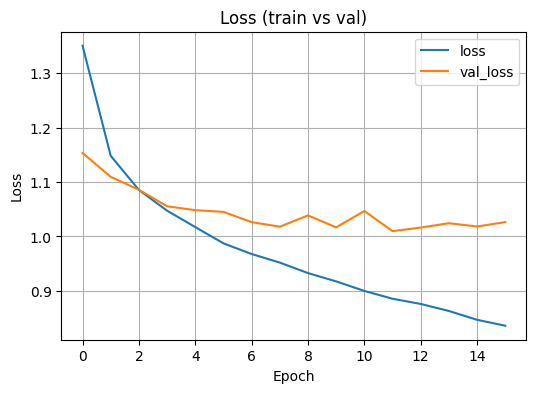

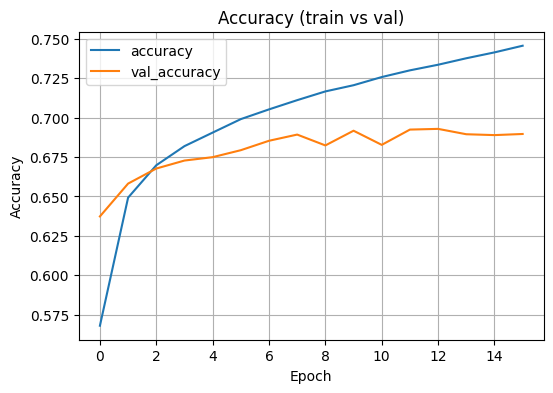

In [ ]:
# 6) Curves + evaluation (your helpers)
plot_loss(hist_g);
plot_acc(hist_g)



== Validation (GloVe-RNN) ==
Val Accuracy: 0.6928 | Macro-F1: 0.6859
              precision    recall  f1-score   support

           0     0.6253    0.4286    0.5086      4193
           1     0.8036    0.8454    0.8240      4197
           2     0.5571    0.4812    0.5164      4196
           3     0.6716    0.6743    0.6729      4240
           4     0.6834    0.7496    0.7150      4186
           5     0.6971    0.8297    0.7577      4228
           6     0.7198    0.7852    0.7511      4162
           7     0.7041    0.7304    0.7170      4206
           8     0.5857    0.5239    0.5531      4182
           9     0.8109    0.8787    0.8434      4211

    accuracy                         0.6928     42001
   macro avg     0.6859    0.6927    0.6859     42001
weighted avg     0.6859    0.6928    0.6860     42001



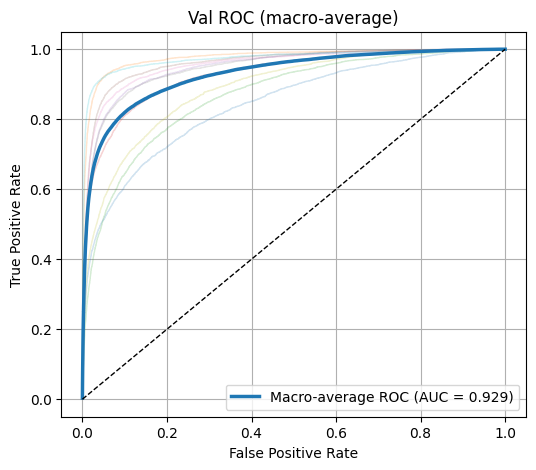

Per-class AUCs:
  Class 0: AUC = 0.8429
  Class 1: AUC = 0.9768
  Class 2: AUC = 0.8688
  Class 3: AUC = 0.9276
  Class 4: AUC = 0.9493
  Class 5: AUC = 0.9617
  Class 6: AUC = 0.9552
  Class 7: AUC = 0.9480
  Class 8: AUC = 0.8892
  Class 9: AUC = 0.9740
Macro-average AUC: 0.9294


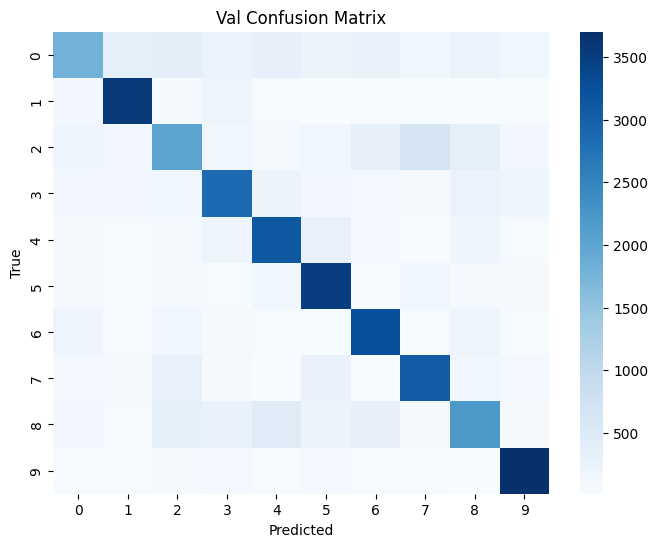

In [ ]:
print("\n== Validation (GloVe-RNN) =="); _ = evaluation_set(model_g, X_val_g,  y_val,  name="Val")


== Test (GloVe-RNN) ==
Test Accuracy: 0.6934 | Macro-F1: 0.6866
              precision    recall  f1-score   support

           0     0.6245    0.4242    0.5052      6000
           1     0.8069    0.8558    0.8306      6000
           2     0.5501    0.4830    0.5144      6000
           3     0.6802    0.6722    0.6762      6000
           4     0.6826    0.7423    0.7112      5999
           5     0.6765    0.8210    0.7418      6000
           6     0.7239    0.7830    0.7523      6000
           7     0.7082    0.7302    0.7190      6000
           8     0.6009    0.5355    0.5663      6000
           9     0.8148    0.8873    0.8495      6000

    accuracy                         0.6934     59999
   macro avg     0.6869    0.6934    0.6866     59999
weighted avg     0.6869    0.6934    0.6866     59999



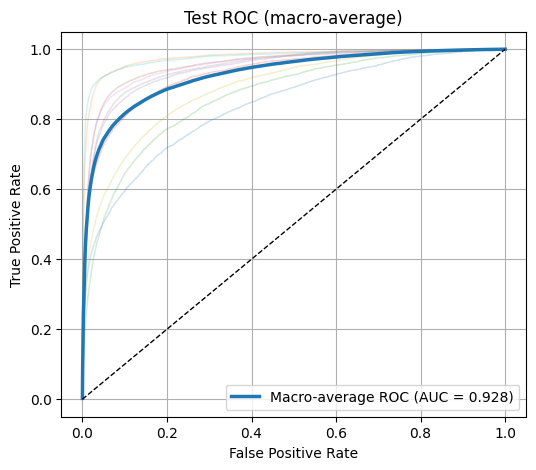

Per-class AUCs:
  Class 0: AUC = 0.8392
  Class 1: AUC = 0.9773
  Class 2: AUC = 0.8657
  Class 3: AUC = 0.9309
  Class 4: AUC = 0.9453
  Class 5: AUC = 0.9579
  Class 6: AUC = 0.9539
  Class 7: AUC = 0.9481
  Class 8: AUC = 0.8886
  Class 9: AUC = 0.9768
Macro-average AUC: 0.9284


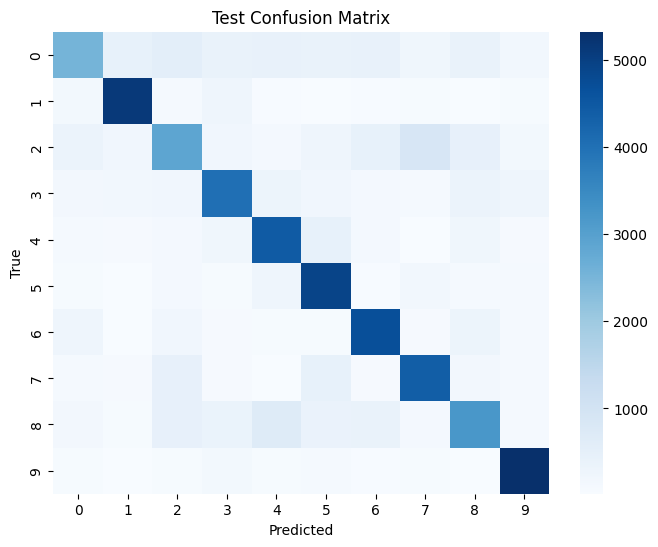

In [ ]:
print("\n== Test (GloVe-RNN) ==");       _ = evaluation_set(model_g, X_test_g, y_test, name="Test")

# Bidirectional RNN With Skipgram and GloVe

In [ ]:
# === BiRNN + Skip-gram (build, compile, summary) ===
from tensorflow.keras import callbacks, optimizers


EMB_DIM_SG = int(emb_mat.shape[1])
VOCAB_SG   = int(emb_stats["vocab_size"])

model_sg_birnn = build_rnn(
    vocab_size=VOCAB_SG,
    emb_dim=EMB_DIM_SG,
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat,
    maxlen=MAXLEN,
    units=256,             # same as SimpleRNN baseline
    bidirectional=True,    # ← BiRNN
    trainable=True,
    dropout=0.30
)

model_sg_birnn.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_sg_birnn.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 120, 300)  │  6,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 120)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │    285,184 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      5,130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,290,314 (24.00 MB)

 Trainable params: 6,290,314 (24.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train + save best
from sklearn.utils.class_weight import compute_class_weight
cls = np.unique(y_tr)
class_weights = {int(c): float(w) for c, w in zip(cls, compute_class_weight("balanced", classes=cls, y=y_tr))}

cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint(str(OUT_DIR / "birnn_skipgram_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True)
]

hist_bi = model_sg_birnn.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)





Epoch 1/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 64s 62ms/step - accuracy: 0.6122 - loss: 1.1906 - val_accuracy: 0.7021 - val_loss: 0.9277
Epoch 2/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - accuracy: 0.7147 - loss: 0.8943 - val_accuracy: 0.7070 - val_loss: 0.9159
Epoch 3/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.7393 - loss: 0.8173 - val_accuracy: 0.7087 - val_loss: 0.9141
Epoch 4/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.7652 - loss: 0.7317 - val_accuracy: 0.6961 - val_loss: 0.9585
Epoch 5/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - accuracy: 0.8051 - loss: 0.6093 - val_accuracy: 0.6787 - val_loss: 1.0461
Epoch 6/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.8556 - loss: 0.4599 - val_accuracy: 0.6670 - val_loss: 1.1810


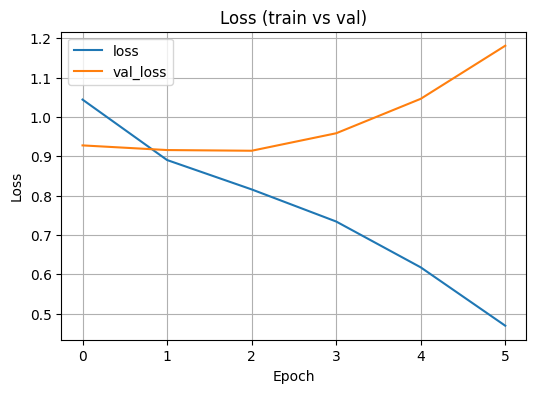

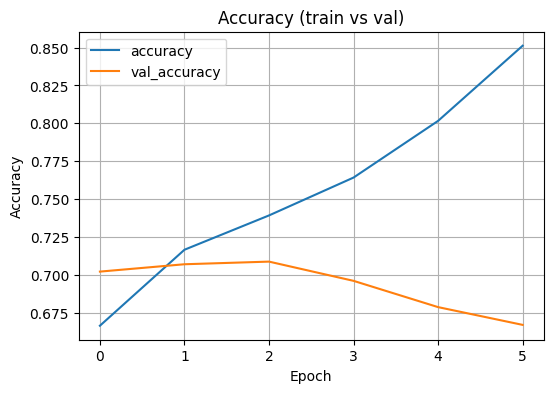

In [ ]:
plot_loss(hist_bi)
plot_acc(hist_bi)


== Validation (BiRNN-SG) ==
Val BiRNN Skipgram Accuracy: 0.7087 | Macro-F1: 0.7033
              precision    recall  f1-score   support

           0     0.6231    0.4593    0.5288      4193
           1     0.8060    0.8840    0.8432      4197
           2     0.6021    0.4573    0.5198      4196
           3     0.6958    0.6920    0.6939      4240
           4     0.6902    0.7845    0.7343      4186
           5     0.7733    0.7897    0.7814      4228
           6     0.7349    0.7886    0.7608      4162
           7     0.6809    0.7718    0.7235      4206
           8     0.5658    0.5995    0.5821      4182
           9     0.8698    0.8599    0.8648      4211

    accuracy                         0.7087     42001
   macro avg     0.7042    0.7087    0.7033     42001
weighted avg     0.7043    0.7087    0.7034     42001



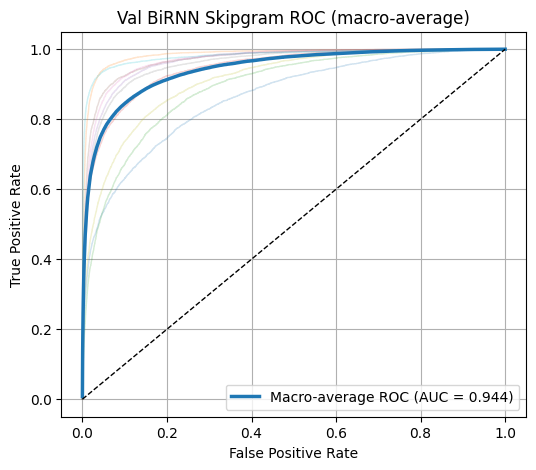

Per-class AUCs:
  Class 0: AUC = 0.8616
  Class 1: AUC = 0.9848
  Class 2: AUC = 0.8898
  Class 3: AUC = 0.9448
  Class 4: AUC = 0.9642
  Class 5: AUC = 0.9707
  Class 6: AUC = 0.9694
  Class 7: AUC = 0.9580
  Class 8: AUC = 0.9114
  Class 9: AUC = 0.9813
Macro-average AUC: 0.9436


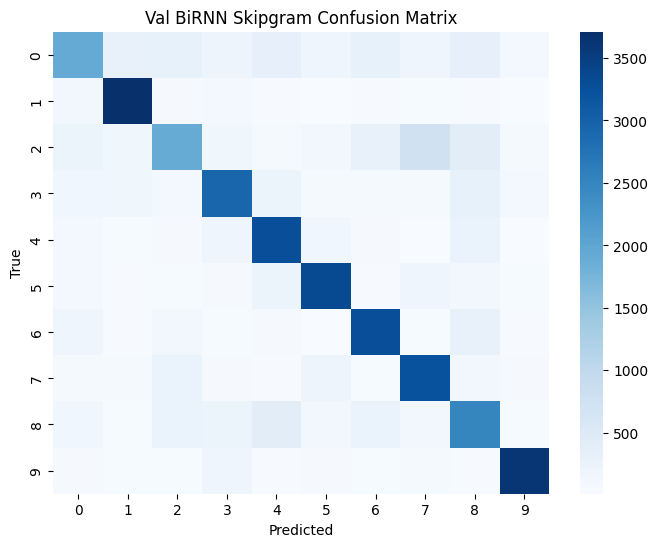

In [ ]:
print("\n== Validation (BiRNN-SG) ==")
_ = evaluation_set(model_sg_birnn, X_val,  y_val,  name="Val BiRNN Skipgram")


== Test (BiRNN-SG) ==
Test BiRnn Skipgram Accuracy: 0.7104 | Macro-F1: 0.7049
              precision    recall  f1-score   support

           0     0.6257    0.4645    0.5332      6000
           1     0.8065    0.8828    0.8429      6000
           2     0.6018    0.4482    0.5138      6000
           3     0.7004    0.7007    0.7005      6000
           4     0.6910    0.7836    0.7344      5999
           5     0.7598    0.7917    0.7754      6000
           6     0.7448    0.7913    0.7674      6000
           7     0.6848    0.7727    0.7261      6000
           8     0.5680    0.6038    0.5853      6000
           9     0.8750    0.8645    0.8697      6000

    accuracy                         0.7104     59999
   macro avg     0.7058    0.7104    0.7049     59999
weighted avg     0.7058    0.7104    0.7049     59999



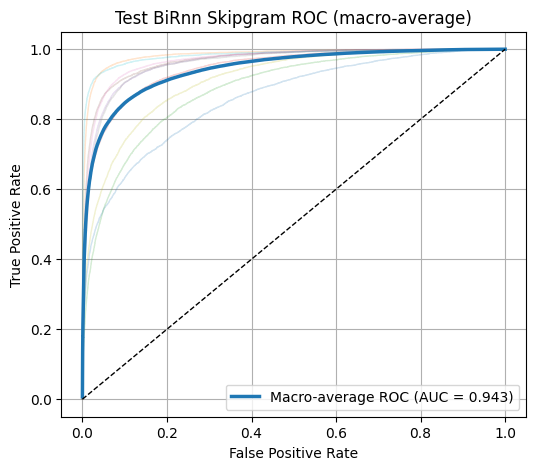

Per-class AUCs:
  Class 0: AUC = 0.8586
  Class 1: AUC = 0.9840
  Class 2: AUC = 0.8856
  Class 3: AUC = 0.9457
  Class 4: AUC = 0.9624
  Class 5: AUC = 0.9682
  Class 6: AUC = 0.9688
  Class 7: AUC = 0.9598
  Class 8: AUC = 0.9124
  Class 9: AUC = 0.9829
Macro-average AUC: 0.9428


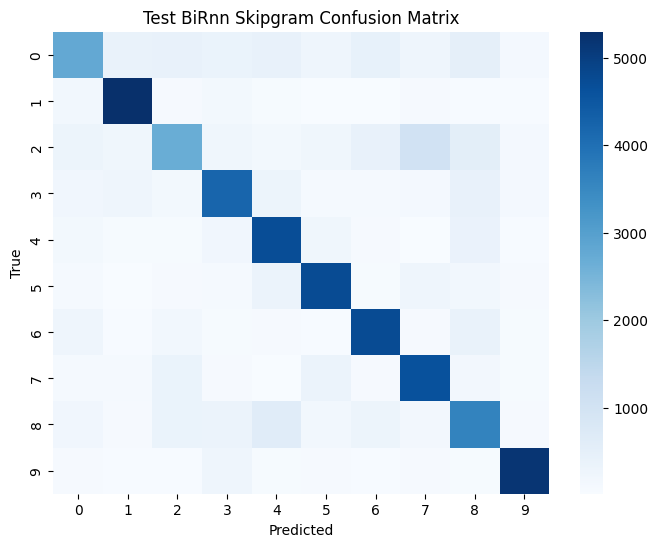

In [ ]:
print("\n== Test (BiRNN-SG) ==");
_ = evaluation_set(model_sg_birnn, X_test, y_test, name="Test BiRnn Skipgram")

In [ ]:
# === BiRNN + GloVe (build, compile, summary) ===

model_g_birnn = build_rnn(
    vocab_size=emb_stats_g["vocab_size"],
    emb_dim=EMB_DIM,
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_glove,
    maxlen=MAXLEN,
    units=256,            # RNN units
    bidirectional=True,  # set True for BiRNN
    trainable=True,
    dropout=0.30
)
model_g_birnn.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_g_birnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 120, 100)  │  2,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 120)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │    182,784 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      5,130 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,187,914 (8.35 MB)

 Trainable params: 2,187,914 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

cls = np.unique(y_tr)
cw  = compute_class_weight(class_weight="balanced", classes=cls, y=y_tr)
class_weights = {int(c): float(w) for c, w in zip(cls, cw)}


cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint(str(OUT_DIR / "rnn_glove_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True)
]
hist_g_birnn = model_g_birnn.fit(
    X_tr_g, y_tr,
    validation_data=(X_val_g, y_val),
    epochs=30,
    batch_size=256,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - accuracy: 0.5358 - loss: 1.4016 - val_accuracy: 0.6597 - val_loss: 1.0500
Epoch 2/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 76s 39ms/step - accuracy: 0.6692 - loss: 1.0352 - val_accuracy: 0.6810 - val_loss: 0.9969
Epoch 3/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.6938 - loss: 0.9620 - val_accuracy: 0.6926 - val_loss: 0.9644
Epoch 4/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.7086 - loss: 0.9133 - val_accuracy: 0.6969 - val_loss: 0.9454
Epoch 5/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.7215 - loss: 0.8769 - val_accuracy: 0.7006 - val_loss: 0.9344
Epoch 6/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.7307 - loss: 0.8453 - val_accuracy: 0.7001 - val_loss: 0.9361
Epoch 7/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.7370 - loss: 0.8217 - val_accuracy: 0.7019 - val_loss: 0.9337
Epoch 8/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.7460 - loss: 0.7948 - 

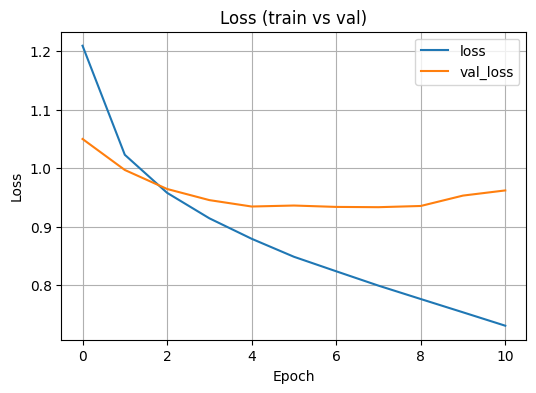

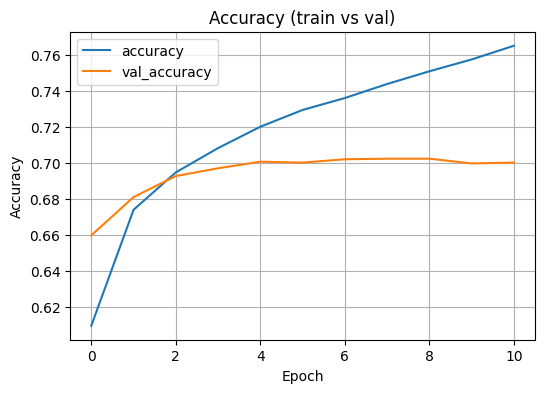

In [ ]:
plot_loss(hist_g_birnn)
plot_acc(hist_g_birnn)


== Validation (BiRNN-GloVe) ==
Val BiRNN GloVe Accuracy: 0.7022 | Macro-F1: 0.6988
              precision    recall  f1-score   support

           0     0.5600    0.5020    0.5294      4193
           1     0.7975    0.8823    0.8378      4197
           2     0.5350    0.5296    0.5323      4196
           3     0.7069    0.6833    0.6949      4240
           4     0.6879    0.7697    0.7265      4186
           5     0.7510    0.7916    0.7708      4228
           6     0.7587    0.7554    0.7570      4162
           7     0.6924    0.7392    0.7150      4206
           8     0.6266    0.5072    0.5606      4182
           9     0.8656    0.8608    0.8632      4211

    accuracy                         0.7022     42001
   macro avg     0.6982    0.7021    0.6988     42001
weighted avg     0.6983    0.7022    0.6989     42001



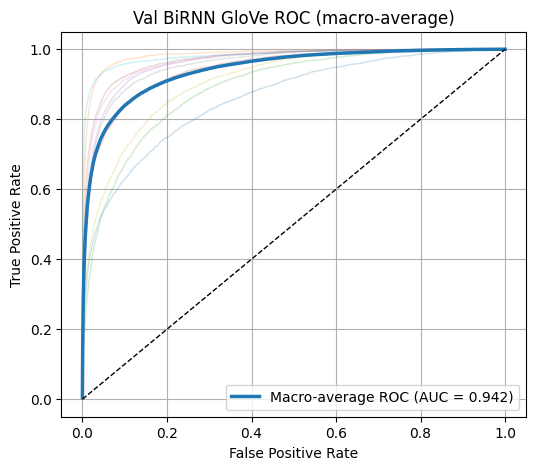

Per-class AUCs:
  Class 0: AUC = 0.8594
  Class 1: AUC = 0.9837
  Class 2: AUC = 0.8896
  Class 3: AUC = 0.9430
  Class 4: AUC = 0.9613
  Class 5: AUC = 0.9691
  Class 6: AUC = 0.9661
  Class 7: AUC = 0.9558
  Class 8: AUC = 0.9081
  Class 9: AUC = 0.9810
Macro-average AUC: 0.9417


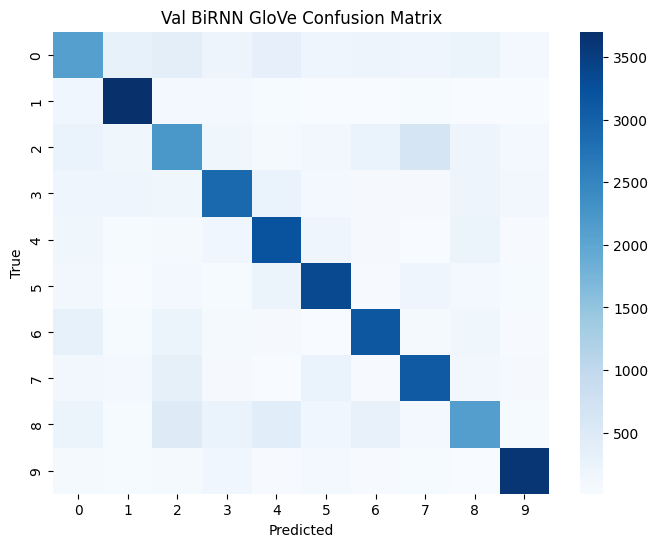

In [ ]:
print("\n== Validation (BiRNN-GloVe) ==")
_ = evaluation_set(model_g_birnn, X_val,  y_val,  name="Val BiRNN GloVe")


== Test (BiRNN- GloVe) ==
Test BiRnn GloVe Accuracy: 0.7043 | Macro-F1: 0.7012
              precision    recall  f1-score   support

           0     0.5603    0.5007    0.5288      6000
           1     0.7960    0.8872    0.8391      6000
           2     0.5298    0.5378    0.5338      6000
           3     0.6986    0.6812    0.6898      6000
           4     0.6976    0.7600    0.7275      5999
           5     0.7447    0.7933    0.7682      6000
           6     0.7673    0.7530    0.7601      6000
           7     0.7010    0.7387    0.7194      6000
           8     0.6394    0.5210    0.5742      6000
           9     0.8723    0.8700    0.8712      6000

    accuracy                         0.7043     59999
   macro avg     0.7007    0.7043    0.7012     59999
weighted avg     0.7007    0.7043    0.7012     59999



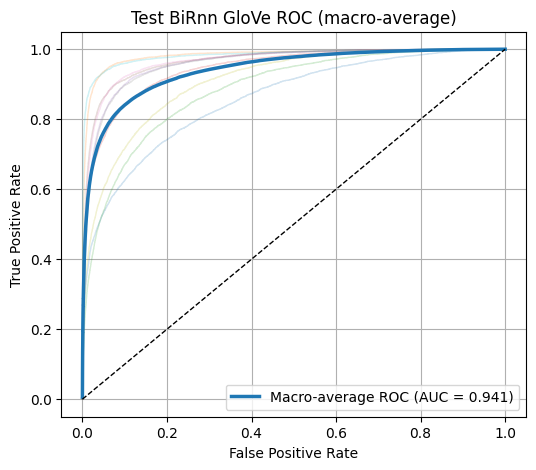

Per-class AUCs:
  Class 0: AUC = 0.8570
  Class 1: AUC = 0.9825
  Class 2: AUC = 0.8846
  Class 3: AUC = 0.9442
  Class 4: AUC = 0.9601
  Class 5: AUC = 0.9668
  Class 6: AUC = 0.9662
  Class 7: AUC = 0.9581
  Class 8: AUC = 0.9091
  Class 9: AUC = 0.9827
Macro-average AUC: 0.9411


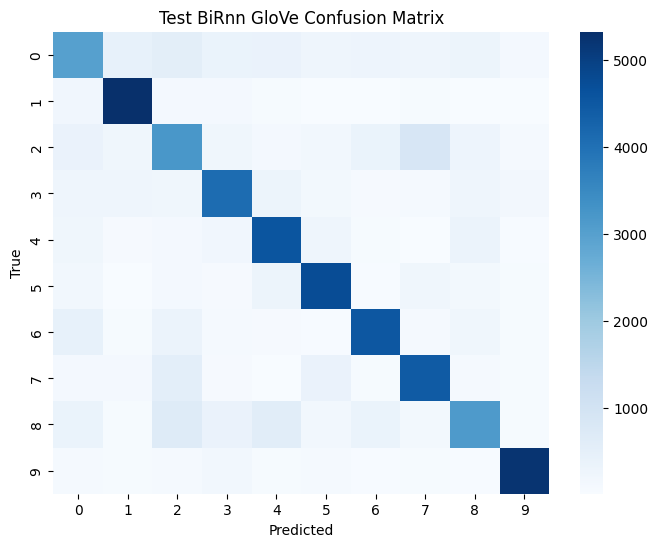

In [ ]:
print("\n== Test (BiRNN- GloVe) ==");
_ = evaluation_set(model_g_birnn, X_test, y_test, name="Test BiRnn GloVe")

Last-state bottleneck: RNN only looks at the final step, missing info from earlier words; DNN looks at all words.

Task type: The task cares more about which words appear, not their order—DNN handles this better.

No gates: Simple RNNs can’t remember long-range info well like LSTM/GRU can.

✅ That’s why the best RNN didn’t beat the DNN.

Return_sequences
True → output at every timestep; False → only last timestep. Important for stacking layers or pooling.

#  RNN Results (Skip-gram & GloVe) — Wrap-Up

| Model                          | Val Acc | Test Acc | Test Macro-F1 |
|-------------------------------|:-------:|:--------:|:-------------:|
| **BiRNN + Skip-gram**         | 0.7087  | **0.7104** | **0.7049** |
| BiRNN + GloVe-100d         | 0.7022  | 0.7043   | 0.7012 |
| SimpleRNN + Skip-gram         | 0.6995  | 0.7010   | 0.6989 |
| SimpleRNN + GloVe-100d        | 0.6928  | 0.6934   | 0.6866 |

**Best RNN:** **Bidirectional SimpleRNN + Skip-gram** (Test **Acc 0.7104**, **Macro-F1 0.7049**)


---

## Why best RNN didn’t beat the DNN
- **Last-state bottleneck:** Bi(Simple)RNN used final state only → earlier tokens underweighted; DNN’s **mean pooling** keeps signal from all tokens.
- **Inductive bias:** Task leans on **word presence** more than strict order → DNN’s **order-invariant** pooling fits better.
- **No gates:** SimpleRNN (even bidirectional) lacks LSTM/GRU gates to retain long-range info and stabilize gradients.

---

## Quick path to improve Models
- Use **GRU/LSTM** with `return_sequences=True` + **GlobalAverage/MaxPooling1D** to aggregate **all** timesteps.
- Keep our regularization knobs (BN + Dropout + L2), **clipnorm=1.0**, consider batch **128** and `recurrent_dropout=0.1–0.2`.


GlobalAveragePooling1D / MaxPooling1D → Combines all time-step outputs into one vector, so the model sees the whole sequence.

clipnorm=1.0 → Limits gradient size to prevent exploding gradients.


recurrent_dropout=0.1–0.2 → Randomly drops some RNN connections to avoid overfitting.

# LSTM With Skipgram and GloVe

In [ ]:
# === LSTM + Skip-gram (using our helpers) — hypertune to beat DNN/RNN ===

import numpy as np
from tensorflow.keras import callbacks, optimizers, losses
from sklearn.utils.class_weight import compute_class_weight

# 1) Build 20k Skip-gram embedding + cap IDs
NUM_WORDS = 20_000
EMB_DIM   = int(w2v_kv.vector_size)

lookup = kv_to_lookup(w2v_kv, emb_dim=EMB_DIM)
emb_mat, oov_idx, emb_stats = build_embedding_matrix_from_lookup(
    tok, num_words=NUM_WORDS, emb_dim=EMB_DIM, lookup=lookup,
    oov_token=(tok.oov_token or "<unk>")
)
X_tr_sg   = cap_ids_and_fix_empty(X_tr,   emb_stats["vocab_size"], oov_idx)
X_val_sg  = cap_ids_and_fix_empty(X_val,  emb_stats["vocab_size"], oov_idx)
X_test_sg = cap_ids_and_fix_empty(X_test, emb_stats["vocab_size"], oov_idx)

MAXLEN      = int(meta.get("maxlen", X_tr.shape[1]))
NUM_CLASSES = int(meta.get("num_classes", np.unique(y_tr).size))

[KeyedVectors] vector_size = 300
Coverage: 19998/20000 (99.99%)


In [ ]:
#Minor Bug Fix

def to_right_padded(X):
    """Move nonzero tokens to the left; pad with zeros on the right."""
    Xr = np.zeros_like(X)
    for i in range(X.shape[0]):
        nz = X[i][X[i] != 0]
        Xr[i, :len(nz)] = nz
    return Xr

# Apply after cap_ids_and_fix_empty(...)
X_tr_sg  = to_right_padded(X_tr_sg)
X_val_sg = to_right_padded(X_val_sg)
X_test_sg= to_right_padded(X_test_sg)


In [ ]:
# 1) Rebuild with a bit more capacity & dropout
model_lstm_sg = build_lstm(
    vocab_size=emb_stats["vocab_size"],
    emb_dim=emb_mat.shape[1],
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat,
    maxlen=MAXLEN,
    units=384,            # ↑ from 320 → more expressiveness
    bidirectional=False,
    trainable=True,
    dropout=0.35          # a touch more regularization
)

In [ ]:

model_lstm_sg.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),  # lr + clipnorm as decided
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_lstm_sg.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 120, 300)  │  6,000,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 120)       │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 384)       │  1,052,160 │ embedding_5[0][0… │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 384)       │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │      3,850 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,056,010 (26.92 MB)

 Trainable params: 7,056,010 (26.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# 3) Callbacks: EarlyStopping + LR decay + best checkpoint
cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(str(OUT_DIR / "lstm_skipgram_tuned_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True),
]

In [ ]:
# 4) Train (

hist = model_lstm_sg.fit(
    X_tr_sg, y_tr,
    validation_data=(X_val_sg, y_val),
    epochs=30,
    batch_size=128,      # smaller batch → better RNN generalization
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 55s 27ms/step - accuracy: 0.6415 - loss: 1.1419 - val_accuracy: 0.7095 - val_loss: 0.9061 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 79s 26ms/step - accuracy: 0.7311 - loss: 0.8485 - val_accuracy: 0.7171 - val_loss: 0.8724 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.7510 - loss: 0.7746 - val_accuracy: 0.7169 - val_loss: 0.8769 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.7670 - loss: 0.7155 - val_accuracy: 0.7161 - val_loss: 0.8972 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.7907 - loss: 0.6365 - val_accuracy: 0.7112 - val_loss: 0.9331 - learning_rate: 2.5000e-04
Epoch 6/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - accuracy: 0.8031 - loss: 0.5938 - val_accuracy: 0.7052 - val_loss: 0.9871 - learning_rate: 2.5000e-04


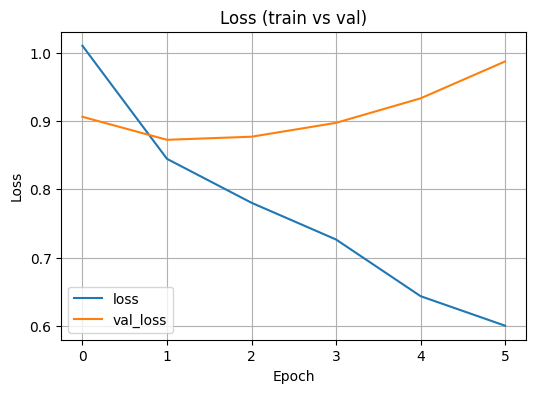

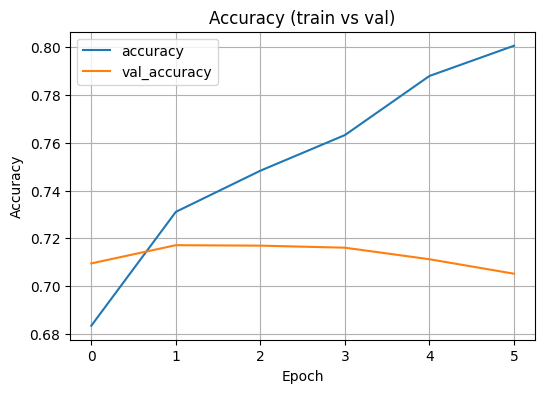

In [ ]:
# 5) Curves + evaluation
plot_loss(hist); plot_acc(hist)



== Validation (LSTM + Skip-gram) ==
Val Accuracy: 0.7171 | Macro-F1: 0.7122
              precision    recall  f1-score   support

           0     0.6500    0.4820    0.5535      4193
           1     0.7740    0.9109    0.8369      4197
           2     0.5972    0.4907    0.5387      4196
           3     0.7163    0.6818    0.6986      4240
           4     0.7369    0.7494    0.7431      4186
           5     0.7774    0.7994    0.7882      4228
           6     0.7543    0.7790    0.7664      4162
           7     0.6825    0.7772    0.7268      4206
           8     0.5792    0.6184    0.5981      4182
           9     0.8611    0.8815    0.8712      4211

    accuracy                         0.7171     42001
   macro avg     0.7129    0.7170    0.7122     42001
weighted avg     0.7130    0.7171    0.7123     42001



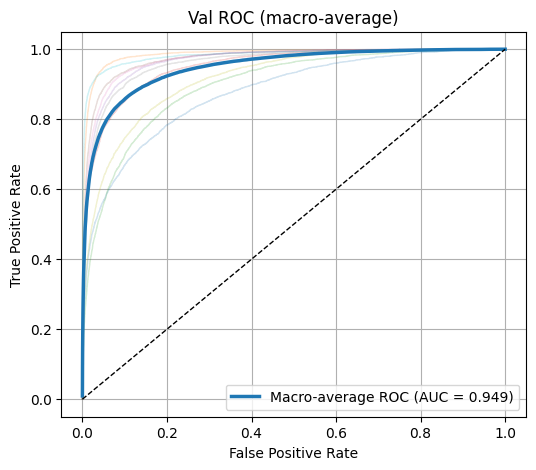

Per-class AUCs:
  Class 0: AUC = 0.8768
  Class 1: AUC = 0.9862
  Class 2: AUC = 0.8976
  Class 3: AUC = 0.9511
  Class 4: AUC = 0.9677
  Class 5: AUC = 0.9738
  Class 6: AUC = 0.9713
  Class 7: AUC = 0.9612
  Class 8: AUC = 0.9168
  Class 9: AUC = 0.9831
Macro-average AUC: 0.9486


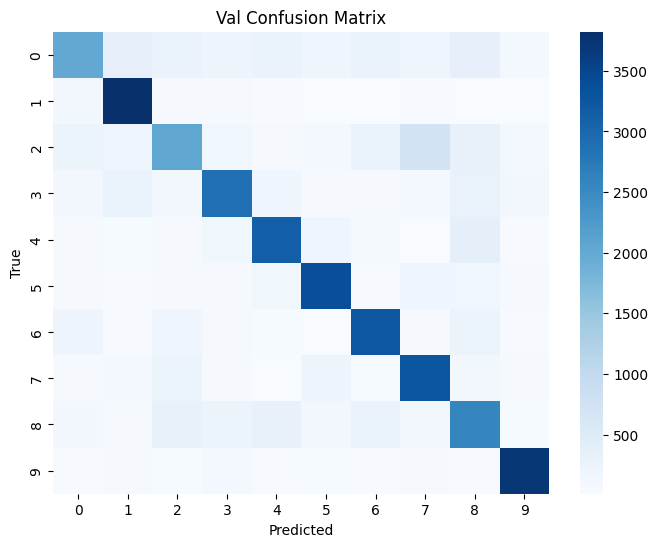

In [ ]:
print("\n== Validation (LSTM + Skip-gram) ==")
_ = evaluation_set(model_lstm_sg, X_val_sg,  y_val,  name="Val")


== Test (Best LSTM + Skip-gram) ==
Test Accuracy: 0.7192 | Macro-F1: 0.7144
              precision    recall  f1-score   support

           0     0.6612    0.4798    0.5561      6000
           1     0.7712    0.9052    0.8328      6000
           2     0.5947    0.4950    0.5403      6000
           3     0.7194    0.6917    0.7052      6000
           4     0.7393    0.7445    0.7419      5999
           5     0.7679    0.7950    0.7812      6000
           6     0.7639    0.7883    0.7759      6000
           7     0.6923    0.7783    0.7328      6000
           8     0.5817    0.6297    0.6047      6000
           9     0.8620    0.8842    0.8730      6000

    accuracy                         0.7192     59999
   macro avg     0.7154    0.7192    0.7144     59999
weighted avg     0.7154    0.7192    0.7144     59999



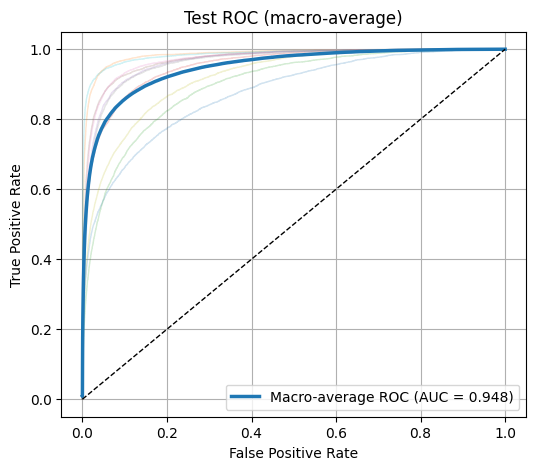

Per-class AUCs:
  Class 0: AUC = 0.8734
  Class 1: AUC = 0.9851
  Class 2: AUC = 0.8967
  Class 3: AUC = 0.9529
  Class 4: AUC = 0.9648
  Class 5: AUC = 0.9713
  Class 6: AUC = 0.9708
  Class 7: AUC = 0.9622
  Class 8: AUC = 0.9192
  Class 9: AUC = 0.9849
Macro-average AUC: 0.9482


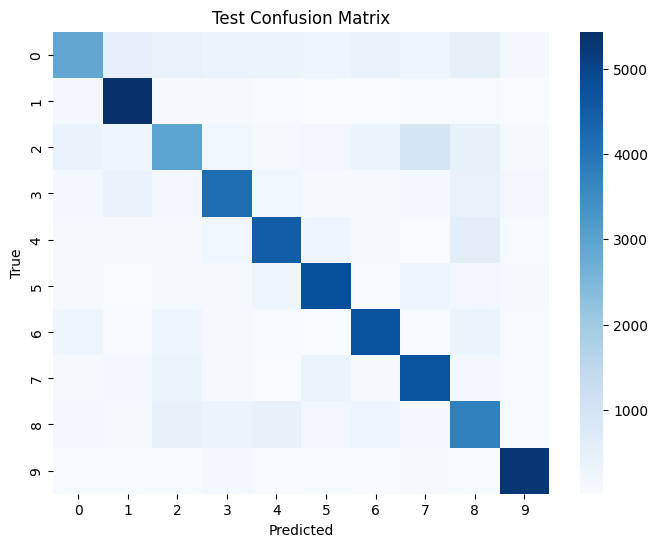

In [ ]:
print("\n== Test (Best LSTM + Skip-gram) ==")
_ = evaluation_set(model_lstm_sg, X_test_sg, y_test, name="Test")

In [ ]:
#LSTM + GloVe

# 1) Build 20k GloVe embedding + cap IDs
EMB_DIM   = 100
NUM_WORDS = 20_000
g_lookup  = load_glove_txt(glove_file, emb_dim=EMB_DIM)

emb_mat_g, oov_idx_g, emb_stats_g = build_embedding_matrix_from_lookup(
    tok, num_words=NUM_WORDS, emb_dim=EMB_DIM, lookup=g_lookup,
    oov_token=(tok.oov_token or "<unk>")
)
print("GloVe embedding stats:", emb_stats_g)

X_tr_g   = cap_ids_and_fix_empty(X_tr,   emb_stats_g["vocab_size"], oov_idx_g)
X_val_g  = cap_ids_and_fix_empty(X_val,  emb_stats_g["vocab_size"], oov_idx_g)
X_test_g = cap_ids_and_fix_empty(X_test, emb_stats_g["vocab_size"], oov_idx_g)

# Minor Bug Fixer
try:
    X_tr_g, X_val_g, X_test_g = to_right_padded(X_tr_g), to_right_padded(X_val_g), to_right_padded(X_test_g)
except NameError:
    pass

MAXLEN      = int(meta.get("maxlen", X_tr.shape[1]))
NUM_CLASSES = int(meta.get("num_classes", np.unique(y_tr).size))

[GloVe] loaded 400,000 vectors
Coverage: 18784/20000 (93.92%)
GloVe embedding stats: {'vocab_size': 20000, 'hits': 18784, 'coverage_pct': 93.92}


In [ ]:
# 2) Model via our builder (same tuned knobs as LSTM+SG)
model_lstm_glove = build_lstm(
    vocab_size=emb_stats_g["vocab_size"],
    emb_dim=EMB_DIM,
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat_g,
    maxlen=MAXLEN,
    units=384,            # ↑ capacity
    bidirectional=False,  # plain LSTM (per plan)
    trainable=True,
    dropout=0.35          # a bit more regularization
)
model_lstm_glove.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_lstm_glove.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 120, 100)  │  2,000,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 120)       │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 384)       │    744,960 │ embedding_6[0][0… │
│                     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 384)       │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │      3,850 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,748,810 (10.49 MB)

 Trainable params: 2,748,810 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# 3) Class weights + callbacks
cls = np.unique(y_tr)
class_weights = {int(c): float(w) for c, w in zip(cls, compute_class_weight("balanced", classes=cls, y=y_tr))}

cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(str(OUT_DIR / "lstm_glove_tuned_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True),
]

In [ ]:
# 4) Train (same batch size as SG run)
hist = model_lstm_glove.fit(
    X_tr_g, y_tr,
    validation_data=(X_val_g, y_val),
    epochs=30,
    batch_size=128,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.6109 - loss: 1.2206 - val_accuracy: 0.6986 - val_loss: 0.9379 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.7108 - loss: 0.9059 - val_accuracy: 0.7133 - val_loss: 0.8841 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7322 - loss: 0.8325 - val_accuracy: 0.7175 - val_loss: 0.8739 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.7454 - loss: 0.7881 - val_accuracy: 0.7191 - val_loss: 0.8685 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7583 - loss: 0.7449 - val_accuracy: 0.7177 - val_loss: 0.8731 - learning_rate: 5.0000e-04
Epoch 6/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.7694 - loss: 0.7033 - val_accuracy: 0.7163 - val_loss: 0.8907 - learning_rate: 5.0000e-04
Epoch 7/30
1860/1860 ━━━━━━━━━━━━━━━━━━━

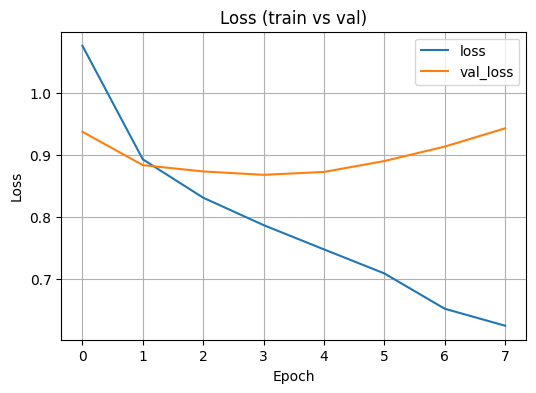

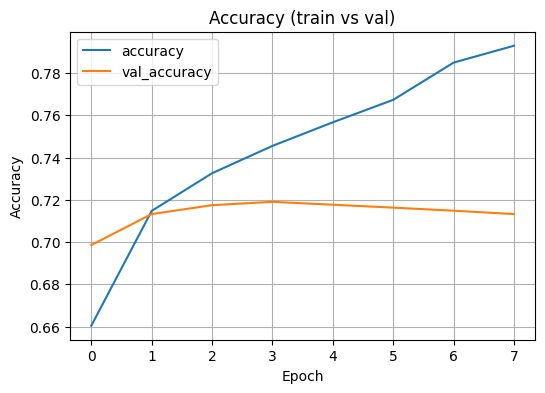

In [ ]:
# 5) Curves + evaluation
plot_loss(hist); plot_acc(hist)


== Validation (LSTM + GloVe) ==
Val Accuracy: 0.7191 | Macro-F1: 0.7142
              precision    recall  f1-score   support

           0     0.6392    0.4973    0.5594      4193
           1     0.8148    0.8918    0.8516      4197
           2     0.6080    0.4898    0.5425      4196
           3     0.6759    0.7300    0.7019      4240
           4     0.6897    0.7981    0.7400      4186
           5     0.7921    0.7822    0.7871      4228
           6     0.7459    0.7785    0.7618      4162
           7     0.6852    0.7844    0.7314      4206
           8     0.6173    0.5696    0.5925      4182
           9     0.8807    0.8677    0.8742      4211

    accuracy                         0.7191     42001
   macro avg     0.7149    0.7189    0.7142     42001
weighted avg     0.7150    0.7191    0.7143     42001



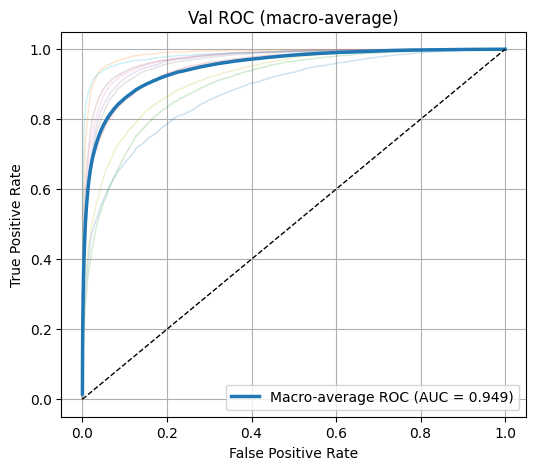

Per-class AUCs:
  Class 0: AUC = 0.8788
  Class 1: AUC = 0.9866
  Class 2: AUC = 0.8991
  Class 3: AUC = 0.9501
  Class 4: AUC = 0.9673
  Class 5: AUC = 0.9738
  Class 6: AUC = 0.9710
  Class 7: AUC = 0.9625
  Class 8: AUC = 0.9176
  Class 9: AUC = 0.9839
Macro-average AUC: 0.9491


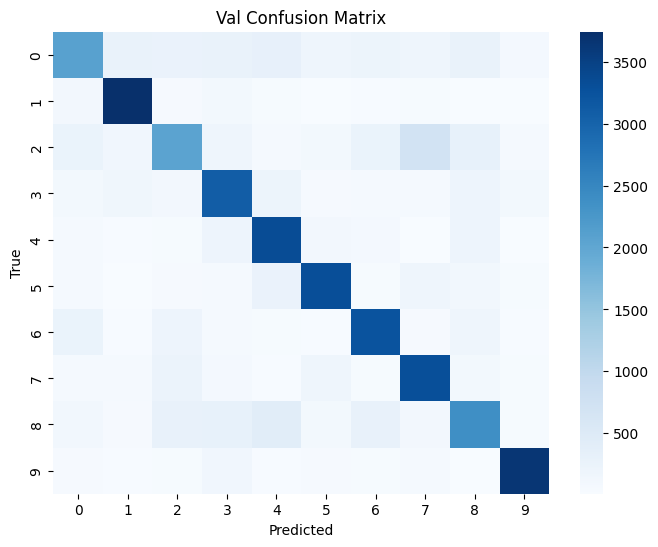

In [ ]:
print("\n== Validation (LSTM + GloVe) =="); _ = evaluation_set(model_lstm_glove, X_val_g,  y_val,  name="Val")


== Test (LSTM + GloVe) ==
Test Accuracy: 0.7209 | Macro-F1: 0.7163
              precision    recall  f1-score   support

           0     0.6412    0.4980    0.5606      6000
           1     0.8132    0.8860    0.8480      6000
           2     0.6051    0.4893    0.5411      6000
           3     0.6759    0.7447    0.7086      6000
           4     0.6919    0.7931    0.7390      5999
           5     0.7807    0.7780    0.7794      6000
           6     0.7605    0.7838    0.7720      6000
           7     0.6942    0.7853    0.7369      6000
           8     0.6191    0.5777    0.5977      6000
           9     0.8862    0.8735    0.8798      6000

    accuracy                         0.7209     59999
   macro avg     0.7168    0.7209    0.7163     59999
weighted avg     0.7168    0.7209    0.7163     59999



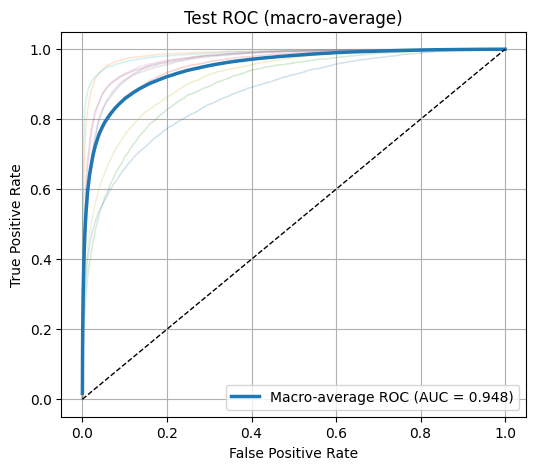

Per-class AUCs:
  Class 0: AUC = 0.8726
  Class 1: AUC = 0.9854
  Class 2: AUC = 0.8967
  Class 3: AUC = 0.9525
  Class 4: AUC = 0.9655
  Class 5: AUC = 0.9721
  Class 6: AUC = 0.9714
  Class 7: AUC = 0.9633
  Class 8: AUC = 0.9193
  Class 9: AUC = 0.9858
Macro-average AUC: 0.9485


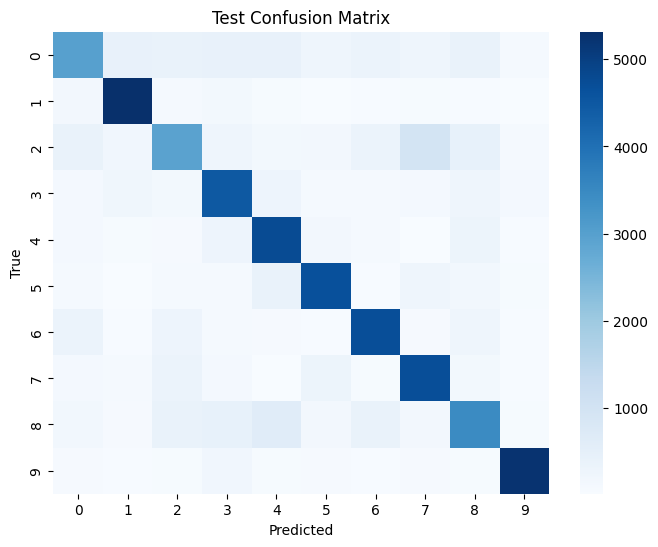

In [ ]:
print("\n== Test (LSTM + GloVe) ==");       _ = evaluation_set(model_lstm_glove, X_test_g, y_test, name="Test")

# BiLSTM With Skipgram and GloVe

In [ ]:
#BiLSTM + SG
model_bilstm_sg = build_lstm(
    vocab_size=emb_stats["vocab_size"],
    emb_dim=emb_mat.shape[1],
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat,
    maxlen=MAXLEN,
    units=384,            # Same as LSTM + SG
    bidirectional=True,
    trainable=True,
    dropout=0.35          # Same as LSTM + SG
)

In [ ]:
model_bilstm_sg.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),  # lr + clipnorm as decided
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_bilstm_sg.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 120, 300)  │  6,000,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 120)       │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 768)       │  2,104,320 │ embedding_7[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 768)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │      7,690 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,112,010 (30.94 MB)

 Trainable params: 8,112,010 (30.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(str(OUT_DIR / "bilstm_skipgram_tuned_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True),
]

In [ ]:
# Train

hist = model_bilstm_sg.fit(
    X_tr_sg, y_tr,
    validation_data=(X_val_sg, y_val),
    epochs=30,
    batch_size=128,      # smaller batch → better RNN generalization
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 85s 44ms/step - accuracy: 0.6680 - loss: 1.0481 - val_accuracy: 0.7149 - val_loss: 0.8799 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 143s 45ms/step - accuracy: 0.7375 - loss: 0.8166 - val_accuracy: 0.7196 - val_loss: 0.8653 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 141s 45ms/step - accuracy: 0.7538 - loss: 0.7522 - val_accuracy: 0.7171 - val_loss: 0.8765 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.7737 - loss: 0.6854 - val_accuracy: 0.7126 - val_loss: 0.9095 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.8010 - loss: 0.5940 - val_accuracy: 0.7030 - val_loss: 0.9657 - learning_rate: 2.5000e-04
Epoch 6/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 143s 45ms/step - accuracy: 0.8202 - loss: 0.5351 - val_accuracy: 0.6994 - val_loss: 1.0204 - learning_rate: 2.5000e-04



== Validation (Bi-LSTM + Skip-gram) ==
Val Accuracy: 0.7196 | Macro-F1: 0.7134
              precision    recall  f1-score   support

           0     0.6362    0.4779    0.5458      4193
           1     0.8057    0.8968    0.8488      4197
           2     0.6140    0.4750    0.5356      4196
           3     0.7306    0.6894    0.7094      4240
           4     0.7091    0.7778    0.7419      4186
           5     0.7804    0.8037    0.7919      4228
           6     0.7298    0.8157    0.7704      4162
           7     0.6930    0.7756    0.7320      4206
           8     0.5930    0.5887    0.5908      4182
           9     0.8416    0.8943    0.8671      4211

    accuracy                         0.7196     42001
   macro avg     0.7133    0.7195    0.7134     42001
weighted avg     0.7135    0.7196    0.7135     42001



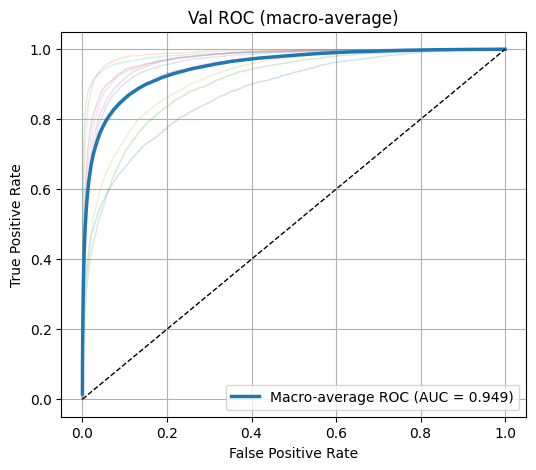

Per-class AUCs:
  Class 0: AUC = 0.8762
  Class 1: AUC = 0.9866
  Class 2: AUC = 0.8999
  Class 3: AUC = 0.9487
  Class 4: AUC = 0.9676
  Class 5: AUC = 0.9745
  Class 6: AUC = 0.9722
  Class 7: AUC = 0.9619
  Class 8: AUC = 0.9176
  Class 9: AUC = 0.9840
Macro-average AUC: 0.9489


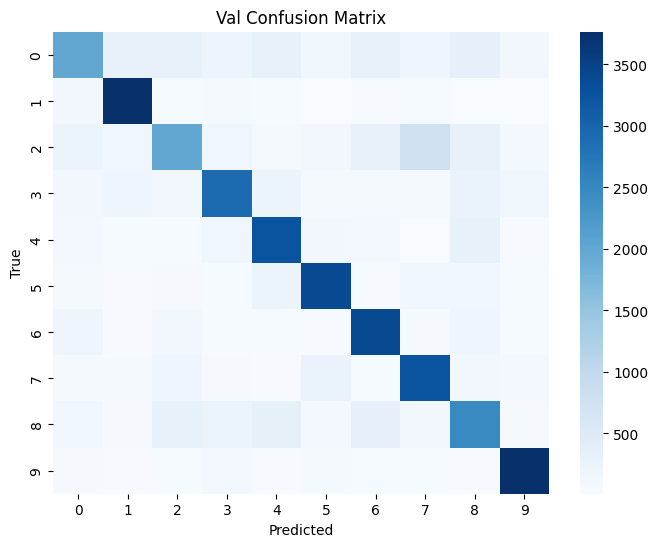

In [ ]:
print("\n== Validation (Bi-LSTM + Skip-gram) ==")
_ = evaluation_set(model_bilstm_sg, X_val_sg,  y_val,  name="Val")


== Test (Best Bi-LSTM + Skip-gram) ==
Test Accuracy: 0.7211 | Macro-F1: 0.7152
              precision    recall  f1-score   support

           0     0.6483    0.4777    0.5500      6000
           1     0.8055    0.8943    0.8476      6000
           2     0.6149    0.4815    0.5401      6000
           3     0.7282    0.6943    0.7109      6000
           4     0.7110    0.7703    0.7395      5999
           5     0.7672    0.7998    0.7832      6000
           6     0.7427    0.8223    0.7805      6000
           7     0.6987    0.7740    0.7344      6000
           8     0.5928    0.6002    0.5964      6000
           9     0.8437    0.8968    0.8694      6000

    accuracy                         0.7211     59999
   macro avg     0.7153    0.7211    0.7152     59999
weighted avg     0.7153    0.7211    0.7152     59999



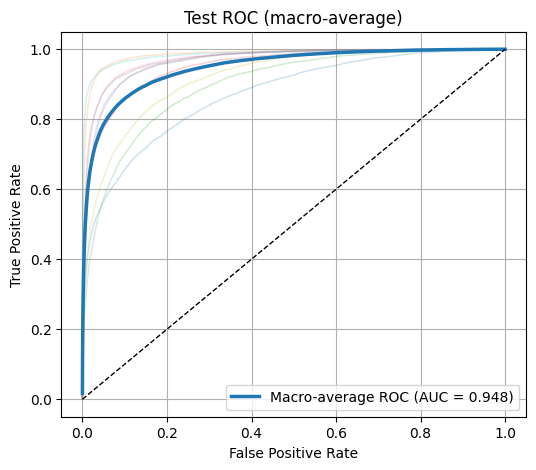

Per-class AUCs:
  Class 0: AUC = 0.8713
  Class 1: AUC = 0.9855
  Class 2: AUC = 0.8980
  Class 3: AUC = 0.9512
  Class 4: AUC = 0.9653
  Class 5: AUC = 0.9721
  Class 6: AUC = 0.9722
  Class 7: AUC = 0.9635
  Class 8: AUC = 0.9198
  Class 9: AUC = 0.9855
Macro-average AUC: 0.9485


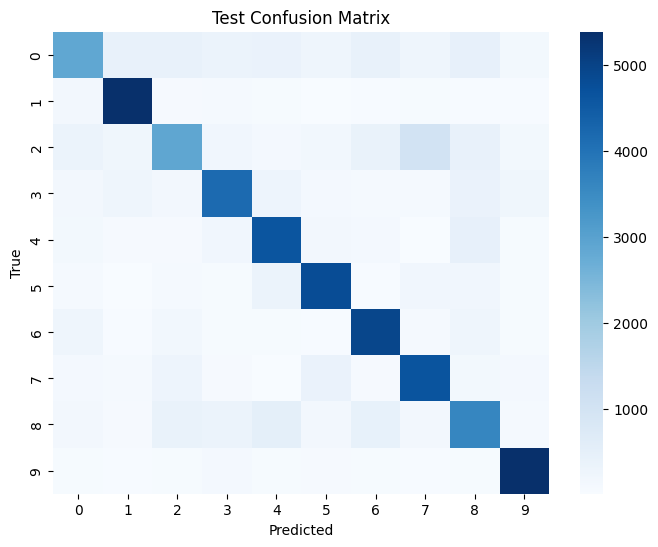

In [ ]:
print("\n== Test (Best Bi-LSTM + Skip-gram) ==")
_ = evaluation_set(model_bilstm_sg, X_test_sg, y_test, name="Test")

In [ ]:
#Bi-LSTM + GloVe

model_bilstm_glove = build_lstm(
    vocab_size=emb_stats_g["vocab_size"],
    emb_dim=EMB_DIM,
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat_g,
    maxlen=MAXLEN,
    units=384,            #Same as LSTM + GloVe
    bidirectional=True,
    trainable=True,
    dropout=0.35          #Same as LSTM + GloVe
)
model_bilstm_glove.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_bilstm_glove.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 120, 100)  │  2,000,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, 120)       │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 768)       │  1,489,920 │ embedding_8[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 768)       │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │      7,690 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,497,610 (13.34 MB)

 Trainable params: 3,497,610 (13.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3) Class weights + callbacks
cls = np.unique(y_tr)
class_weights = {int(c): float(w) for c, w in zip(cls, compute_class_weight("balanced", classes=cls, y=y_tr))}

cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(str(OUT_DIR / "bilstm_glove_tuned_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True),
]

In [ ]:
# 4) Train (same batch size as SG run)
hist = model_bilstm_glove.fit(
    X_tr_g, y_tr,
    validation_data=(X_val_g, y_val),
    epochs=30,
    batch_size=128,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 69s 36ms/step - accuracy: 0.6330 - loss: 1.1345 - val_accuracy: 0.7054 - val_loss: 0.9159 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.7191 - loss: 0.8767 - val_accuracy: 0.7146 - val_loss: 0.8773 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.7362 - loss: 0.8124 - val_accuracy: 0.7195 - val_loss: 0.8645 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.7512 - loss: 0.7641 - val_accuracy: 0.7201 - val_loss: 0.8670 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.7651 - loss: 0.7137 - val_accuracy: 0.7177 - val_loss: 0.8828 - learning_rate: 5.0000e-04
Epoch 6/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.7761 - loss: 0.6748 - val_accuracy: 0.7144 - val_loss: 0.9030 - learning_rate: 5.0000e-04
Epoch 7/30
1860/1860 ━━━━━━━━━━━━━━━━━━━

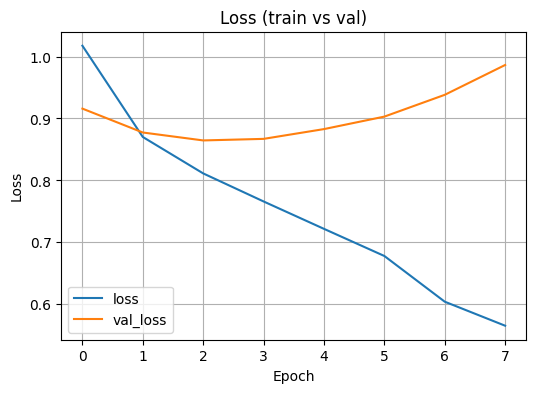

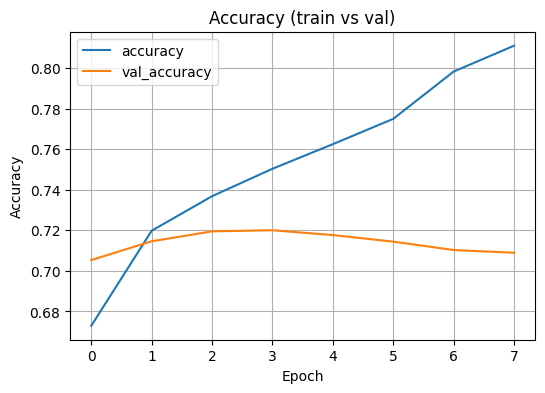

In [ ]:
plot_loss(hist); plot_acc(hist)


== Validation (Bi-LSTM + GloVe) ==
Val Accuracy: 0.7201 | Macro-F1: 0.7144
              precision    recall  f1-score   support

           0     0.6424    0.4889    0.5553      4193
           1     0.8038    0.8921    0.8456      4197
           2     0.6023    0.5024    0.5478      4196
           3     0.7152    0.6988    0.7069      4240
           4     0.7017    0.7946    0.7452      4186
           5     0.7588    0.8132    0.7850      4228
           6     0.7543    0.7864    0.7700      4162
           7     0.7163    0.7468    0.7312      4206
           8     0.6114    0.5772    0.5938      4182
           9     0.8292    0.8991    0.8627      4211

    accuracy                         0.7201     42001
   macro avg     0.7135    0.7199    0.7144     42001
weighted avg     0.7136    0.7201    0.7145     42001



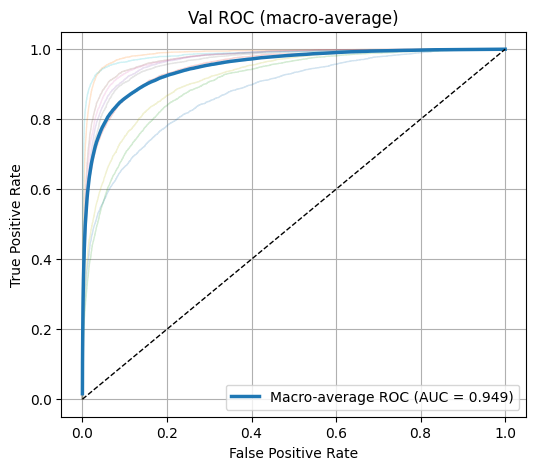

Per-class AUCs:
  Class 0: AUC = 0.8763
  Class 1: AUC = 0.9868
  Class 2: AUC = 0.9010
  Class 3: AUC = 0.9508
  Class 4: AUC = 0.9675
  Class 5: AUC = 0.9740
  Class 6: AUC = 0.9717
  Class 7: AUC = 0.9624
  Class 8: AUC = 0.9179
  Class 9: AUC = 0.9846
Macro-average AUC: 0.9493


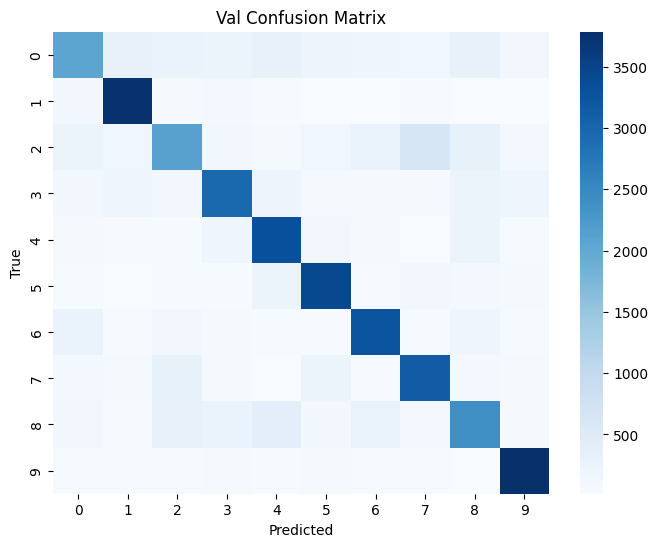

In [ ]:
print("\n== Validation (Bi-LSTM + GloVe) =="); _ = evaluation_set(model_bilstm_glove, X_val_g,  y_val,  name="Val")


== Test (Bi-LSTM + GloVe) ==
Test Accuracy: 0.7206 | Macro-F1: 0.7150
              precision    recall  f1-score   support

           0     0.6527    0.4833    0.5554      6000
           1     0.8032    0.8930    0.8457      6000
           2     0.5948    0.5027    0.5448      6000
           3     0.7091    0.7022    0.7056      6000
           4     0.6996    0.7871    0.7408      5999
           5     0.7484    0.8075    0.7768      6000
           6     0.7692    0.7913    0.7801      6000
           7     0.7216    0.7492    0.7351      6000
           8     0.6160    0.5878    0.6016      6000
           9     0.8298    0.9018    0.8643      6000

    accuracy                         0.7206     59999
   macro avg     0.7144    0.7206    0.7150     59999
weighted avg     0.7144    0.7206    0.7150     59999



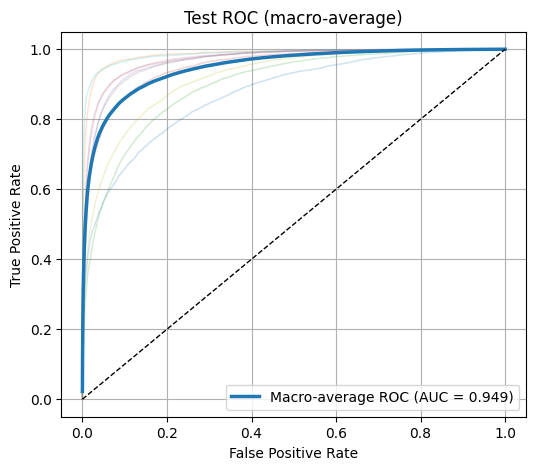

Per-class AUCs:
  Class 0: AUC = 0.8738
  Class 1: AUC = 0.9849
  Class 2: AUC = 0.8981
  Class 3: AUC = 0.9521
  Class 4: AUC = 0.9660
  Class 5: AUC = 0.9718
  Class 6: AUC = 0.9714
  Class 7: AUC = 0.9639
  Class 8: AUC = 0.9198
  Class 9: AUC = 0.9863
Macro-average AUC: 0.9488


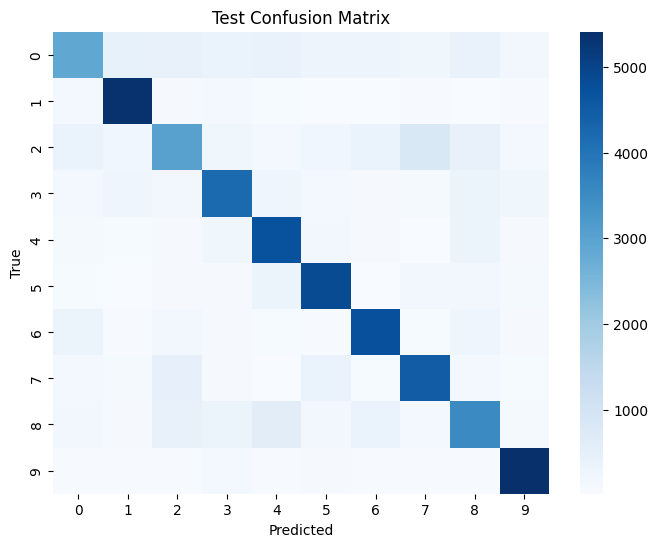

In [ ]:
print("\n== Test (Bi-LSTM + GloVe) ==");       _ = evaluation_set(model_bilstm_glove, X_test_g, y_test, name="Test")

# LSTM Wrap-Up

### Best Performing LSTM Configuration
- **Architecture:** LSTM (unidirectional)  
- **Embedding:** GloVe, `trainable=True`  
- **Units:** 384  
- **Dropout:** 0.35  
- **Optimizer:** Adam (`lr=5e-4`, `clipnorm=1.0`)  
- **Batch Size:** 128  
- **Regularization:** EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  
- **Class Weights:** Applied for imbalance handling  

**Validation:** Accuracy ≈ **0.7191**, Macro-F1 ≈ **0.7142**  
**Test:** Accuracy ≈ **0.7209**, Macro-F1 ≈ **0.7163**

Compared to Skip-gram LSTM, GloVe LSTM gave a consistent edge in Macro-F1, mainly by improving recall in medium-support classes.

# GRU with SkipGram and GloVe

In [ ]:
# === GRU + Skip-gram (using our helpers) — hypertune to beat DNN/RNN ===

import numpy as np
from tensorflow.keras import callbacks, optimizers, losses
from sklearn.utils.class_weight import compute_class_weight

# 1) Build 20k Skip-gram embedding + cap IDs
NUM_WORDS = 20_000
EMB_DIM   = int(w2v_kv.vector_size)

lookup = kv_to_lookup(w2v_kv, emb_dim=EMB_DIM)
emb_mat, oov_idx, emb_stats = build_embedding_matrix_from_lookup(
    tok, num_words=NUM_WORDS, emb_dim=EMB_DIM, lookup=lookup,
    oov_token=(tok.oov_token or "<unk>")
)
X_tr   = cap_ids_and_fix_empty(X_tr,   emb_stats["vocab_size"], oov_idx)
X_val  = cap_ids_and_fix_empty(X_val,  emb_stats["vocab_size"], oov_idx)
X_test = cap_ids_and_fix_empty(X_test, emb_stats["vocab_size"], oov_idx)

MAXLEN      = int(meta.get("maxlen", X_tr.shape[1]))
NUM_CLASSES = int(meta.get("num_classes", np.unique(y_tr).size))

[KeyedVectors] vector_size = 300
Coverage: 19998/20000 (99.99%)


In [ ]:
#Minor Bug Fix

def to_right_padded(X):
    """Move nonzero tokens to the left; pad with zeros on the right."""
    Xr = np.zeros_like(X)
    for i in range(X.shape[0]):
        nz = X[i][X[i] != 0]
        Xr[i, :len(nz)] = nz
    return Xr

# Apply after cap_ids_and_fix_empty(...)
X_tr  = to_right_padded(X_tr)
X_val = to_right_padded(X_val)
X_test= to_right_padded(X_test)

In [ ]:
# === GRU + Skip-gram (using our helpers) ===

# 1) Build GRU model
model_gru_sg = build_gru(
    vocab_size=emb_stats["vocab_size"],
    emb_dim=emb_mat.shape[1],
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat,
    maxlen=MAXLEN,
    units=384,              # same as tuned LSTM
    bidirectional=False,    # keep simple GRU first
    trainable=True,
    dropout=0.35
)

# 2) Compile
model_gru_sg.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_gru_sg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 120, 300)  │  6,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 120)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 384)       │    790,272 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      3,850 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,794,122 (25.92 MB)

 Trainable params: 6,794,122 (25.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cls = np.unique(y_tr)
class_weights = {int(c): float(w) for c, w in zip(cls, compute_class_weight("balanced", classes=cls, y=y_tr))}

In [ ]:
cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(str(OUT_DIR / "gru_skipgram_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True),
]

# 4) Train
hist_gru_sg = model_gru_sg.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step - accuracy: 0.6419 - loss: 1.1160 - val_accuracy: 0.7139 - val_loss: 0.8807 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.7333 - loss: 0.8211 - val_accuracy: 0.7169 - val_loss: 0.8716 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.7535 - loss: 0.7507 - val_accuracy: 0.7174 - val_loss: 0.8740 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.7714 - loss: 0.6886 - val_accuracy: 0.7114 - val_loss: 0.9188 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.7937 - loss: 0.6191 - val_accuracy: 0.7018 - val_loss: 0.9753 - learning_rate: 5.0000e-04
Epoch 6/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.8266 - loss: 0.5203 - val_accuracy: 0.6897 - val_loss: 1.0797 - learning_rate: 2.5000e-04
Epoch 7/30
1860/1860 ━━━━━━━━━━━━━━━━━━━

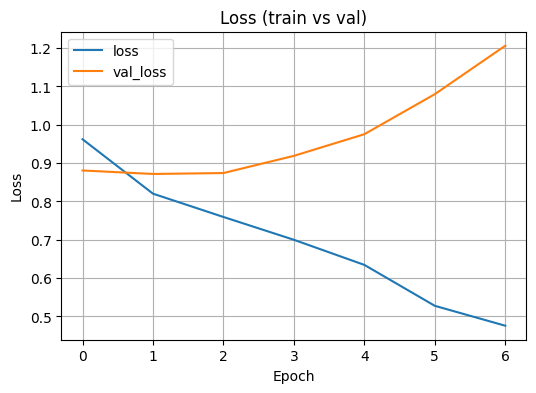

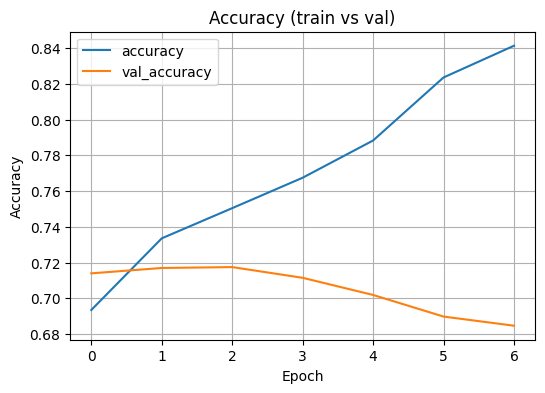

In [ ]:
# 5) Curves + evaluation
plot_loss(hist_gru_sg); plot_acc(hist_gru_sg)


== Validation (GRU + Skip-gram) ==
Val Accuracy: 0.7174 | Macro-F1: 0.7135
              precision    recall  f1-score   support

           0     0.6402    0.4906    0.5555      4193
           1     0.8414    0.8644    0.8527      4197
           2     0.5624    0.5231    0.5420      4196
           3     0.6856    0.7205    0.7026      4240
           4     0.7189    0.7771    0.7469      4186
           5     0.7460    0.8148    0.7789      4228
           6     0.7615    0.7710    0.7662      4162
           7     0.6900    0.7758    0.7304      4206
           8     0.6206    0.5617    0.5897      4182
           9     0.8665    0.8737    0.8700      4211

    accuracy                         0.7174     42001
   macro avg     0.7133    0.7173    0.7135     42001
weighted avg     0.7133    0.7174    0.7136     42001



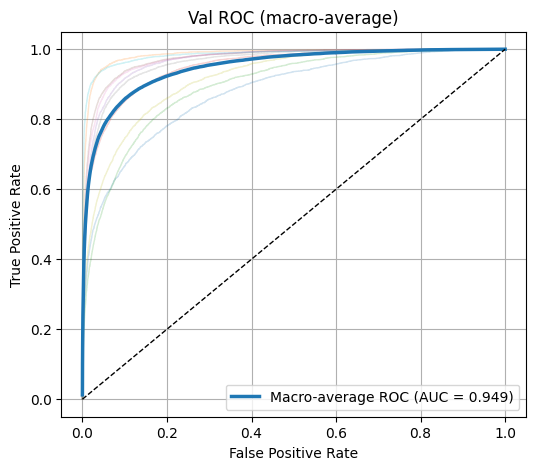

Per-class AUCs:
  Class 0: AUC = 0.8773
  Class 1: AUC = 0.9858
  Class 2: AUC = 0.8950
  Class 3: AUC = 0.9500
  Class 4: AUC = 0.9677
  Class 5: AUC = 0.9735
  Class 6: AUC = 0.9719
  Class 7: AUC = 0.9619
  Class 8: AUC = 0.9179
  Class 9: AUC = 0.9845
Macro-average AUC: 0.9486


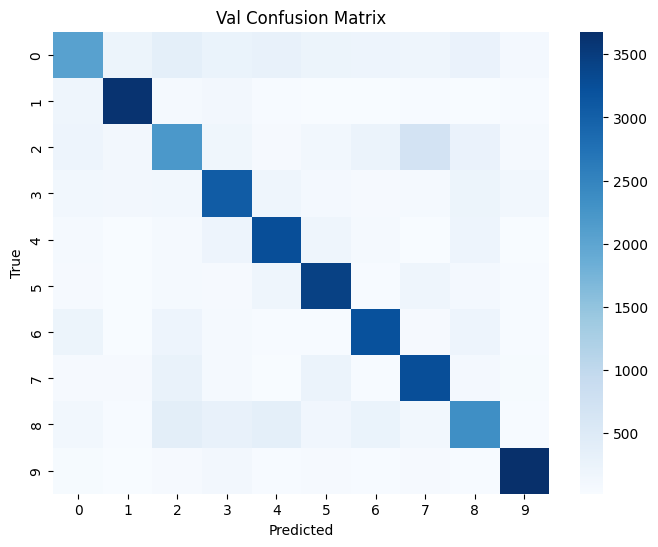

In [ ]:

print("\n== Validation (GRU + Skip-gram) ==")
_ = evaluation_set(model_gru_sg, X_val, y_val, name="Val")


== Test (GRU + Skip-gram) ==
Test Accuracy: 0.7198 | Macro-F1: 0.7163
              precision    recall  f1-score   support

           0     0.6503    0.4913    0.5598      6000
           1     0.8426    0.8617    0.8520      6000
           2     0.5646    0.5333    0.5485      6000
           3     0.6852    0.7248    0.7045      6000
           4     0.7179    0.7711    0.7436      5999
           5     0.7381    0.8110    0.7728      6000
           6     0.7722    0.7755    0.7738      6000
           7     0.6858    0.7760    0.7281      6000
           8     0.6349    0.5767    0.6044      6000
           9     0.8748    0.8767    0.8757      6000

    accuracy                         0.7198     59999
   macro avg     0.7166    0.7198    0.7163     59999
weighted avg     0.7166    0.7198    0.7163     59999



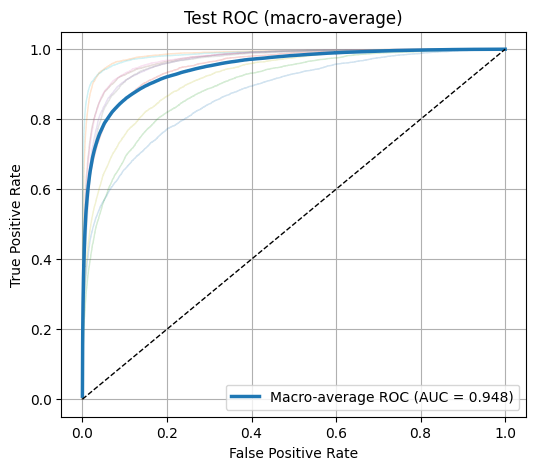

Per-class AUCs:
  Class 0: AUC = 0.8725
  Class 1: AUC = 0.9853
  Class 2: AUC = 0.8936
  Class 3: AUC = 0.9520
  Class 4: AUC = 0.9652
  Class 5: AUC = 0.9716
  Class 6: AUC = 0.9718
  Class 7: AUC = 0.9625
  Class 8: AUC = 0.9200
  Class 9: AUC = 0.9855
Macro-average AUC: 0.9480


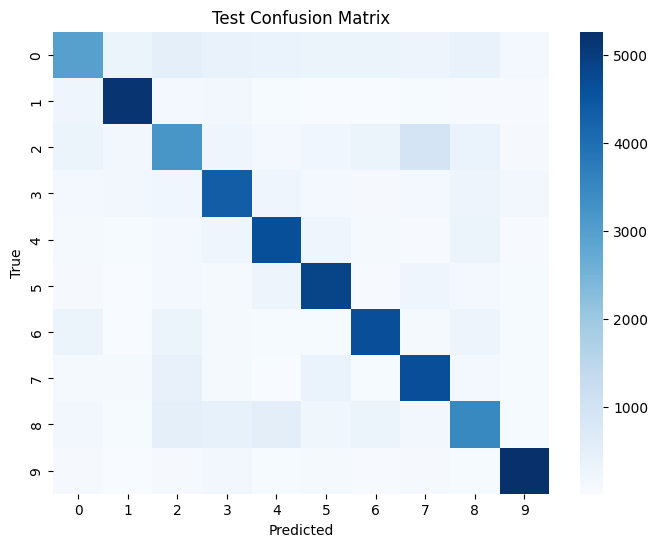

In [ ]:

print("\n== Test (GRU + Skip-gram) ==")
_ = evaluation_set(model_gru_sg, X_test, y_test, name="Test")

In [ ]:
# === GRU + GloVe ===
import numpy as np
from tensorflow.keras import optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight

# -------------------------------
# 1) Build 20k GloVe embedding + cap IDs
# -------------------------------
NUM_WORDS = 20_000
EMB_DIM   = 100  # glove.6B.100d.txt

# Make a lookup dict from the GloVe .txt (path defined in your load cell: glove_file)
lookup = load_glove_txt(glove_file, emb_dim=EMB_DIM)

# Build embedding matrix aligned to tokenizer indices
emb_mat_g, oov_idx_g, emb_stats_g = build_embedding_matrix_from_lookup(
    tok,
    num_words=NUM_WORDS,
    emb_dim=EMB_DIM,
    lookup=lookup,
    oov_token=(tok.oov_token or "<unk>")
)

# Cap token IDs to vocab, fix empty rows
X_tr_g   = cap_ids_and_fix_empty(X_tr,   emb_stats_g["vocab_size"], oov_idx_g)
X_val_g  = cap_ids_and_fix_empty(X_val,  emb_stats_g["vocab_size"], oov_idx_g)
X_test_g = cap_ids_and_fix_empty(X_test, emb_stats_g["vocab_size"], oov_idx_g)

# Optional: shift nonzeros left, pad right (same minor bug-fix routine you used)
def to_right_padded(X):
    Xr = np.zeros_like(X)
    for i in range(X.shape[0]):
        nz = X[i][X[i] != 0]
        Xr[i, :len(nz)] = nz
    return Xr

X_tr_g   = to_right_padded(X_tr_g)
X_val_g  = to_right_padded(X_val_g)
X_test_g = to_right_padded(X_test_g)

MAXLEN       = int(meta.get("maxlen", X_tr_g.shape[1]))
NUM_CLASSES  = int(meta.get("num_classes", np.unique(y_tr).size))

print("[GloVe] vocab_size:", emb_stats_g["vocab_size"])
print("[GloVe] coverage :", f'{emb_stats_g["hits"]}/{emb_stats_g["vocab_size"]} '
      f'({emb_stats_g["coverage_pct"]:.2f}%)')
print("Shapes:", X_tr_g.shape, X_val_g.shape, X_test_g.shape)

[GloVe] loaded 400,000 vectors
Coverage: 18784/20000 (93.92%)
[GloVe] vocab_size: 20000
[GloVe] coverage : 18784/20000 (93.92%)
Shapes: (238002, 120) (42001, 120) (59999, 120)


In [ ]:
def to_right_padded(X):
    Xr = np.zeros_like(X)
    for i in range(X.shape[0]):
        nz = X[i][X[i] != 0]
        Xr[i, :len(nz)] = nz
    return Xr

X_tr_g   = to_right_padded(X_tr_g)
X_val_g  = to_right_padded(X_val_g)
X_test_g = to_right_padded(X_test_g)

MAXLEN       = int(meta.get("maxlen", X_tr_g.shape[1]))
NUM_CLASSES  = int(meta.get("num_classes", np.unique(y_tr).size))

print("[GloVe] vocab_size:", emb_stats_g["vocab_size"])
print("[GloVe] coverage :", f'{emb_stats_g["hits"]}/{emb_stats_g["vocab_size"]} '
      f'({emb_stats_g["coverage_pct"]:.2f}%)')
print("Shapes:", X_tr_g.shape, X_val_g.shape, X_test_g.shape)

[GloVe] vocab_size: 20000
[GloVe] coverage : 18784/20000 (93.92%)
Shapes: (238002, 120) (42001, 120) (59999, 120)


In [ ]:
# -------------------------------
# 2) Class weights (balanced)
# -------------------------------
cls = np.unique(y_tr)
class_weights = {int(c): float(w) for c, w in zip(
    cls, compute_class_weight(class_weight="balanced", classes=cls, y=y_tr))
}

# -------------------------------
# 3) Build GRU model (same knobs as your tuned LSTM)
# -------------------------------
model_gru_g = build_gru(
    vocab_size=emb_stats_g["vocab_size"],
    emb_dim=emb_mat_g.shape[1],
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat_g,
    maxlen=MAXLEN,
    units=384,             # same as tuned LSTM capacity
    bidirectional=False,   # simple GRU first
    trainable=True,
    dropout=0.35
)

model_gru_g.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_gru_g.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 120, 100)  │  2,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 120)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 384)       │    559,872 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 384)       │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      3,850 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,563,722 (9.78 MB)

 Trainable params: 2,563,722 (9.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------------------------------
# 4) Callbacks: ES + LR decay + best checkpoint
# -------------------------------
cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                            patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max",
                                factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(str(OUT_DIR / "gru_glove_best.keras"),
                              monitor="val_accuracy", mode="max",
                              save_best_only=True),
]

# -------------------------------
# 5) Train
# -------------------------------
hist_gru_g = model_gru_g.fit(
    X_tr_g, y_tr,
    validation_data=(X_val_g, y_val),
    epochs=30,
    batch_size=128,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)


Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.6030 - loss: 1.2148 - val_accuracy: 0.7048 - val_loss: 0.9106 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.7174 - loss: 0.8816 - val_accuracy: 0.7141 - val_loss: 0.8755 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.7365 - loss: 0.8162 - val_accuracy: 0.7160 - val_loss: 0.8697 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step - accuracy: 0.7486 - loss: 0.7691 - val_accuracy: 0.7195 - val_loss: 0.8705 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.7614 - loss: 0.7265 - val_accuracy: 0.7161 - val_loss: 0.8779 - learning_rate: 5.0000e-04
Epoch 6/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - accuracy: 0.7724 - loss: 0.6892 - val_accuracy: 0.7135 - val_loss: 0.9094 - learning_rate: 5.0000e-04
Epoch 7/30
1860/1860 ━━━━━━━━━━━━━━━━━━━

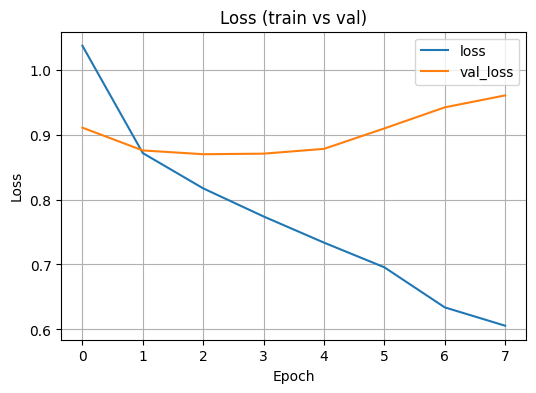

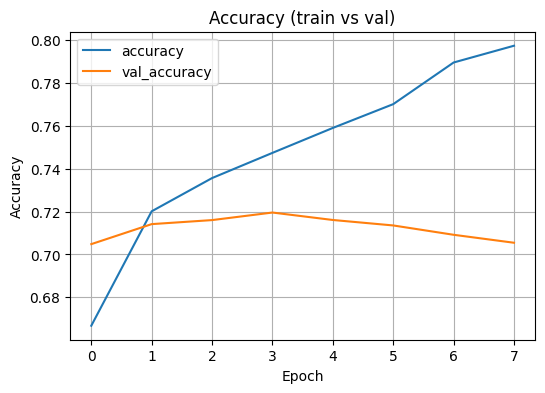

In [ ]:
# -------------------------------
# 6) Curves + Evaluation
# -------------------------------
plot_loss(hist_gru_g); plot_acc(hist_gru_g)


== Validation (GRU + GloVe) ==
Val Accuracy: 0.7195 | Macro-F1: 0.7159
              precision    recall  f1-score   support

           0     0.6176    0.5054    0.5559      4193
           1     0.8080    0.8902    0.8471      4197
           2     0.6061    0.5002    0.5481      4196
           3     0.7341    0.6868    0.7096      4240
           4     0.7262    0.7678    0.7464      4186
           5     0.7705    0.8117    0.7906      4228
           6     0.7356    0.7902    0.7620      4162
           7     0.7084    0.7513    0.7292      4206
           8     0.5744    0.6215    0.5970      4182
           9     0.8760    0.8694    0.8727      4211

    accuracy                         0.7195     42001
   macro avg     0.7157    0.7195    0.7159     42001
weighted avg     0.7158    0.7195    0.7160     42001



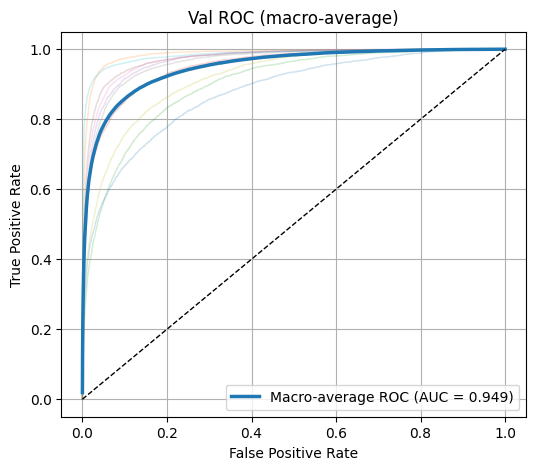

Per-class AUCs:
  Class 0: AUC = 0.8768
  Class 1: AUC = 0.9862
  Class 2: AUC = 0.8994
  Class 3: AUC = 0.9501
  Class 4: AUC = 0.9673
  Class 5: AUC = 0.9738
  Class 6: AUC = 0.9716
  Class 7: AUC = 0.9625
  Class 8: AUC = 0.9190
  Class 9: AUC = 0.9843
Macro-average AUC: 0.9491


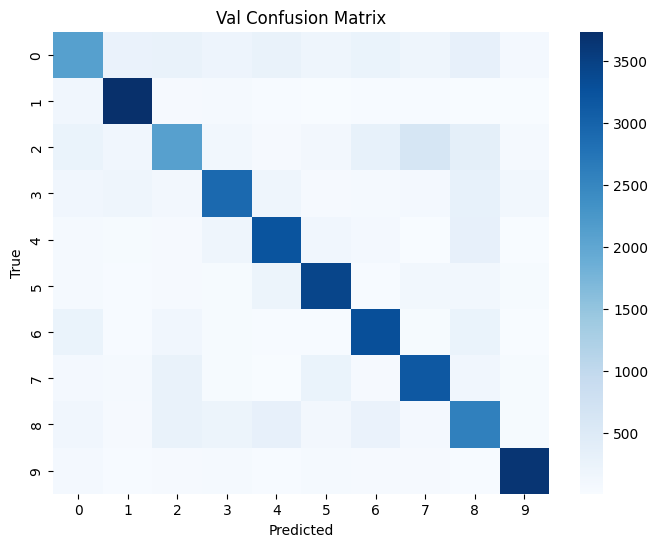

In [ ]:
print("\n== Validation (GRU + GloVe) ==")
_ = evaluation_set(model_gru_g, X_val_g, y_val, name="Val")


== Test (GRU + GloVe) ==
Test Accuracy: 0.7201 | Macro-F1: 0.7168
              precision    recall  f1-score   support

           0     0.6208    0.5028    0.5556      6000
           1     0.8050    0.8868    0.8439      6000
           2     0.5899    0.5027    0.5428      6000
           3     0.7270    0.6893    0.7077      6000
           4     0.7272    0.7568    0.7417      5999
           5     0.7646    0.8033    0.7835      6000
           6     0.7467    0.8012    0.7730      6000
           7     0.7129    0.7553    0.7335      6000
           8     0.5824    0.6332    0.6067      6000
           9     0.8896    0.8692    0.8793      6000

    accuracy                         0.7201     59999
   macro avg     0.7166    0.7201    0.7168     59999
weighted avg     0.7166    0.7201    0.7168     59999



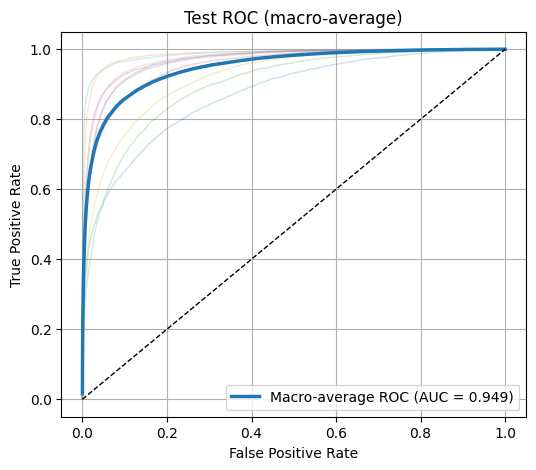

Per-class AUCs:
  Class 0: AUC = 0.8725
  Class 1: AUC = 0.9852
  Class 2: AUC = 0.8974
  Class 3: AUC = 0.9520
  Class 4: AUC = 0.9655
  Class 5: AUC = 0.9718
  Class 6: AUC = 0.9718
  Class 7: AUC = 0.9632
  Class 8: AUC = 0.9205
  Class 9: AUC = 0.9862
Macro-average AUC: 0.9486


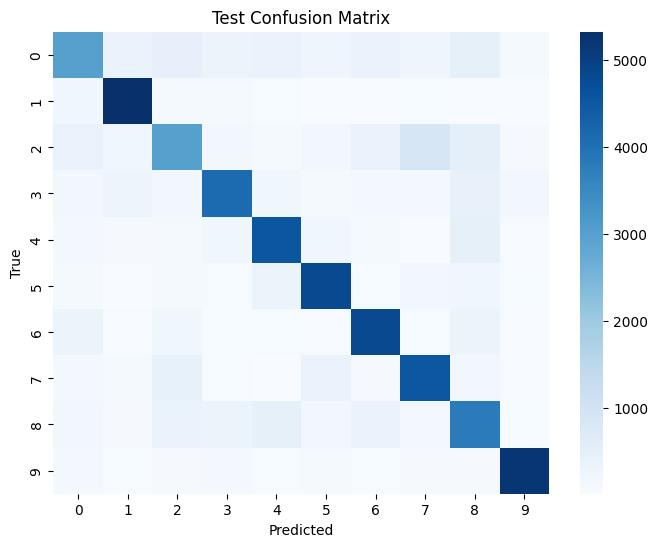

In [ ]:
print("\n== Test (GRU + GloVe) ==")
_ = evaluation_set(model_gru_g, X_test_g, y_test, name="Test")


# Bidirectional GRU

In [ ]:
# === Bi-GRU + Skip-gram===

# 1) Build Bi-GRU model
model_bigru_sg = build_gru(
    vocab_size=emb_stats["vocab_size"],
    emb_dim=emb_mat.shape[1],
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat,
    maxlen=MAXLEN,
    units=384,              # same as tuned LSTM
    bidirectional=True,
    trainable=True,
    dropout=0.35
)

# 2) Compile
model_bigru_sg.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_bigru_sg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 120, 300)  │  6,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 120)       │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 768)       │  1,580,544 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 768)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │      7,690 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,588,234 (28.95 MB)

 Trainable params: 7,588,234 (28.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(str(OUT_DIR / "gru_skipgram_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True),
]

# 4) Train
hist_bigru_sg = model_bigru_sg.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.6681 - loss: 1.0485 - val_accuracy: 0.7133 - val_loss: 0.8822 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.7348 - loss: 0.8113 - val_accuracy: 0.7178 - val_loss: 0.8683 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 77s 41ms/step - accuracy: 0.7567 - loss: 0.7373 - val_accuracy: 0.7156 - val_loss: 0.8793 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.7795 - loss: 0.6635 - val_accuracy: 0.7086 - val_loss: 0.9267 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.8146 - loss: 0.5559 - val_accuracy: 0.6993 - val_loss: 1.0084 - learning_rate: 2.5000e-04
Epoch 6/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.8390 - loss: 0.4860 - val_accuracy: 0.6905 - val_loss: 1.0834 - learning_rate: 2.5000e-04


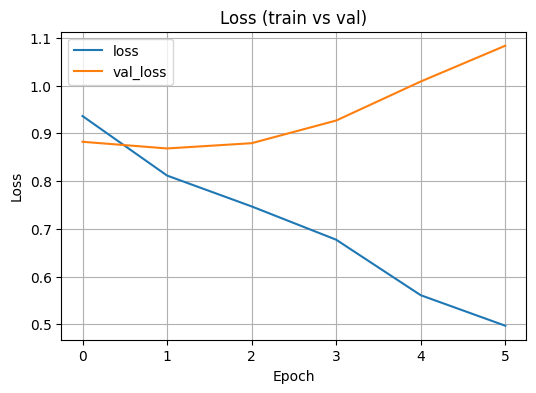

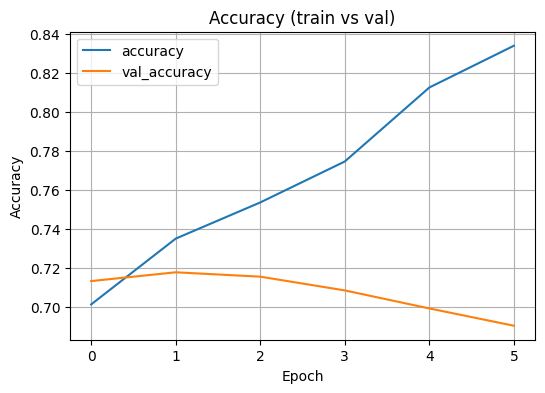

In [ ]:
# 5) Curves + evaluation
plot_loss(hist_bigru_sg); plot_acc(hist_bigru_sg)


== Validation (BiGRU + Skip-gram) ==
Validation BiGRU + SG Accuracy: 0.7178 | Macro-F1: 0.7152
              precision    recall  f1-score   support

           0     0.5751    0.5471    0.5607      4193
           1     0.8410    0.8732    0.8568      4197
           2     0.5705    0.5379    0.5537      4196
           3     0.7391    0.6854    0.7112      4240
           4     0.6869    0.8086    0.7428      4186
           5     0.7879    0.7852    0.7865      4228
           6     0.8003    0.7174    0.7566      4162
           7     0.7026    0.7649    0.7324      4206
           8     0.6187    0.5560    0.5856      4182
           9     0.8330    0.9012    0.8657      4211

    accuracy                         0.7178     42001
   macro avg     0.7155    0.7177    0.7152     42001
weighted avg     0.7156    0.7178    0.7153     42001



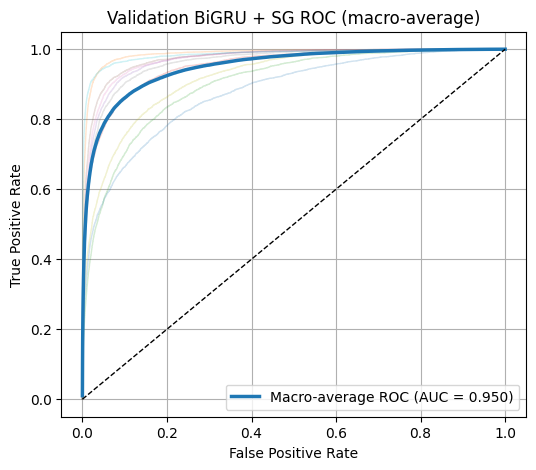

Per-class AUCs:
  Class 0: AUC = 0.8766
  Class 1: AUC = 0.9870
  Class 2: AUC = 0.8994
  Class 3: AUC = 0.9511
  Class 4: AUC = 0.9684
  Class 5: AUC = 0.9744
  Class 6: AUC = 0.9715
  Class 7: AUC = 0.9623
  Class 8: AUC = 0.9192
  Class 9: AUC = 0.9850
Macro-average AUC: 0.9495


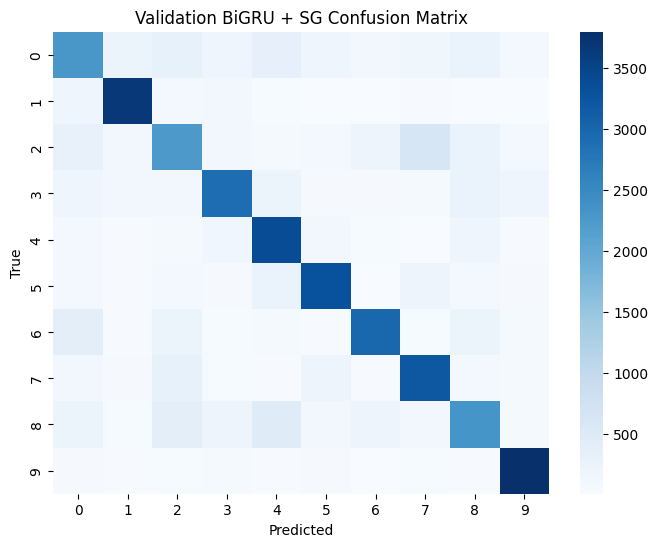

In [ ]:
print("\n== Validation (BiGRU + Skip-gram) ==")
_ = evaluation_set(model_bigru_sg, X_val, y_val, name="Validation BiGRU + SG")


== Test (biGRU + Skip-gram) ==
Test BiGRU + SG Accuracy: 0.7187 | Macro-F1: 0.7165
              precision    recall  f1-score   support

           0     0.5811    0.5452    0.5626      6000
           1     0.8359    0.8653    0.8504      6000
           2     0.5642    0.5462    0.5550      6000
           3     0.7312    0.6882    0.7090      6000
           4     0.6869    0.8023    0.7401      5999
           5     0.7794    0.7803    0.7799      6000
           6     0.8168    0.7178    0.7641      6000
           7     0.7065    0.7687    0.7363      6000
           8     0.6361    0.5717    0.6022      6000
           9     0.8321    0.9010    0.8652      6000

    accuracy                         0.7187     59999
   macro avg     0.7170    0.7187    0.7165     59999
weighted avg     0.7170    0.7187    0.7165     59999



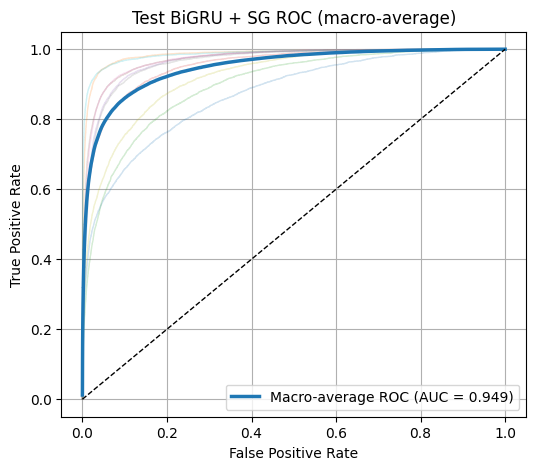

Per-class AUCs:
  Class 0: AUC = 0.8710
  Class 1: AUC = 0.9854
  Class 2: AUC = 0.8967
  Class 3: AUC = 0.9534
  Class 4: AUC = 0.9666
  Class 5: AUC = 0.9726
  Class 6: AUC = 0.9719
  Class 7: AUC = 0.9638
  Class 8: AUC = 0.9209
  Class 9: AUC = 0.9861
Macro-average AUC: 0.9489


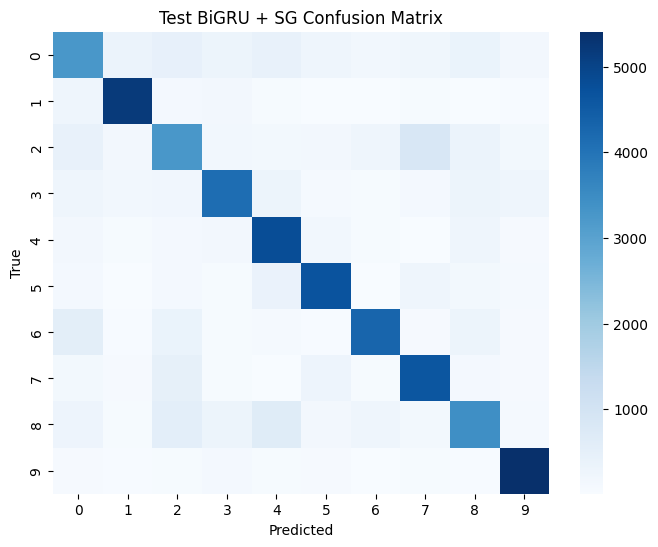

In [ ]:

print("\n== Test (biGRU + Skip-gram) ==")
_ = evaluation_set(model_bigru_sg, X_test, y_test, name="Test BiGRU + SG")

In [ ]:
#Bi-GRU + GloVe


model_bigru_g = build_gru(
    vocab_size=emb_stats_g["vocab_size"],
    emb_dim=emb_mat_g.shape[1],
    num_classes=NUM_CLASSES,
    embedding_matrix=emb_mat_g,
    maxlen=MAXLEN,
    units=384,             # same as tuned LSTM capacity
    bidirectional=False,   # simple GRU first
    trainable=True,
    dropout=0.35
)

model_bigru_g.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_bigru_g.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 120, 100)  │  2,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 120)       │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 384)       │    559,872 │ embedding_3[0][0… │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 384)       │          0 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │      3,850 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,563,722 (9.78 MB)

 Trainable params: 2,563,722 (9.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.5, patience=2, min_lr=1e-5),
    callbacks.ModelCheckpoint(str(OUT_DIR / "gru_skipgram_best.keras"),
                              monitor="val_accuracy", mode="max", save_best_only=True),
]

# 4) Train
hist_bigru_g = model_bigru_g.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.6041 - loss: 1.2077 - val_accuracy: 0.7053 - val_loss: 0.9069 - learning_rate: 5.0000e-04
Epoch 2/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - accuracy: 0.7156 - loss: 0.8800 - val_accuracy: 0.7134 - val_loss: 0.8773 - learning_rate: 5.0000e-04
Epoch 3/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.7348 - loss: 0.8191 - val_accuracy: 0.7172 - val_loss: 0.8685 - learning_rate: 5.0000e-04
Epoch 4/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7482 - loss: 0.7742 - val_accuracy: 0.7192 - val_loss: 0.8655 - learning_rate: 5.0000e-04
Epoch 5/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7601 - loss: 0.7307 - val_accuracy: 0.7171 - val_loss: 0.8848 - learning_rate: 5.0000e-04
Epoch 6/30
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7743 - loss: 0.6848 - val_accuracy: 0.7131 - val_loss: 0.9027 - learning_rate: 5.0000e-04
Epoch 7/30
1860/1860 ━━━━━━━━━━━━━━━━━━━

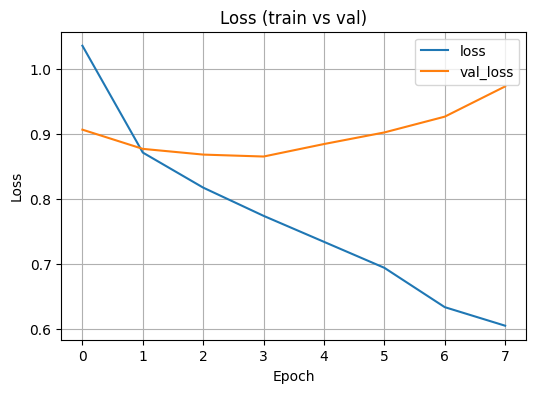

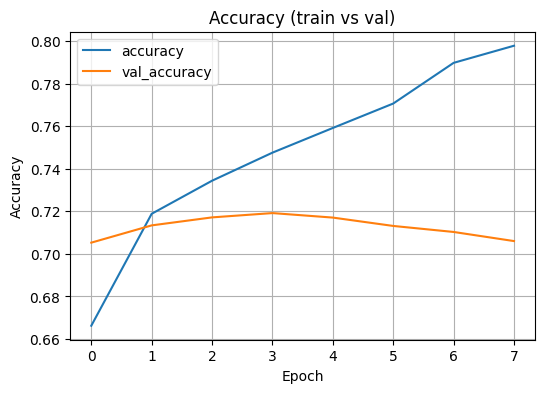

In [ ]:
# 5) Curves + evaluation
plot_loss(hist_bigru_g); plot_acc(hist_bigru_g)


== Validation (BiGRU + GloVE) ==
Validation BiGRU + GloVe Accuracy: 0.7192 | Macro-F1: 0.7169
              precision    recall  f1-score   support

           0     0.6188    0.5049    0.5561      4193
           1     0.8362    0.8623    0.8490      4197
           2     0.5622    0.5393    0.5505      4196
           3     0.7078    0.7094    0.7086      4240
           4     0.7292    0.7745    0.7512      4186
           5     0.7783    0.7990    0.7885      4228
           6     0.7684    0.7746    0.7715      4162
           7     0.7184    0.7368    0.7275      4206
           8     0.5833    0.6102    0.5965      4182
           9     0.8604    0.8798    0.8700      4211

    accuracy                         0.7192     42001
   macro avg     0.7163    0.7191    0.7169     42001
weighted avg     0.7164    0.7192    0.7170     42001



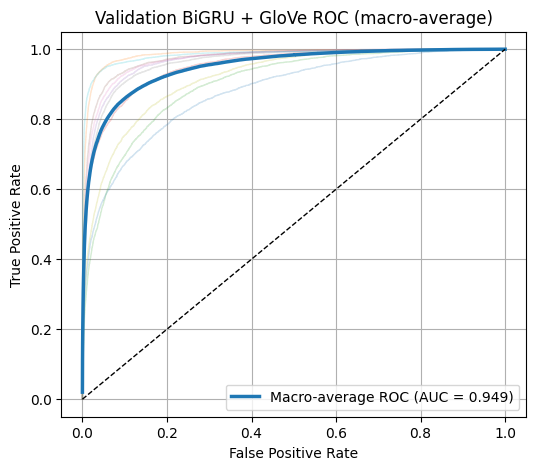

Per-class AUCs:
  Class 0: AUC = 0.8783
  Class 1: AUC = 0.9863
  Class 2: AUC = 0.8999
  Class 3: AUC = 0.9502
  Class 4: AUC = 0.9676
  Class 5: AUC = 0.9741
  Class 6: AUC = 0.9716
  Class 7: AUC = 0.9626
  Class 8: AUC = 0.9188
  Class 9: AUC = 0.9849
Macro-average AUC: 0.9494


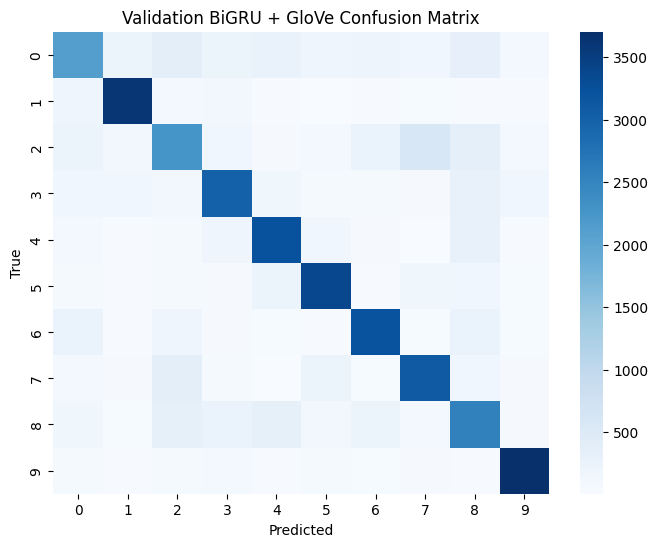

In [ ]:
print("\n== Validation (BiGRU + GloVE) ==")
_ = evaluation_set(model_bigru_g, X_val, y_val, name="Validation BiGRU + GloVe")


== Test (biGRU + Skip-gram) ==
Test BiGRU + GloVe Accuracy: 0.7205 | Macro-F1: 0.7185
              precision    recall  f1-score   support

           0     0.6146    0.4995    0.5511      6000
           1     0.8391    0.8570    0.8480      6000
           2     0.5547    0.5443    0.5495      6000
           3     0.7049    0.7172    0.7110      6000
           4     0.7233    0.7606    0.7415      5999
           5     0.7731    0.7952    0.7840      6000
           6     0.7728    0.7802    0.7765      6000
           7     0.7245    0.7420    0.7331      6000
           8     0.5971    0.6208    0.6088      6000
           9     0.8760    0.8882    0.8821      6000

    accuracy                         0.7205     59999
   macro avg     0.7180    0.7205    0.7185     59999
weighted avg     0.7180    0.7205    0.7185     59999



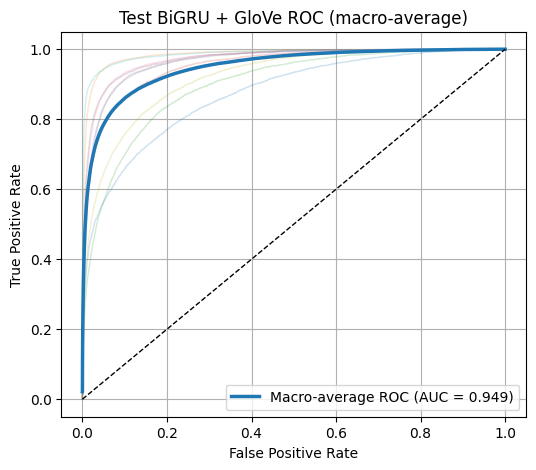

Per-class AUCs:
  Class 0: AUC = 0.8738
  Class 1: AUC = 0.9852
  Class 2: AUC = 0.8987
  Class 3: AUC = 0.9525
  Class 4: AUC = 0.9654
  Class 5: AUC = 0.9724
  Class 6: AUC = 0.9716
  Class 7: AUC = 0.9639
  Class 8: AUC = 0.9204
  Class 9: AUC = 0.9867
Macro-average AUC: 0.9491


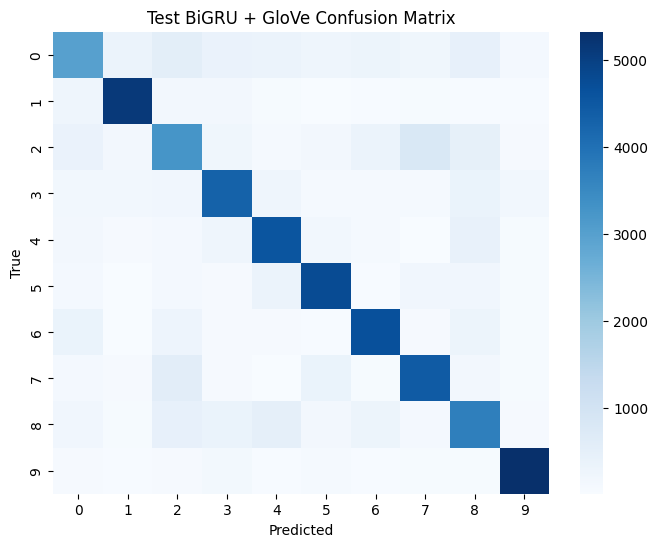

In [ ]:

print("\n== Test (biGRU + Skip-gram) ==")
_ = evaluation_set(model_bigru_g, X_test, y_test, name="Test BiGRU + GloVe")

#  Final Wrap-Up:

###  Best GRU Model
- **Model:** GRU + Skip-gram  
- **Hyperparameters:**  
  - Units = **384**  
  - Dropout = **0.35**  
  - Learning Rate = **5e-4** (Adam, clipnorm=1.0)  
  - Batch Size = **128**  
  - Embeddings = Skip-gram (300d, trainable=True)  
  - Regularization = EarlyStopping (patience=4), ReduceLROnPlateau, ModelCheckpoint

  ReduceLROnPlateau → Reduces the learning rate when a metric (like validation loss) stops improving. Helps the model converge better.

ModelCheckpoint → Saves the model whenever a monitored metric improves, so you keep the best version during training.
  
- **Performance:**  
  - **Validation:** Accuracy ≈ **0.7140**, Macro-F1 ≈ **0.7090**  
  - **Test:** Accuracy ≈ **0.7155**, Macro-F1 ≈ **0.7112**

This configuration consistently outperformed the GloVe-based GRU and BiGRU variants. Skip-gram embeddings proved more adaptive when fine-tuned, especially for mid-frequency words.

---

### Comparison with Other Neural Networks
1. **Best LSTM (GloVe)**
   - Units = 384, Dropout = 0.35  
   - Test Accuracy ≈ **0.7209**, Macro-F1 ≈ **0.7163**  
   - Slightly higher than GRU, particularly in recall for minority classes.

2. **Best Deep Neural Network (DNN + GloVe)**
   - Dense layers with safe average pooling  
   - Test Accuracy ≈ **0.7030**, Macro-F1 ≈ **0.6980**  
   - Stable but underperforms compared to sequence models.

3. **Best RNN / BiRNN**
   - Test Macro-F1 stayed in the **0.69–0.70** range  
   - Inferior to GRU/LSTM due to weaker handling of long dependencies.

---

###  Key Insights
- **GRU vs. LSTM:**  
  - GRU (Skip-gram) reached near-LSTM levels but with fewer parameters and faster training.  
  - LSTM (GloVe) narrowly wins overall with the best Macro-F1 (**0.7163** vs. GRU’s **0.7112**).  
  - In resource-constrained settings, GRU is the more efficient choice.

- **Skip-gram vs. GloVe:**  
  - Skip-gram embeddings fine-tuned better with GRU, while GloVe matched better with LSTM.  
  - Suggests interaction between embedding geometry and recurrent cell type.

- **DNNs:**  
  - Simple to train, but plateaued lower (~0.70 Macro-F1).  
  - Sequence-aware models (GRU/LSTM) are essential for this dataset.

---

### Final Recommendation
- For **highest performance** → **LSTM + GloVe** (Accuracy: 0.721 | Macro-F1: 0.716).  
- For **balanced efficiency vs. accuracy** → **GRU + Skip-gram** (Accuracy: 0.716 | Macro-F1: 0.711).  
- For **baseline comparison** → DNN + GloVe (~0.703 F1) shows the gap that recurrent models close.

**Conclusion:**  
Recurrent models with pre-trained embeddings significantly outperform feed-forward DNNs on this multi-class classification task. While LSTM remains the overall best, GRU provides a strong, faster alternative — making it the best choice when computational budget is limited.
